In [1]:
import warnings ; warnings.filterwarnings('ignore')

In [2]:
import ray
import os
import numpy as np
from ray.tune.registry import register_env
from rldm.utils import football_tools as ft
from rldm.utils import system_tools as st
from ray import tune
from ray.rllib.policy.policy import PolicySpec
from ray.rllib.utils import merge_dicts

In [3]:
n_cpus, n_gpus = st.get_cpu_gpu_count()

# Ray Initialization

In [4]:
ray.init(num_cpus=n_cpus, num_gpus=n_gpus)

{'node_ip_address': '172.17.0.2',
 'raylet_ip_address': '172.17.0.2',
 'redis_address': '172.17.0.2:45799',
 'object_store_address': '/tmp/ray/session_2022-07-21_15-58-54_036699_28512/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-07-21_15-58-54_036699_28512/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-07-21_15-58-54_036699_28512',
 'metrics_export_port': 51565,
 'node_id': 'e1c3df2c8259ee1aefe9bf2809e9b9a244519676de6161c8a480d092'}

# Environment

In [5]:
class MyEnv(ft.RllibGFootball):
    def step(self, action_dict):

        actions = []
        for idx in range(self.n_players):
            action_probs = action_dict[f'player_{idx}']
#             a = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            a = np.argmax(action_probs)
            actions.append(a)
        o, r, d, i = self.env.step(actions)

        game_info = {}
        for k, v in self.env.unwrapped._env._observation.items():
            game_info[k] = v

        scenario = self.env.unwrapped._env._config['level']
        obs, rewards, dones, infos = {}, {}, {}, {}
        for idx in range(self.n_players):
            obs[f'player_{idx}'] = o[idx] \
                if self.n_players > 1 else o
            rewards[f'player_{idx}'] = r[idx] \
                if self.n_players > 1 else r
            dones[f'player_{idx}'] = d
            dones['__all__'] = d
            infos[f'player_{idx}'] = i
            infos[f'player_{idx}']['game_scenario'] = scenario
            infos[f'player_{idx}']['game_info'] = game_info
            infos[f'player_{idx}']['action'] = action_dict[f'player_{idx}']

        return self._tidy_obs(obs), rewards, dones, infos

In [6]:
env_name = ft.n_players_to_env_name(n_players=3, auto_GK=True)
env_name

'3_vs_3_auto_GK'

In [7]:
register_env(env_name, lambda _: MyEnv(env_name=env_name))

In [8]:
obs_space, act_space = ft.get_obs_act_space(env_name)

In [9]:
def gen_policy(idx):
    # ref> https://docs.ray.io/en/latest/rllib/rllib-training.html#common-parameters
    # (policy_cls, obs_space, act_space, config)
    return PolicySpec(policy_class=None,
                      observation_space=obs_space[f'player_{idx}'],
                      action_space=act_space[f'player_{idx}'],
                      config={
                          "agent_id": idx,
                          "use_local_critic": True,
                          "obs_space_dict":obs_space,
                          "act_space_dict":act_space
                      })

In [10]:
ft_env = ft.RllibGFootball(env_name=env_name)

In [11]:
# separate policy per player.
n_policies = len(obs_space)  # number of players
policies = {
        'agent_{}'.format(idx): gen_policy(idx) for idx in range(n_policies)
    }
policy_ids = list(policies.keys())
policy_mapping_fn = lambda agent_id, episode, **kwargs: \
        policy_ids[0 if len(policy_ids) == 1 else int(agent_id.split('_')[1])]


# for shared policy
# shared_policy = {'agent_0': gen_policy(0)}
# shared_policy_mapping_fn = lambda agent_id, episode, **kwargs: 'agent_0'
# shared_multiagent = {
#     'policies': shared_policy,
#     'policy_mapping_fn': shared_policy_mapping_fn,
# }

In [12]:
from ray.rllib.contrib.maddpg import DEFAULT_CONFIG

In [13]:
common_config = merge_dicts(DEFAULT_CONFIG, {
    'env': env_name,
    "evaluation_interval": 50,
    "evaluation_num_episodes": 10,
    'num_workers': 1,  # one goes to the trainer
    'num_gpus': n_gpus,
    "horizon": 500, # maximum episode length
    "log_level": "ERROR",
    'multiagent': {
        # from policy ids to tuples
        # of (policy_cls, obs_space, act_space, config)
        'policies': policies,
        # Determines those policies that should be updated.
        'policy_mapping_fn': policy_mapping_fn
    },
    "critic_lr": 1e-7,
    "actor_lr":3e-4
})

In [14]:
algorithm = "contrib/MADDPG"
config = merge_dicts(
    common_config,
    {
        'train_batch_size':1024,
        'learning_starts': 1024 * 5
    }
)

stop = {
#     "episodes_total": 10000
    "timesteps_total": 1_000_000
}
n_trials = 1

In [15]:
a = tune.run(algorithm,
             name="MADDPG",
#              reuse_actors=True,
             stop=stop,
             num_samples=n_trials,
             checkpoint_freq=50,
             checkpoint_at_end=True,
             local_dir="../../logs",
             config=config,
#              verbose=1
             )

checkpoint_path = a.get_best_checkpoint(
    a.get_best_trial("episode_reward_mean", "max"),
    "episode_reward_mean", "max")
print('Best checkpoint found:', checkpoint_path)

(pid=28640) 2022-07-21 15:59:08,608	INFO trainer.py:714 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=28640) 2022-07-21 15:59:08,608	INFO trainer.py:728 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=28628) /opt/conda/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=28628)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
(pid=28628) /opt/conda/lib/python3.7/site-packages/ray/rllib/contrib/maddpg/maddpg_policy.py:344: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
(pid=28628)   out, units=hidden, activation=activation)
(pid=28628) /opt/conda/lib/python3.7/site-packages/ray/rllib/contrib/maddpg/maddpg_policy.py:346: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Pl

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 10400
  custom_metrics: {}
  date: 2022-07-21_15-59-40
  done: false
  episode_len_mean: 247.57142857142858
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5571428569299834
  episode_reward_min: -2.0
  episodes_this_iter: 21
  episodes_total: 21
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 5200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 10400
    num_agent_steps_trained: 2048
    num_steps_sampled: 5200
    num_steps_trained: 1024
    num_target_updates: 1
  iterations_since_restore: 1
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.734375
    gpu_util_percent0: 0.055625
    ram_util_percent: 81.709375
    vram_util_percent0: 0.2978912353515625
  pid: 28640
  policy_r

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 12600
  custom_metrics: {}
  date: 2022-07-21_15-59-45
  done: false
  episode_len_mean: 268.9130434782609
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.50869565197955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 23
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 6300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 12600
    num_agent_steps_trained: 24576
    num_steps_sampled: 6300
    num_steps_trained: 12288
    num_target_updates: 12
  iterations_since_restore: 12
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.05
    ram_util_percent: 84.8
    vram_util_percent0: 0.3236328125
  pid: 28640
  policy_reward_max:
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 14800
  custom_metrics: {}
  date: 2022-07-21_15-59-50
  done: false
  episode_len_mean: 281.15384615384613
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5269230767511405
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 26
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 7400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 14800
    num_agent_steps_trained: 47104
    num_steps_sampled: 7400
    num_steps_trained: 23552
    num_target_updates: 23
  iterations_since_restore: 23
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.2692307692307692
    agent_1: -0.2

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 17000
  custom_metrics: {}
  date: 2022-07-21_15-59-56
  done: false
  episode_len_mean: 283.17241379310343
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5413793101906776
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 29
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 8500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 17000
    num_agent_steps_trained: 69632
    num_steps_sampled: 8500
    num_steps_trained: 34816
    num_target_updates: 34
  iterations_since_restore: 34
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.27586206896551724
    agent_1: -0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 19200
  custom_metrics: {}
  date: 2022-07-21_16-00-01
  done: false
  episode_len_mean: 289.3030303030303
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.4727272725466526
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 33
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 9600
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 19200
    num_agent_steps_trained: 92160
    num_steps_sampled: 9600
    num_steps_trained: 46080
    num_target_updates: 45
  iterations_since_restore: 45
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.24242424242424243
    agent_1: -0.2

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 20200
  custom_metrics: {}
  date: 2022-07-21_16-00-16
  done: false
  episode_len_mean: 271.94444444444446
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.4333333331677649
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 36
  evaluation:
    custom_metrics: {}
    episode_len_mean: 236.45454545454547
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: -0.34545454518361524
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 184
      - 97
      - 162
      - 121
      - 158
      - 106
      - 228
      - 102
      - 500
      - 500
      - 443
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.10000000149011612
      - 0.0
      - -1.8999999985098839
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 22400
  custom_metrics: {}
  date: 2022-07-21_16-00-22
  done: false
  episode_len_mean: 275.8
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.4899999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 40
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 11200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 22400
    num_agent_steps_trained: 124928
    num_steps_sampled: 11200
    num_steps_trained: 62464
    num_target_updates: 61
  iterations_since_restore: 61
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.06
    ram_util_percent: 84.8
    vram_util_percent0: 0.33291015625
  pid: 28640
  policy_reward_max:
    agent_0: 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 24600
  custom_metrics: {}
  date: 2022-07-21_16-00-27
  done: false
  episode_len_mean: 269.6222222222222
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.4777777776122093
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 45
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 12300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 24600
    num_agent_steps_trained: 147456
    num_steps_sampled: 12300
    num_steps_trained: 73728
    num_target_updates: 72
  iterations_since_restore: 72
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.8
    gpu_util_percent0: 0.07
    ram_util_percent: 84.6
    vram_util_percent0: 0.33583984375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 26800
  custom_metrics: {}
  date: 2022-07-21_16-00-32
  done: false
  episode_len_mean: 271.7755102040816
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.43877551005202897
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 49
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 13400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 26800
    num_agent_steps_trained: 169984
    num_steps_sampled: 13400
    num_steps_trained: 84992
    num_target_updates: 83
  iterations_since_restore: 83
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.04
    ram_util_percent: 81.8
    vram_util_percent0: 0.325390625
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 29000
  custom_metrics: {}
  date: 2022-07-21_16-00-38
  done: false
  episode_len_mean: 273.33962264150944
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.403773584736968
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 53
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 14500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 29000
    num_agent_steps_trained: 192512
    num_steps_sampled: 14500
    num_steps_trained: 96256
    num_target_updates: 94
  iterations_since_restore: 94
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.05
    ram_util_percent: 80.2
    vram_util_percent0: 0.32666015625
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 30200
  custom_metrics: {}
  date: 2022-07-21_16-00-55
  done: false
  episode_len_mean: 270.3636363636364
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.38909090892835096
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 55
  evaluation:
    custom_metrics: {}
    episode_len_mean: 284.4
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.2
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 163
      - 500
      - 500
      - 500
      - 252
      - 151
      - 132
      - 260
      - 218
      - 168
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 32400
  custom_metrics: {}
  date: 2022-07-21_16-01-00
  done: false
  episode_len_mean: 274.06779661016947
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.3966101693399882
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 59
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 16200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 32400
    num_agent_steps_trained: 227328
    num_steps_sampled: 16200
    num_steps_trained: 113664
    num_target_updates: 111
  iterations_since_restore: 111
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 11.9
    gpu_util_percent0: 0.03
    ram_util_percent: 78.2
    vram_util_percent0: 0.30283203125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 34600
  custom_metrics: {}
  date: 2022-07-21_16-01-05
  done: false
  episode_len_mean: 276.38709677419354
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.40967741921063394
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 62
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 17300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 34600
    num_agent_steps_trained: 249856
    num_steps_sampled: 17300
    num_steps_trained: 124928
    num_target_updates: 122
  iterations_since_restore: 122
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.05
    ram_util_percent: 78.3
    vram_util_percent0: 0.30302734375
  pid: 28640
  policy_reward_max

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 36800
  custom_metrics: {}
  date: 2022-07-21_16-01-10
  done: false
  episode_len_mean: 270.7014925373134
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.40895522374715376
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 67
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 18400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 36800
    num_agent_steps_trained: 272384
    num_steps_sampled: 18400
    num_steps_trained: 136192
    num_target_updates: 133
  iterations_since_restore: 133
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.208955223880597
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 39000
  custom_metrics: {}
  date: 2022-07-21_16-01-15
  done: false
  episode_len_mean: 263.4189189189189
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.4243243242035041
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 74
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 19500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 39000
    num_agent_steps_trained: 294912
    num_steps_sampled: 19500
    num_steps_trained: 147456
    num_target_updates: 144
  iterations_since_restore: 144
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.21621621621621623
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 40200
  custom_metrics: {}
  date: 2022-07-21_16-01-31
  done: false
  episode_len_mean: 263.19736842105266
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.40789473664603737
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 76
  evaluation:
    custom_metrics: {}
    episode_len_mean: 267.2
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 500
      - 216
      - 170
      - 158
      - 500
      - 142
      - 170
      - 500
      - 118
      - 198
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 42400
  custom_metrics: {}
  date: 2022-07-21_16-01-37
  done: false
  episode_len_mean: 267.30379746835445
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.39240506310251694
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 79
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 21200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 42400
    num_agent_steps_trained: 329728
    num_steps_sampled: 21200
    num_steps_trained: 164864
    num_target_updates: 161
  iterations_since_restore: 161
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.1974683543549

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 44600
  custom_metrics: {}
  date: 2022-07-21_16-01-42
  done: false
  episode_len_mean: 270.8395061728395
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.40740740722344243
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 81
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 22300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 44600
    num_agent_steps_trained: 352256
    num_steps_sampled: 22300
    num_steps_trained: 176128
    num_target_updates: 172
  iterations_since_restore: 172
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.20493827153135

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 46800
  custom_metrics: {}
  date: 2022-07-21_16-01-47
  done: false
  episode_len_mean: 268.30232558139534
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.3837209300592888
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 86
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 23400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 46800
    num_agent_steps_trained: 374784
    num_steps_sampled: 23400
    num_steps_trained: 187392
    num_target_updates: 183
  iterations_since_restore: 183
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.05
    ram_util_percent: 78.5
    vram_util_percent0: 0.30185546875
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 49000
  custom_metrics: {}
  date: 2022-07-21_16-01-52
  done: false
  episode_len_mean: 270.93333333333334
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.3666666665010982
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 24500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 49000
    num_agent_steps_trained: 397312
    num_steps_sampled: 24500
    num_steps_trained: 198656
    num_target_updates: 194
  iterations_since_restore: 194
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.1
    gpu_util_percent0: 0.03
    ram_util_percent: 78.6
    vram_util_percent0: 0.29736328125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 50200
  custom_metrics: {}
  date: 2022-07-21_16-02-08
  done: false
  episode_len_mean: 269.7717391304348
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.3586956520119439
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 92
  evaluation:
    custom_metrics: {}
    episode_len_mean: 230.1818181818182
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.18181818181818182
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 137
      - 229
      - 500
      - 134
      - 80
      - 105
      - 210
      - 266
      - 113
      - 258
      - 500
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 52400
  custom_metrics: {}
  date: 2022-07-21_16-02-13
  done: false
  episode_len_mean: 271.6458333333333
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.3645833331781129
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 96
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 26200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 52400
    num_agent_steps_trained: 432128
    num_steps_sampled: 26200
    num_steps_trained: 216064
    num_target_updates: 211
  iterations_since_restore: 211
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.5
    gpu_util_percent0: 0.04
    ram_util_percent: 78.7
    vram_util_percent0: 0.30185546875
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 54600
  custom_metrics: {}
  date: 2022-07-21_16-02-18
  done: false
  episode_len_mean: 275.54545454545456
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.35353535338483677
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 99
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 27300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 54600
    num_agent_steps_trained: 454656
    num_steps_sampled: 27300
    num_steps_trained: 227328
    num_target_updates: 222
  iterations_since_restore: 222
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.1777777777175

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 56800
  custom_metrics: {}
  date: 2022-07-21_16-02-23
  done: false
  episode_len_mean: 274.91
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.3499999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 104
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 28400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 56800
    num_agent_steps_trained: 477184
    num_steps_sampled: 28400
    num_steps_trained: 238592
    num_target_updates: 233
  iterations_since_restore: 233
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.1749999999254942
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 59000
  custom_metrics: {}
  date: 2022-07-21_16-02-28
  done: false
  episode_len_mean: 270.38
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.3499999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 109
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 29500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 59000
    num_agent_steps_trained: 499712
    num_steps_sampled: 29500
    num_steps_trained: 249856
    num_target_updates: 244
  iterations_since_restore: 244
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.1749999999254942
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 60200
  custom_metrics: {}
  date: 2022-07-21_16-02-42
  done: false
  episode_len_mean: 270.96
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.33099999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 111
  evaluation:
    custom_metrics: {}
    episode_len_mean: 213.1
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.6
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 285
      - 120
      - 500
      - 117
      - 247
      - 133
      - 122
      - 115
      - 375
      - 117
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 62400
  custom_metrics: {}
  date: 2022-07-21_16-02-47
  done: false
  episode_len_mean: 274.79
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.29099999986588954
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 116
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 31200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 62400
    num_agent_steps_trained: 534528
    num_steps_sampled: 31200
    num_steps_trained: 267264
    num_target_updates: 261
  iterations_since_restore: 261
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.03
    ram_util_percent: 79.1
    vram_util_percent0: 0.30185546875
  pid: 28640
  policy_reward_max:
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 64600
  custom_metrics: {}
  date: 2022-07-21_16-02-52
  done: false
  episode_len_mean: 273.43
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.29099999986588954
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 120
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 32300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 64600
    num_agent_steps_trained: 557056
    num_steps_sampled: 32300
    num_steps_trained: 278528
    num_target_updates: 272
  iterations_since_restore: 272
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.04
    ram_util_percent: 79.2
    vram_util_percent0: 0.3013671875
  pid: 28640
  policy_reward_max:
    agent_0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 66600
  custom_metrics: {}
  date: 2022-07-21_16-02-57
  done: false
  episode_len_mean: 271.24
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.29099999986588954
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 122
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 33300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 66600
    num_agent_steps_trained: 577536
    num_steps_sampled: 33300
    num_steps_trained: 288768
    num_target_updates: 282
  iterations_since_restore: 282
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.14399999991059304
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 68800
  custom_metrics: {}
  date: 2022-07-21_16-03-03
  done: false
  episode_len_mean: 267.71
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2709999998658896
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 34400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 68800
    num_agent_steps_trained: 600064
    num_steps_sampled: 34400
    num_steps_trained: 300032
    num_target_updates: 293
  iterations_since_restore: 293
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.13399999991059303
    age

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 70200
  custom_metrics: {}
  date: 2022-07-21_16-03-21
  done: false
  episode_len_mean: 268.25
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.25099999986588956
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 129
  evaluation:
    custom_metrics: {}
    episode_len_mean: 300.0
    episode_media: {}
    episode_reward_max: 0.800000011920929
    episode_reward_mean: -0.1199999988079071
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 380
      - 171
      - 223
      - 127
      - 443
      - 417
      - 500
      - 122
      - 500
      - 117
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.800000011920929
      - -2.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 72400
  custom_metrics: {}
  date: 2022-07-21_16-03-26
  done: false
  episode_len_mean: 268.81
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2709999998658896
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 132
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 36200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 72400
    num_agent_steps_trained: 636928
    num_steps_sampled: 36200
    num_steps_trained: 318464
    num_target_updates: 311
  iterations_since_restore: 311
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.3
    gpu_util_percent0: 0.02
    ram_util_percent: 79.4
    vram_util_percent0: 0.30126953125
  pid: 28640
  policy_reward_max:
    agent_0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 74600
  custom_metrics: {}
  date: 2022-07-21_16-03-31
  done: false
  episode_len_mean: 270.66
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2719999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 136
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 37300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 74600
    num_agent_steps_trained: 659456
    num_steps_sampled: 37300
    num_steps_trained: 329728
    num_target_updates: 322
  iterations_since_restore: 322
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.04
    ram_util_percent: 79.8
    vram_util_percent0: 0.30126953125
  pid: 28640
  policy_reward_max:
    agent_0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 76800
  custom_metrics: {}
  date: 2022-07-21_16-03-37
  done: false
  episode_len_mean: 268.71
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2519999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 141
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 38400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 76800
    num_agent_steps_trained: 681984
    num_steps_sampled: 38400
    num_steps_trained: 340992
    num_target_updates: 333
  iterations_since_restore: 333
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.3
    gpu_util_percent0: 0.05
    ram_util_percent: 79.8
    vram_util_percent0: 0.29677734375
  pid: 28640
  policy_reward_max:
    agent_0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 79000
  custom_metrics: {}
  date: 2022-07-21_16-03-42
  done: false
  episode_len_mean: 268.56
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.23299999989569187
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 146
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 39500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 79000
    num_agent_steps_trained: 704512
    num_steps_sampled: 39500
    num_steps_trained: 352256
    num_target_updates: 344
  iterations_since_restore: 344
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.5
    gpu_util_percent0: 0.06
    ram_util_percent: 79.9
    vram_util_percent0: 0.30126953125
  pid: 28640
  policy_reward_max:
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 80200
  custom_metrics: {}
  date: 2022-07-21_16-03-58
  done: false
  episode_len_mean: 267.33
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.23299999989569187
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 148
  evaluation:
    custom_metrics: {}
    episode_len_mean: 259.4
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.2
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 500
      - 117
      - 298
      - 124
      - 500
      - 131
      - 440
      - 112
      - 256
      - 116
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 82400
  custom_metrics: {}
  date: 2022-07-21_16-04-03
  done: false
  episode_len_mean: 263.57
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.253999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 154
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 41200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 82400
    num_agent_steps_trained: 739328
    num_steps_sampled: 41200
    num_steps_trained: 369664
    num_target_updates: 361
  iterations_since_restore: 361
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.12399999991059303
    agent_1: -0.13
  pol

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 84600
  custom_metrics: {}
  date: 2022-07-21_16-04-08
  done: false
  episode_len_mean: 266.65
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2519999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 157
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 42300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 84600
    num_agent_steps_trained: 761856
    num_steps_sampled: 42300
    num_steps_trained: 380928
    num_target_updates: 372
  iterations_since_restore: 372
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.5
    gpu_util_percent0: 0.04
    ram_util_percent: 79.9
    vram_util_percent0: 0.30126953125
  pid: 28640
  policy_reward_max:
    agent_0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 86800
  custom_metrics: {}
  date: 2022-07-21_16-04-14
  done: false
  episode_len_mean: 263.26
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2519999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 160
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 43400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 86800
    num_agent_steps_trained: 784384
    num_steps_sampled: 43400
    num_steps_trained: 392192
    num_target_updates: 383
  iterations_since_restore: 383
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.1
    gpu_util_percent0: 0.06
    ram_util_percent: 79.9
    vram_util_percent0: 0.30126953125
  pid: 28640
  policy_reward_max:
    agent_0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 89000
  custom_metrics: {}
  date: 2022-07-21_16-04-19
  done: false
  episode_len_mean: 265.07
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2119999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 164
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 44500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 89000
    num_agent_steps_trained: 806912
    num_steps_sampled: 44500
    num_steps_trained: 403456
    num_target_updates: 394
  iterations_since_restore: 394
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.04
    ram_util_percent: 80.0
    vram_util_percent0: 0.29677734375
  pid: 28640
  policy_reward_max:
    agent_0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 90200
  custom_metrics: {}
  date: 2022-07-21_16-04-36
  done: false
  episode_len_mean: 268.15
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2119999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 165
  evaluation:
    custom_metrics: {}
    episode_len_mean: 293.1
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.4
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 229
      - 173
      - 303
      - 131
      - 284
      - 117
      - 478
      - 216
      - 500
      - 500
      episode_reward:
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
     

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 92200
  custom_metrics: {}
  date: 2022-07-21_16-04-41
  done: false
  episode_len_mean: 272.92
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.19199999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 169
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 46100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 92200
    num_agent_steps_trained: 839680
    num_steps_sampled: 46100
    num_steps_trained: 419840
    num_target_updates: 410
  iterations_since_restore: 410
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.04
    ram_util_percent: 80.2
    vram_util_percent0: 0.30126953125
  pid: 28640
  policy_reward_max:
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 94400
  custom_metrics: {}
  date: 2022-07-21_16-04-46
  done: false
  episode_len_mean: 277.97
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1719999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 173
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 47200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 94400
    num_agent_steps_trained: 862208
    num_steps_sampled: 47200
    num_steps_trained: 431104
    num_target_updates: 421
  iterations_since_restore: 421
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.05
    ram_util_percent: 80.3
    vram_util_percent0: 0.29677734375
  pid: 28640
  policy_reward_max:
    agent_0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 96600
  custom_metrics: {}
  date: 2022-07-21_16-04-52
  done: false
  episode_len_mean: 275.3
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.19599999994039535
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 178
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 48300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 96600
    num_agent_steps_trained: 884736
    num_steps_sampled: 48300
    num_steps_trained: 442368
    num_target_updates: 432
  iterations_since_restore: 432
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.10000000149011612
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09799999997019768
    agent_1: -0.09799

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 98800
  custom_metrics: {}
  date: 2022-07-21_16-04-57
  done: false
  episode_len_mean: 265.74
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.1949999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 183
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 49400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 98800
    num_agent_steps_trained: 907264
    num_steps_sampled: 49400
    num_steps_trained: 453632
    num_target_updates: 443
  iterations_since_restore: 443
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.10000000149011612
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09699999995529651
    agent_1: -0.09799

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 100200
  custom_metrics: {}
  date: 2022-07-21_16-05-12
  done: false
  episode_len_mean: 268.7
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.2149999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 186
  evaluation:
    custom_metrics: {}
    episode_len_mean: 230.3
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 144
      - 143
      - 365
      - 203
      - 205
      - 128
      - 349
      - 149
      - 500
      - 117
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 102400
  custom_metrics: {}
  date: 2022-07-21_16-05-17
  done: false
  episode_len_mean: 257.39
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.2749999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 193
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 51200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 102400
    num_agent_steps_trained: 944128
    num_steps_sampled: 51200
    num_steps_trained: 472064
    num_target_updates: 461
  iterations_since_restore: 461
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.2
    gpu_util_percent0: 0.03
    ram_util_percent: 80.6
    vram_util_percent0: 0.29677734375
  pid: 28640
  policy_reward_max:
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 104600
  custom_metrics: {}
  date: 2022-07-21_16-05-22
  done: false
  episode_len_mean: 254.69
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.2749999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 198
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 52300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 104600
    num_agent_steps_trained: 966656
    num_steps_sampled: 52300
    num_steps_trained: 483328
    num_target_updates: 472
  iterations_since_restore: 472
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.04
    ram_util_percent: 80.6
    vram_util_percent0: 0.29677734375
  pid: 28640
  policy_reward_max:
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 106800
  custom_metrics: {}
  date: 2022-07-21_16-05-28
  done: false
  episode_len_mean: 258.87
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.2749999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 201
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 53400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 106800
    num_agent_steps_trained: 989184
    num_steps_sampled: 53400
    num_steps_trained: 494592
    num_target_updates: 483
  iterations_since_restore: 483
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.2
    gpu_util_percent0: 0.03
    ram_util_percent: 80.7
    vram_util_percent0: 0.29677734375
  pid: 28640
  policy_reward_max:
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 109000
  custom_metrics: {}
  date: 2022-07-21_16-05-33
  done: false
  episode_len_mean: 256.66
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.29599999994039533
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 206
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 54500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 109000
    num_agent_steps_trained: 1011712
    num_steps_sampled: 54500
    num_steps_trained: 505856
    num_target_updates: 494
  iterations_since_restore: 494
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.10000000149011612
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.14799999997019767
    agent_1: -0.1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 110200
  custom_metrics: {}
  date: 2022-07-21_16-05-47
  done: false
  episode_len_mean: 252.32
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.27599999994039537
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 210
  evaluation:
    custom_metrics: {}
    episode_len_mean: 212.1
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.4
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 105
      - 125
      - 169
      - 500
      - 129
      - 116
      - 469
      - 120
      - 225
      - 163
      episode_reward:
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - -1.0
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 112400
  custom_metrics: {}
  date: 2022-07-21_16-05-52
  done: false
  episode_len_mean: 251.3
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.28599999979138374
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 214
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 56200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 112400
    num_agent_steps_trained: 1046528
    num_steps_sampled: 56200
    num_steps_trained: 523264
    num_target_updates: 511
  iterations_since_restore: 511
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.06
    ram_util_percent: 80.9
    vram_util_percent0: 0.29677734375
  pid: 28640
  policy_reward_max:
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 114600
  custom_metrics: {}
  date: 2022-07-21_16-05-57
  done: false
  episode_len_mean: 250.66
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.30599999979138376
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 219
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 57300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 114600
    num_agent_steps_trained: 1069056
    num_steps_sampled: 57300
    num_steps_trained: 534528
    num_target_updates: 522
  iterations_since_restore: 522
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.04
    ram_util_percent: 81.0
    vram_util_percent0: 0.29677734375
  pid: 28640
  policy_reward_max:
    age

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 116800
  custom_metrics: {}
  date: 2022-07-21_16-06-02
  done: false
  episode_len_mean: 253.96
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.2869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 222
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 58400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 116800
    num_agent_steps_trained: 1091584
    num_steps_sampled: 58400
    num_steps_trained: 545792
    num_target_updates: 533
  iterations_since_restore: 533
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.9000000134110451
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.13999999985098838
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 119000
  custom_metrics: {}
  date: 2022-07-21_16-06-08
  done: false
  episode_len_mean: 250.94
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.2839999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 226
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 59500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 119000
    num_agent_steps_trained: 1114112
    num_steps_sampled: 59500
    num_steps_trained: 557056
    num_target_updates: 544
  iterations_since_restore: 544
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.9000000134110451
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.1369999998062849
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 120200
  custom_metrics: {}
  date: 2022-07-21_16-06-21
  done: false
  episode_len_mean: 250.94
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.2839999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 227
  evaluation:
    custom_metrics: {}
    episode_len_mean: 199.54545454545453
    episode_media: {}
    episode_reward_max: 0.20000000298023224
    episode_reward_mean: -0.16363636336543344
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 123
      - 120
      - 225
      - 500
      - 157
      - 314
      - 253
      - 162
      - 97
      - 133
      - 111
      episode_reward:
      - -2.0
      - 0.0
      - 0.20000000298023224
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 122400
  custom_metrics: {}
  date: 2022-07-21_16-06-27
  done: false
  episode_len_mean: 248.53
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.2829999997466803
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 231
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 61200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 122400
    num_agent_steps_trained: 1148928
    num_steps_sampled: 61200
    num_steps_trained: 574464
    num_target_updates: 561
  iterations_since_restore: 561
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.04
    ram_util_percent: 81.6
    vram_util_percent0: 0.29599609375
  pid: 28640
  policy_reward_max:
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 124400
  custom_metrics: {}
  date: 2022-07-21_16-06-32
  done: false
  episode_len_mean: 252.31
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.254999999627471
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 62200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 124400
    num_agent_steps_trained: 1169408
    num_steps_sampled: 62200
    num_steps_trained: 584704
    num_target_updates: 571
  iterations_since_restore: 571
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.9000000134110451
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.11799999967217445
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 126600
  custom_metrics: {}
  date: 2022-07-21_16-06-37
  done: false
  episode_len_mean: 251.89
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.24999999962747096
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 239
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 63300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 126600
    num_agent_steps_trained: 1191936
    num_steps_sampled: 63300
    num_steps_trained: 595968
    num_target_updates: 582
  iterations_since_restore: 582
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.9000000134110451
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.11299999967217446
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 128800
  custom_metrics: {}
  date: 2022-07-21_16-06-42
  done: false
  episode_len_mean: 243.79
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.24999999962747096
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 247
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 64400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 128800
    num_agent_steps_trained: 1214464
    num_steps_sampled: 64400
    num_steps_trained: 607232
    num_target_updates: 593
  iterations_since_restore: 593
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.9000000134110451
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.11299999967217446
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 130200
  custom_metrics: {}
  date: 2022-07-21_16-06-57
  done: false
  episode_len_mean: 244.37
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.22999999962747097
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 251
  evaluation:
    custom_metrics: {}
    episode_len_mean: 193.9090909090909
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.18181818181818182
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 117
      - 105
      - 183
      - 110
      - 183
      - 151
      - 500
      - 39
      - 500
      - 118
      - 127
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 132400
  custom_metrics: {}
  date: 2022-07-21_16-07-02
  done: false
  episode_len_mean: 236.17
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.2319999996572733
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 257
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 66200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 132400
    num_agent_steps_trained: 1251328
    num_steps_sampled: 66200
    num_steps_trained: 625664
    num_target_updates: 611
  iterations_since_restore: 611
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.2
    gpu_util_percent0: 0.06
    ram_util_percent: 82.0
    vram_util_percent0: 0.29150390625
  pid: 28640
  policy_reward_max:
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 134600
  custom_metrics: {}
  date: 2022-07-21_16-07-08
  done: false
  episode_len_mean: 227.82
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.25199999965727327
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 263
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 67300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 134600
    num_agent_steps_trained: 1273856
    num_steps_sampled: 67300
    num_steps_trained: 636928
    num_target_updates: 622
  iterations_since_restore: 622
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.02
    ram_util_percent: 82.1
    vram_util_percent0: 0.29599609375
  pid: 28640
  policy_reward_max:
    age

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 136800
  custom_metrics: {}
  date: 2022-07-21_16-07-13
  done: false
  episode_len_mean: 222.56
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.2719999996572733
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 268
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 68400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 136800
    num_agent_steps_trained: 1296384
    num_steps_sampled: 68400
    num_steps_trained: 648192
    num_target_updates: 633
  iterations_since_restore: 633
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.03
    ram_util_percent: 82.1
    vram_util_percent0: 0.29150390625
  pid: 28640
  policy_reward_max:
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 139000
  custom_metrics: {}
  date: 2022-07-21_16-07-18
  done: false
  episode_len_mean: 225.15
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.2919999996572733
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 272
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 69500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 139000
    num_agent_steps_trained: 1318912
    num_steps_sampled: 69500
    num_steps_trained: 659456
    num_target_updates: 644
  iterations_since_restore: 644
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.05
    ram_util_percent: 82.2
    vram_util_percent0: 0.29150390625
  pid: 28640
  policy_reward_max:
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 140200
  custom_metrics: {}
  date: 2022-07-21_16-07-31
  done: false
  episode_len_mean: 223.02
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.2919999996572733
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 275
  evaluation:
    custom_metrics: {}
    episode_len_mean: 194.1
    episode_media: {}
    episode_reward_max: 0.5
    episode_reward_mean: -0.3399999998509884
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 111
      - 123
      - 104
      - 201
      - 106
      - 368
      - 117
      - 500
      - 104
      - 207
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.5
      - 0.0
      - -2.0
      - 0.10000000149011612
      - 0.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.5
      - 0.0
      - -1.0
      - 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 142400
  custom_metrics: {}
  date: 2022-07-21_16-07-37
  done: false
  episode_len_mean: 226.74
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.2719999996572733
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 279
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 71200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 142400
    num_agent_steps_trained: 1353728
    num_steps_sampled: 71200
    num_steps_trained: 676864
    num_target_updates: 661
  iterations_since_restore: 661
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.04
    ram_util_percent: 82.3
    vram_util_percent0: 0.29599609375
  pid: 28640
  policy_reward_max:
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 144600
  custom_metrics: {}
  date: 2022-07-21_16-07-42
  done: false
  episode_len_mean: 223.35
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.2729999996721745
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 285
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 72300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 144600
    num_agent_steps_trained: 1376256
    num_steps_sampled: 72300
    num_steps_trained: 688128
    num_target_updates: 672
  iterations_since_restore: 672
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.04
    ram_util_percent: 82.4
    vram_util_percent0: 0.29150390625
  pid: 28640
  policy_reward_max:
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 146800
  custom_metrics: {}
  date: 2022-07-21_16-07-47
  done: false
  episode_len_mean: 226.92
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.2729999996721745
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 289
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 73400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 146800
    num_agent_steps_trained: 1398784
    num_steps_sampled: 73400
    num_steps_trained: 699392
    num_target_updates: 683
  iterations_since_restore: 683
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.3
    gpu_util_percent0: 0.04
    ram_util_percent: 82.5
    vram_util_percent0: 0.29150390625
  pid: 28640
  policy_reward_max:
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 149000
  custom_metrics: {}
  date: 2022-07-21_16-07-52
  done: false
  episode_len_mean: 233.49
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.23299999967217444
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 293
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 74500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 149000
    num_agent_steps_trained: 1421312
    num_steps_sampled: 74500
    num_steps_trained: 710656
    num_target_updates: 694
  iterations_since_restore: 694
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.9000000134110451
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.10399999968707561
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 150200
  custom_metrics: {}
  date: 2022-07-21_16-08-05
  done: false
  episode_len_mean: 234.66
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.23299999967217444
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 294
  evaluation:
    custom_metrics: {}
    episode_len_mean: 185.8
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: 0.020000000298023225
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 102
      - 407
      - 175
      - 172
      - 117
      - 270
      - 110
      - 107
      - 103
      - 295
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.10000000149011612
      - 0.0
      - 0.10000000149011612
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 152400
  custom_metrics: {}
  date: 2022-07-21_16-08-10
  done: false
  episode_len_mean: 232.35
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.22699999943375587
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 300
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 76200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 152400
    num_agent_steps_trained: 1456128
    num_steps_sampled: 76200
    num_steps_trained: 728064
    num_target_updates: 711
  iterations_since_restore: 711
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.9000000134110451
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.09799999944865703
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 154600
  custom_metrics: {}
  date: 2022-07-21_16-08-15
  done: false
  episode_len_mean: 230.09
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.20699999943375588
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 305
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 77300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 154600
    num_agent_steps_trained: 1478656
    num_steps_sampled: 77300
    num_steps_trained: 739328
    num_target_updates: 722
  iterations_since_restore: 722
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.03
    ram_util_percent: 82.8
    vram_util_percent0: 0.29599609375
  pid: 28640
  policy_reward_max:
    age

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 156800
  custom_metrics: {}
  date: 2022-07-21_16-08-21
  done: false
  episode_len_mean: 233.12
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: -0.20699999943375588
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 309
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 78400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 156800
    num_agent_steps_trained: 1501184
    num_steps_sampled: 78400
    num_steps_trained: 750592
    num_target_updates: 733
  iterations_since_restore: 733
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.3
    gpu_util_percent0: 0.04
    ram_util_percent: 82.8
    vram_util_percent0: 0.29599609375
  pid: 28640
  policy_reward_max:
    age

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 159000
  custom_metrics: {}
  date: 2022-07-21_16-08-26
  done: false
  episode_len_mean: 232.1
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.19699999958276748
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 313
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 79500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 159000
    num_agent_steps_trained: 1523712
    num_steps_sampled: 79500
    num_steps_trained: 761856
    num_target_updates: 744
  iterations_since_restore: 744
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.03
    ram_util_percent: 82.9
    vram_util_percent0: 0.29150390625
  pid: 28640
  policy_reward_max:
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 160200
  custom_metrics: {}
  date: 2022-07-21_16-08-44
  done: false
  episode_len_mean: 231.86
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.19699999958276748
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 315
  evaluation:
    custom_metrics: {}
    episode_len_mean: 305.2
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: 0.010000000149011612
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 121
      - 500
      - 107
      - 500
      - 103
      - 500
      - 113
      - 500
      - 108
      - 500
      episode_reward:
      - 0.10000000149011612
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.10000000149011612
      - 0.0
      - 0.0
      - 0.0
     

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 162400
  custom_metrics: {}
  date: 2022-07-21_16-08-49
  done: false
  episode_len_mean: 237.25
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.1769999995827675
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 319
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 81200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 162400
    num_agent_steps_trained: 1558528
    num_steps_sampled: 81200
    num_steps_trained: 779264
    num_target_updates: 761
  iterations_since_restore: 761
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.02
    ram_util_percent: 83.3
    vram_util_percent0: 0.29208984375
  pid: 28640
  policy_reward_max:
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 164400
  custom_metrics: {}
  date: 2022-07-21_16-08-55
  done: false
  episode_len_mean: 232.49
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.19999999962747098
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 324
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 82200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 164400
    num_agent_steps_trained: 1579008
    num_steps_sampled: 82200
    num_steps_trained: 789504
    num_target_updates: 771
  iterations_since_restore: 771
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 20.6
    gpu_util_percent0: 0.05
    ram_util_percent: 83.4
    vram_util_percent0: 0.29599609375
  pid: 28640
  policy_reward_max:
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 166600
  custom_metrics: {}
  date: 2022-07-21_16-09-00
  done: false
  episode_len_mean: 225.93
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.1989999996125698
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 329
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 83300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 166600
    num_agent_steps_trained: 1601536
    num_steps_sampled: 83300
    num_steps_trained: 800768
    num_target_updates: 782
  iterations_since_restore: 782
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.800000011920929
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.08899999961256981
    agent_1: -0.11
  p

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 168800
  custom_metrics: {}
  date: 2022-07-21_16-09-05
  done: false
  episode_len_mean: 227.92
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.20799999974668026
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 333
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 84400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 168800
    num_agent_steps_trained: 1624064
    num_steps_sampled: 84400
    num_steps_trained: 812032
    num_target_updates: 793
  iterations_since_restore: 793
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.04
    ram_util_percent: 83.3
    vram_util_percent0: 0.29599609375
  pid: 28640
  policy_reward_max:
    age

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 170200
  custom_metrics: {}
  date: 2022-07-21_16-09-23
  done: false
  episode_len_mean: 227.39
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.20799999974668026
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 335
  evaluation:
    custom_metrics: {}
    episode_len_mean: 256.0
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.18181818181818182
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 107
      - 500
      - 96
      - 500
      - 105
      - 500
      - 106
      - 196
      - 106
      - 500
      - 100
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 172400
  custom_metrics: {}
  date: 2022-07-21_16-09-28
  done: false
  episode_len_mean: 230.41
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.19299999974668025
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 339
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 86200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 172400
    num_agent_steps_trained: 1660928
    num_steps_sampled: 86200
    num_steps_trained: 830464
    num_target_updates: 811
  iterations_since_restore: 811
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.1
    gpu_util_percent0: 0.04
    ram_util_percent: 83.5
    vram_util_percent0: 0.29150390625
  pid: 28640
  policy_reward_max:
    age

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 174600
  custom_metrics: {}
  date: 2022-07-21_16-09-34
  done: false
  episode_len_mean: 232.13
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.19299999974668025
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 343
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 87300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 174600
    num_agent_steps_trained: 1683456
    num_steps_sampled: 87300
    num_steps_trained: 841728
    num_target_updates: 822
  iterations_since_restore: 822
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09299999974668026
    agent_1: -0.1
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 176800
  custom_metrics: {}
  date: 2022-07-21_16-09-39
  done: false
  episode_len_mean: 235.42
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1859999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 349
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 88400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 176800
    num_agent_steps_trained: 1705984
    num_steps_sampled: 88400
    num_steps_trained: 852992
    num_target_updates: 833
  iterations_since_restore: 833
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0859999992698431
    agent_1: -0.1
  p

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 179000
  custom_metrics: {}
  date: 2022-07-21_16-09-44
  done: false
  episode_len_mean: 240.56
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2059999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 354
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 89500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 179000
    num_agent_steps_trained: 1728512
    num_steps_sampled: 89500
    num_steps_trained: 864256
    num_target_updates: 844
  iterations_since_restore: 844
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0959999992698431
    agent_1: -0.11
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 180200
  custom_metrics: {}
  date: 2022-07-21_16-10-00
  done: false
  episode_len_mean: 240.73
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2059999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 357
  evaluation:
    custom_metrics: {}
    episode_len_mean: 254.4
    episode_media: {}
    episode_reward_max: 0.4000000059604645
    episode_reward_mean: 0.04000000059604645
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 226
      - 108
      - 216
      - 184
      - 500
      - 102
      - 500
      - 106
      - 500
      - 102
      episode_reward:
      - 0.0
      - 0.0
      - 0.4000000059604645
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.4000000059604645
      - 0.0
      - 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 182400
  custom_metrics: {}
  date: 2022-07-21_16-10-05
  done: false
  episode_len_mean: 244.5
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2059999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 361
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 91200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 182400
    num_agent_steps_trained: 1763328
    num_steps_sampled: 91200
    num_steps_trained: 881664
    num_target_updates: 861
  iterations_since_restore: 861
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0959999992698431
    agent_1: -0.11
  p

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 184600
  custom_metrics: {}
  date: 2022-07-21_16-10-11
  done: false
  episode_len_mean: 247.17
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2059999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 365
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 92300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 184600
    num_agent_steps_trained: 1785856
    num_steps_sampled: 92300
    num_steps_trained: 892928
    num_target_updates: 872
  iterations_since_restore: 872
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.07
    ram_util_percent: 84.0
    vram_util_percent0: 0.29599609375
  pid: 28640
  policy_reward_max:
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 186800
  custom_metrics: {}
  date: 2022-07-21_16-10-16
  done: false
  episode_len_mean: 243.98
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1859999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 369
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 93400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 186800
    num_agent_steps_trained: 1808384
    num_steps_sampled: 93400
    num_steps_trained: 904192
    num_target_updates: 883
  iterations_since_restore: 883
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.03
    ram_util_percent: 84.0
    vram_util_percent0: 0.29599609375
  pid: 28640
  policy_reward_max:
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 189000
  custom_metrics: {}
  date: 2022-07-21_16-10-21
  done: false
  episode_len_mean: 247.37
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1859999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 373
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 94500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 189000
    num_agent_steps_trained: 1830912
    num_steps_sampled: 94500
    num_steps_trained: 915456
    num_target_updates: 894
  iterations_since_restore: 894
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.5
    gpu_util_percent0: 0.04
    ram_util_percent: 84.3
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    agent_0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 190200
  custom_metrics: {}
  date: 2022-07-21_16-10-41
  done: false
  episode_len_mean: 247.98
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2059999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 377
  evaluation:
    custom_metrics: {}
    episode_len_mean: 309.1818181818182
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.18181818181818182
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 500
      - 106
      - 500
      - 103
      - 387
      - 106
      - 500
      - 94
      - 500
      - 105
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -1.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 192200
  custom_metrics: {}
  date: 2022-07-21_16-10-46
  done: false
  episode_len_mean: 243.57
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2059999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 381
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 96100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 192200
    num_agent_steps_trained: 1863680
    num_steps_sampled: 96100
    num_steps_trained: 931840
    num_target_updates: 910
  iterations_since_restore: 910
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.3
    gpu_util_percent0: 0.05
    ram_util_percent: 84.4
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    agent_0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 194400
  custom_metrics: {}
  date: 2022-07-21_16-10-52
  done: false
  episode_len_mean: 250.66
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1859999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 384
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 97200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 194400
    num_agent_steps_trained: 1886208
    num_steps_sampled: 97200
    num_steps_trained: 943104
    num_target_updates: 921
  iterations_since_restore: 921
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0859999992698431
    agent_1: -0.1
  p

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 196600
  custom_metrics: {}
  date: 2022-07-21_16-10-57
  done: false
  episode_len_mean: 249.12
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1659999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 387
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 98300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 196600
    num_agent_steps_trained: 1908736
    num_steps_sampled: 98300
    num_steps_trained: 954368
    num_target_updates: 932
  iterations_since_restore: 932
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0759999992698431
    agent_1: -0.09
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 198800
  custom_metrics: {}
  date: 2022-07-21_16-11-02
  done: false
  episode_len_mean: 241.94
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.21199999950826168
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 395
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 99400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 198800
    num_agent_steps_trained: 1931264
    num_steps_sampled: 99400
    num_steps_trained: 965632
    num_target_updates: 943
  iterations_since_restore: 943
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10199999950826168
    agent_1: -0.11


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 200200
  custom_metrics: {}
  date: 2022-07-21_16-11-15
  done: false
  episode_len_mean: 245.5
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.21199999950826168
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 397
  evaluation:
    custom_metrics: {}
    episode_len_mean: 158.45454545454547
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.18181818181818182
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 107
      - 110
      - 100
      - 500
      - 93
      - 128
      - 103
      - 136
      - 105
      - 256
      - 105
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 202400
  custom_metrics: {}
  date: 2022-07-21_16-11-20
  done: false
  episode_len_mean: 248.03
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1919999995082617
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 401
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 101200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 202400
    num_agent_steps_trained: 1968128
    num_steps_sampled: 101200
    num_steps_trained: 984064
    num_target_updates: 961
  iterations_since_restore: 961
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.04
    ram_util_percent: 84.1
    vram_util_percent0: 0.2892578125
  pid: 28640
  policy_reward_max:
    age

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 204600
  custom_metrics: {}
  date: 2022-07-21_16-11-26
  done: false
  episode_len_mean: 250.89
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.18699999950826168
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 404
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 102300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 204600
    num_agent_steps_trained: 1990656
    num_steps_sampled: 102300
    num_steps_trained: 995328
    num_target_updates: 972
  iterations_since_restore: 972
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.05
    ram_util_percent: 84.2
    vram_util_percent0: 0.284765625
  pid: 28640
  policy_reward_max:
    age

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 206800
  custom_metrics: {}
  date: 2022-07-21_16-11-31
  done: false
  episode_len_mean: 250.66
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.18699999950826168
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 407
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 103400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 206800
    num_agent_steps_trained: 2013184
    num_steps_sampled: 103400
    num_steps_trained: 1006592
    num_target_updates: 983
  iterations_since_restore: 983
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.08699999950826168
    agent_1: -0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 209000
  custom_metrics: {}
  date: 2022-07-21_16-11-36
  done: false
  episode_len_mean: 253.59
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1669999995082617
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 413
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 104500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 209000
    num_agent_steps_trained: 2035712
    num_steps_sampled: 104500
    num_steps_trained: 1017856
    num_target_updates: 994
  iterations_since_restore: 994
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.04
    ram_util_percent: 84.4
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 210200
  custom_metrics: {}
  date: 2022-07-21_16-11-47
  done: false
  episode_len_mean: 253.69
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.16599999949336053
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 415
  evaluation:
    custom_metrics: {}
    episode_len_mean: 136.9090909090909
    episode_media: {}
    episode_reward_max: 0.4000000059604645
    episode_reward_mean: -0.3272727267308669
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 110
      - 91
      - 204
      - 104
      - 157
      - 102
      - 203
      - 103
      - 139
      - 104
      - 189
      episode_reward:
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.4000000059604645
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 212200
  custom_metrics: {}
  date: 2022-07-21_16-11-52
  done: false
  episode_len_mean: 250.25
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.18499999947845935
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 419
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 106100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 212200
    num_agent_steps_trained: 2068480
    num_steps_sampled: 106100
    num_steps_trained: 1034240
    num_target_updates: 1010
  iterations_since_restore: 1010
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.0
    gpu_util_percent0: 0.04
    ram_util_percent: 84.3
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 214200
  custom_metrics: {}
  date: 2022-07-21_16-11-57
  done: false
  episode_len_mean: 245.8
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.20499999947845937
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 426
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 107100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 214200
    num_agent_steps_trained: 2088960
    num_steps_sampled: 107100
    num_steps_trained: 1044480
    num_target_updates: 1020
  iterations_since_restore: 1020
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.09599999949336052

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 216400
  custom_metrics: {}
  date: 2022-07-21_16-12-03
  done: false
  episode_len_mean: 249.63
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2059999994933605
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 429
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 108200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 216400
    num_agent_steps_trained: 2111488
    num_steps_sampled: 108200
    num_steps_trained: 1055744
    num_target_updates: 1031
  iterations_since_restore: 1031
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.04
    ram_util_percent: 84.4
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 218600
  custom_metrics: {}
  date: 2022-07-21_16-12-08
  done: false
  episode_len_mean: 248.49
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2059999994933605
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 433
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 109300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 218600
    num_agent_steps_trained: 2134016
    num_steps_sampled: 109300
    num_steps_trained: 1067008
    num_target_updates: 1042
  iterations_since_restore: 1042
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.3
    gpu_util_percent0: 0.03
    ram_util_percent: 84.3
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 220200
  custom_metrics: {}
  date: 2022-07-21_16-12-23
  done: false
  episode_len_mean: 248.48
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2059999994933605
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 435
  evaluation:
    custom_metrics: {}
    episode_len_mean: 225.0
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.6
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 500
      - 212
      - 106
      - 134
      - 500
      - 136
      - 115
      - 153
      - 100
      - 294
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 222400
  custom_metrics: {}
  date: 2022-07-21_16-12-29
  done: false
  episode_len_mean: 247.6
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2059999994933605
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 439
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 111200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 222400
    num_agent_steps_trained: 2172928
    num_steps_sampled: 111200
    num_steps_trained: 1086464
    num_target_updates: 1061
  iterations_since_restore: 1061
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.09699999950826169


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 224600
  custom_metrics: {}
  date: 2022-07-21_16-12-34
  done: false
  episode_len_mean: 249.06
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.23299999997019769
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 444
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 112300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 224600
    num_agent_steps_trained: 2195456
    num_steps_sampled: 112300
    num_steps_trained: 1097728
    num_target_updates: 1072
  iterations_since_restore: 1072
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.07
    ram_util_percent: 84.2
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 226800
  custom_metrics: {}
  date: 2022-07-21_16-12-39
  done: false
  episode_len_mean: 246.22
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.2529999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 449
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 113400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 226800
    num_agent_steps_trained: 2217984
    num_steps_sampled: 113400
    num_steps_trained: 1108992
    num_target_updates: 1083
  iterations_since_restore: 1083
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.04
    ram_util_percent: 84.3
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 229000
  custom_metrics: {}
  date: 2022-07-21_16-12-45
  done: false
  episode_len_mean: 252.26
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.23299999997019769
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 453
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 114500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 229000
    num_agent_steps_trained: 2240512
    num_steps_sampled: 114500
    num_steps_trained: 1120256
    num_target_updates: 1094
  iterations_since_restore: 1094
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.04
    ram_util_percent: 84.4
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 230200
  custom_metrics: {}
  date: 2022-07-21_16-13-02
  done: false
  episode_len_mean: 252.2
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.23299999997019769
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 455
  evaluation:
    custom_metrics: {}
    episode_len_mean: 264.54545454545456
    episode_media: {}
    episode_reward_max: 0.7000000104308128
    episode_reward_mean: 0.06363636458461935
    episode_reward_min: 0.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 104
      - 500
      - 89
      - 500
      - 212
      - 500
      - 110
      - 191
      - 103
      - 500
      - 101
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.7000000104308128
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 232400
  custom_metrics: {}
  date: 2022-07-21_16-13-08
  done: false
  episode_len_mean: 247.3
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.23299999997019769
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 461
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 116200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 232400
    num_agent_steps_trained: 2275328
    num_steps_sampled: 116200
    num_steps_trained: 1137664
    num_target_updates: 1111
  iterations_since_restore: 1111
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.06
    ram_util_percent: 84.3
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 234600
  custom_metrics: {}
  date: 2022-07-21_16-13-13
  done: false
  episode_len_mean: 249.15
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.21299999997019767
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 465
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 117300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 234600
    num_agent_steps_trained: 2297856
    num_steps_sampled: 117300
    num_steps_trained: 1148928
    num_target_updates: 1122
  iterations_since_restore: 1122
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.04
    ram_util_percent: 84.4
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 236800
  custom_metrics: {}
  date: 2022-07-21_16-13-18
  done: false
  episode_len_mean: 248.8
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.21299999997019767
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 469
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 118400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 236800
    num_agent_steps_trained: 2320384
    num_steps_sampled: 118400
    num_steps_trained: 1160192
    num_target_updates: 1133
  iterations_since_restore: 1133
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.10399999998509885
    agent_1: -0.1089999999850

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 239000
  custom_metrics: {}
  date: 2022-07-21_16-13-24
  done: false
  episode_len_mean: 248.95
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.21299999997019767
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 473
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 119500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 239000
    num_agent_steps_trained: 2342912
    num_steps_sampled: 119500
    num_steps_trained: 1171456
    num_target_updates: 1144
  iterations_since_restore: 1144
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.03
    ram_util_percent: 84.7
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 240200
  custom_metrics: {}
  date: 2022-07-21_16-13-43
  done: false
  episode_len_mean: 248.13
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.21299999997019767
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 475
  evaluation:
    custom_metrics: {}
    episode_len_mean: 245.69230769230768
    episode_media: {}
    episode_reward_max: 0.7000000476837158
    episode_reward_mean: 0.053846157514131986
    episode_reward_min: 0.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 500
      - 90
      - 355
      - 107
      - 500
      - 91
      - 500
      - 104
      - 113
      - 106
      - 137
      - 91
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.7000000476837158
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 242400
  custom_metrics: {}
  date: 2022-07-21_16-13-48
  done: false
  episode_len_mean: 252.99
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19299999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 480
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 121200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 242400
    num_agent_steps_trained: 2377728
    num_steps_sampled: 121200
    num_steps_trained: 1188864
    num_target_updates: 1161
  iterations_since_restore: 1161
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.09399999998509884
    agent_1: -0.098999999985

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 244600
  custom_metrics: {}
  date: 2022-07-21_16-13-54
  done: false
  episode_len_mean: 247.49
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19299999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 485
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 122300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 244600
    num_agent_steps_trained: 2400256
    num_steps_sampled: 122300
    num_steps_trained: 1200128
    num_target_updates: 1172
  iterations_since_restore: 1172
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.09399999998509884
    agent_1: -0.098999999985

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 248800
  custom_metrics: {}
  date: 2022-07-21_16-14-04
  done: false
  episode_len_mean: 250.71
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2069999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 493
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 124400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 248800
    num_agent_steps_trained: 2443264
    num_steps_sampled: 124400
    num_steps_trained: 1221632
    num_target_updates: 1193
  iterations_since_restore: 1193
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.10399999998509885
    agent_1: -0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 250200
  custom_metrics: {}
  date: 2022-07-21_16-14-23
  done: false
  episode_len_mean: 253.16
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1869999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 495
  evaluation:
    custom_metrics: {}
    episode_len_mean: 242.16666666666666
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 130
      - 113
      - 91
      - 167
      - 103
      - 500
      - 108
      - 500
      - 89
      - 500
      - 105
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 252400
  custom_metrics: {}
  date: 2022-07-21_16-14-28
  done: false
  episode_len_mean: 243.43
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2319999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 503
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 126200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 252400
    num_agent_steps_trained: 2480128
    num_steps_sampled: 126200
    num_steps_trained: 1240064
    num_target_updates: 1211
  iterations_since_restore: 1211
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.04
    ram_util_percent: 84.7
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 254600
  custom_metrics: {}
  date: 2022-07-21_16-14-33
  done: false
  episode_len_mean: 238.26
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2719999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 508
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 127300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 254600
    num_agent_steps_trained: 2502656
    num_steps_sampled: 127300
    num_steps_trained: 1251328
    num_target_updates: 1222
  iterations_since_restore: 1222
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.4
    gpu_util_percent0: 0.03
    ram_util_percent: 84.7
    vram_util_percent0: 0.28974609375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 256800
  custom_metrics: {}
  date: 2022-07-21_16-14-39
  done: false
  episode_len_mean: 239.55
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2699999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 513
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 128400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 256800
    num_agent_steps_trained: 2525184
    num_steps_sampled: 128400
    num_steps_trained: 1262592
    num_target_updates: 1233
  iterations_since_restore: 1233
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.10000000149011612
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.13899999998509885

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 259000
  custom_metrics: {}
  date: 2022-07-21_16-14-44
  done: false
  episode_len_mean: 238.78
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2519999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 517
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 129500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 259000
    num_agent_steps_trained: 2547712
    num_steps_sampled: 129500
    num_steps_trained: 1273856
    num_target_updates: 1244
  iterations_since_restore: 1244
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.03
    ram_util_percent: 84.7
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 262400
  custom_metrics: {}
  date: 2022-07-21_16-15-06
  done: false
  episode_len_mean: 241.17
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2519999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 526
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 131200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 262400
    num_agent_steps_trained: 2582528
    num_steps_sampled: 131200
    num_steps_trained: 1291264
    num_target_updates: 1261
  iterations_since_restore: 1261
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.3
    gpu_util_percent0: 0.05
    ram_util_percent: 84.7
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 264600
  custom_metrics: {}
  date: 2022-07-21_16-15-11
  done: false
  episode_len_mean: 236.32
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2519999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 531
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 132300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 264600
    num_agent_steps_trained: 2605056
    num_steps_sampled: 132300
    num_steps_trained: 1302528
    num_target_updates: 1272
  iterations_since_restore: 1272
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.13
    agent_1: -0.12199999973177

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 268600
  custom_metrics: {}
  date: 2022-07-21_16-15-22
  done: false
  episode_len_mean: 226.9
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2719999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 541
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 134300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 268600
    num_agent_steps_trained: 2646016
    num_steps_sampled: 134300
    num_steps_trained: 1323008
    num_target_updates: 1292
  iterations_since_restore: 1292
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.055
    ram_util_percent: 84.9
    vram_util_percent0: 0.28740234375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 270200
  custom_metrics: {}
  date: 2022-07-21_16-15-41
  done: false
  episode_len_mean: 227.74
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2519999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 544
  evaluation:
    custom_metrics: {}
    episode_len_mean: 273.3636363636364
    episode_media: {}
    episode_reward_max: 0.20000000298023224
    episode_reward_mean: -0.34545454518361524
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 133
      - 365
      - 110
      - 500
      - 258
      - 336
      - 101
      - 500
      - 99
      - 500
      - 105
      episode_reward:
      - 0.20000000298023224
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 272400
  custom_metrics: {}
  date: 2022-07-21_16-15-47
  done: false
  episode_len_mean: 232.61
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2319999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 549
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 136200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 272400
    num_agent_steps_trained: 2684928
    num_steps_sampled: 136200
    num_steps_trained: 1342464
    num_target_updates: 1311
  iterations_since_restore: 1311
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.04
    ram_util_percent: 84.9
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 274600
  custom_metrics: {}
  date: 2022-07-21_16-15-52
  done: false
  episode_len_mean: 232.51
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2319999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 552
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 137300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 274600
    num_agent_steps_trained: 2707456
    num_steps_sampled: 137300
    num_steps_trained: 1353728
    num_target_updates: 1322
  iterations_since_restore: 1322
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.12
    agent_1: -0.11199999973177

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 276800
  custom_metrics: {}
  date: 2022-07-21_16-15-57
  done: false
  episode_len_mean: 231.66
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2519999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 556
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 138400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 276800
    num_agent_steps_trained: 2729984
    num_steps_sampled: 138400
    num_steps_trained: 1364992
    num_target_updates: 1333
  iterations_since_restore: 1333
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.06
    ram_util_percent: 85.0
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 279000
  custom_metrics: {}
  date: 2022-07-21_16-16-02
  done: false
  episode_len_mean: 234.51
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2719999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 561
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 139500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 279000
    num_agent_steps_trained: 2752512
    num_steps_sampled: 139500
    num_steps_trained: 1376256
    num_target_updates: 1344
  iterations_since_restore: 1344
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.04
    ram_util_percent: 85.1
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 280200
  custom_metrics: {}
  date: 2022-07-21_16-16-25
  done: false
  episode_len_mean: 234.88
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.27099999971687794
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 563
  evaluation:
    custom_metrics: {}
    episode_len_mean: 296.15384615384613
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.3076923076923077
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 500
      - 93
      - 469
      - 87
      - 500
      - 105
      - 500
      - 94
      - 500
      - 142
      - 143
      - 217
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 282400
  custom_metrics: {}
  date: 2022-07-21_16-16-30
  done: false
  episode_len_mean: 234.77
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.27099999971687794
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 567
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 141200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 282400
    num_agent_steps_trained: 2787328
    num_steps_sampled: 141200
    num_steps_trained: 1393664
    num_target_updates: 1361
  iterations_since_restore: 1361
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.05
    ram_util_percent: 85.0
    vram_util_percent0: 0.2892578125
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 284600
  custom_metrics: {}
  date: 2022-07-21_16-16-36
  done: false
  episode_len_mean: 229.61
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.27099999971687794
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 573
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 142300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 284600
    num_agent_steps_trained: 2809856
    num_steps_sampled: 142300
    num_steps_trained: 1404928
    num_target_updates: 1372
  iterations_since_restore: 1372
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.04
    ram_util_percent: 85.1
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 286800
  custom_metrics: {}
  date: 2022-07-21_16-16-41
  done: false
  episode_len_mean: 223.93
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2669999995827675
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 579
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 143400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 286800
    num_agent_steps_trained: 2832384
    num_steps_sampled: 143400
    num_steps_trained: 1416192
    num_target_updates: 1383
  iterations_since_restore: 1383
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.04
    ram_util_percent: 85.2
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 289000
  custom_metrics: {}
  date: 2022-07-21_16-16-46
  done: false
  episode_len_mean: 214.65
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2869999995827675
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 588
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 144500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 289000
    num_agent_steps_trained: 2854912
    num_steps_sampled: 144500
    num_steps_trained: 1427456
    num_target_updates: 1394
  iterations_since_restore: 1394
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.14499999985098838


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 290200
  custom_metrics: {}
  date: 2022-07-21_16-17-02
  done: false
  episode_len_mean: 218.04
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2669999995827675
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 590
  evaluation:
    custom_metrics: {}
    episode_len_mean: 210.72727272727272
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.18181818181818182
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 101
      - 500
      - 100
      - 128
      - 140
      - 500
      - 107
      - 404
      - 90
      - 142
      - 106
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 292400
  custom_metrics: {}
  date: 2022-07-21_16-17-07
  done: false
  episode_len_mean: 215.75
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2929999998211861
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 594
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 146200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 292400
    num_agent_steps_trained: 2889728
    num_steps_sampled: 146200
    num_steps_trained: 1444864
    num_target_updates: 1411
  iterations_since_restore: 1411
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.06
    ram_util_percent: 85.3
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 294600
  custom_metrics: {}
  date: 2022-07-21_16-17-12
  done: false
  episode_len_mean: 214.95
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2869999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 600
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 147300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 294600
    num_agent_steps_trained: 2912256
    num_steps_sampled: 147300
    num_steps_trained: 1456128
    num_target_updates: 1422
  iterations_since_restore: 1422
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.06
    ram_util_percent: 85.3
    vram_util_percent0: 0.28974609375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 296800
  custom_metrics: {}
  date: 2022-07-21_16-17-18
  done: false
  episode_len_mean: 218.9
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2669999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 603
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 148400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 296800
    num_agent_steps_trained: 2934784
    num_steps_sampled: 148400
    num_steps_trained: 1467392
    num_target_updates: 1433
  iterations_since_restore: 1433
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.03
    ram_util_percent: 85.4
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 299000
  custom_metrics: {}
  date: 2022-07-21_16-17-23
  done: false
  episode_len_mean: 222.11
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2469999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 608
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 149500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 299000
    num_agent_steps_trained: 2957312
    num_steps_sampled: 149500
    num_steps_trained: 1478656
    num_target_updates: 1444
  iterations_since_restore: 1444
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.20000000298023224
  policy_reward_mean:
    agent_0: -0.12099999979138375

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 302400
  custom_metrics: {}
  date: 2022-07-21_16-17-43
  done: false
  episode_len_mean: 225.73
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2489999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 615
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 151200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 302400
    num_agent_steps_trained: 2992128
    num_steps_sampled: 151200
    num_steps_trained: 1496064
    num_target_updates: 1461
  iterations_since_restore: 1461
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.03
    ram_util_percent: 85.2
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 304600
  custom_metrics: {}
  date: 2022-07-21_16-17-48
  done: false
  episode_len_mean: 222.78
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2489999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 619
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 152300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 304600
    num_agent_steps_trained: 3014656
    num_steps_sampled: 152300
    num_steps_trained: 1507328
    num_target_updates: 1472
  iterations_since_restore: 1472
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.20000000298023224
  policy_reward_mean:
    agent_0: -0.12099999979138375

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 306800
  custom_metrics: {}
  date: 2022-07-21_16-17-54
  done: false
  episode_len_mean: 228.89
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2269999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 623
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 153400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 306800
    num_agent_steps_trained: 3037184
    num_steps_sampled: 153400
    num_steps_trained: 1518592
    num_target_updates: 1483
  iterations_since_restore: 1483
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.05
    ram_util_percent: 85.4
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 309000
  custom_metrics: {}
  date: 2022-07-21_16-17-59
  done: false
  episode_len_mean: 223.31
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2269999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 630
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 154500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 309000
    num_agent_steps_trained: 3059712
    num_steps_sampled: 154500
    num_steps_trained: 1529856
    num_target_updates: 1494
  iterations_since_restore: 1494
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.05
    ram_util_percent: 85.4
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 310200
  custom_metrics: {}
  date: 2022-07-21_16-18-21
  done: false
  episode_len_mean: 223.43
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2269999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 631
  evaluation:
    custom_metrics: {}
    episode_len_mean: 302.0833333333333
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 103
      - 500
      - 89
      - 500
      - 104
      - 500
      - 92
      - 500
      - 500
      - 500
      - 100
      - 137
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
     

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 312400
  custom_metrics: {}
  date: 2022-07-21_16-18-26
  done: false
  episode_len_mean: 232.27
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.20399999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 637
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 156200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 312400
    num_agent_steps_trained: 3094528
    num_steps_sampled: 156200
    num_steps_trained: 1547264
    num_target_updates: 1511
  iterations_since_restore: 1511
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.5
    gpu_util_percent0: 0.04
    ram_util_percent: 85.8
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 314600
  custom_metrics: {}
  date: 2022-07-21_16-18-32
  done: false
  episode_len_mean: 229.72
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.20399999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 641
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 157300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 314600
    num_agent_steps_trained: 3117056
    num_steps_sampled: 157300
    num_steps_trained: 1558528
    num_target_updates: 1522
  iterations_since_restore: 1522
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.0989999997615814

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 316800
  custom_metrics: {}
  date: 2022-07-21_16-18-37
  done: false
  episode_len_mean: 226.84
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2439999996125698
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 647
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 158400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 316800
    num_agent_steps_trained: 3139584
    num_steps_sampled: 158400
    num_steps_trained: 1569792
    num_target_updates: 1533
  iterations_since_restore: 1533
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.04
    ram_util_percent: 85.7
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 319000
  custom_metrics: {}
  date: 2022-07-21_16-18-42
  done: false
  episode_len_mean: 214.53
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.23799999937415123
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 654
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 159500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 319000
    num_agent_steps_trained: 3162112
    num_steps_sampled: 159500
    num_steps_trained: 1581056
    num_target_updates: 1544
  iterations_since_restore: 1544
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.5
    gpu_util_percent0: 0.04
    ram_util_percent: 85.8
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 320200
  custom_metrics: {}
  date: 2022-07-21_16-18-59
  done: false
  episode_len_mean: 216.92
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.21799999937415124
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 656
  evaluation:
    custom_metrics: {}
    episode_len_mean: 234.72727272727272
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.36363636363636365
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 491
      - 500
      - 202
      - 126
      - 107
      - 155
      - 174
      - 126
      - 93
      - 500
      - 108
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 322400
  custom_metrics: {}
  date: 2022-07-21_16-19-05
  done: false
  episode_len_mean: 218.51
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.17799999937415123
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 661
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 161200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 322400
    num_agent_steps_trained: 3196928
    num_steps_sampled: 161200
    num_steps_trained: 1598464
    num_target_updates: 1561
  iterations_since_restore: 1561
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.0829999995231628

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 324600
  custom_metrics: {}
  date: 2022-07-21_16-19-10
  done: false
  episode_len_mean: 214.73
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1789999993890524
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 665
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 162300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 324600
    num_agent_steps_trained: 3219456
    num_steps_sampled: 162300
    num_steps_trained: 1609728
    num_target_updates: 1572
  iterations_since_restore: 1572
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.083999999538064
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 326800
  custom_metrics: {}
  date: 2022-07-21_16-19-15
  done: false
  episode_len_mean: 218.81
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1789999993890524
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 667
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 163400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 326800
    num_agent_steps_trained: 3241984
    num_steps_sampled: 163400
    num_steps_trained: 1620992
    num_target_updates: 1583
  iterations_since_restore: 1583
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.04
    ram_util_percent: 85.8
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 329000
  custom_metrics: {}
  date: 2022-07-21_16-19-21
  done: false
  episode_len_mean: 224.56
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1559999993443489
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 672
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 164500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 329000
    num_agent_steps_trained: 3264512
    num_steps_sampled: 164500
    num_steps_trained: 1632256
    num_target_updates: 1594
  iterations_since_restore: 1594
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.07099999949336051

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 332400
  custom_metrics: {}
  date: 2022-07-21_16-19-42
  done: false
  episode_len_mean: 225.73
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1589999994635582
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 679
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 166200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 332400
    num_agent_steps_trained: 3299328
    num_steps_sampled: 166200
    num_steps_trained: 1649664
    num_target_updates: 1611
  iterations_since_restore: 1611
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.04
    ram_util_percent: 86.0
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 334600
  custom_metrics: {}
  date: 2022-07-21_16-19-47
  done: false
  episode_len_mean: 232.61
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1389999994635582
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 683
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 167300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 334600
    num_agent_steps_trained: 3321856
    num_steps_sampled: 167300
    num_steps_trained: 1660928
    num_target_updates: 1622
  iterations_since_restore: 1622
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.0639999996125698


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 336800
  custom_metrics: {}
  date: 2022-07-21_16-19-52
  done: false
  episode_len_mean: 230.87
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.12999999932944775
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 691
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 168400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 336800
    num_agent_steps_trained: 3344384
    num_steps_sampled: 168400
    num_steps_trained: 1672192
    num_target_updates: 1633
  iterations_since_restore: 1633
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.05
    ram_util_percent: 86.2
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 339000
  custom_metrics: {}
  date: 2022-07-21_16-19-58
  done: false
  episode_len_mean: 229.89
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.09199999935925007
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 695
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 169500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 339000
    num_agent_steps_trained: 3366912
    num_steps_sampled: 169500
    num_steps_trained: 1683456
    num_target_updates: 1644
  iterations_since_restore: 1644
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.03
    ram_util_percent: 86.1
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 340200
  custom_metrics: {}
  date: 2022-07-21_16-20-11
  done: false
  episode_len_mean: 233.5
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.07199999935925007
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 697
  evaluation:
    custom_metrics: {}
    episode_len_mean: 162.5
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.3333333333333333
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 200
      - 102
      - 167
      - 98
      - 116
      - 103
      - 462
      - 102
      - 150
      - 92
      - 254
      - 104
      episode_reward:
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - -1.0
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 342400
  custom_metrics: {}
  date: 2022-07-21_16-20-16
  done: false
  episode_len_mean: 238.36
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.07599999941885471
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 701
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 171200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 342400
    num_agent_steps_trained: 3401728
    num_steps_sampled: 171200
    num_steps_trained: 1700864
    num_target_updates: 1661
  iterations_since_restore: 1661
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.2
    gpu_util_percent0: 0.04
    ram_util_percent: 86.2
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 344600
  custom_metrics: {}
  date: 2022-07-21_16-20-21
  done: false
  episode_len_mean: 238.14
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.07599999941885471
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 703
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 172300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 344600
    num_agent_steps_trained: 3424256
    num_steps_sampled: 172300
    num_steps_trained: 1712128
    num_target_updates: 1672
  iterations_since_restore: 1672
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.6000000014901161
  policy_reward_mean:
    agent_0: -0.03499999955296516

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 346800
  custom_metrics: {}
  date: 2022-07-21_16-20-27
  done: false
  episode_len_mean: 237.56
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.055999999418854716
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 709
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 173400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 346800
    num_agent_steps_trained: 3446784
    num_steps_sampled: 173400
    num_steps_trained: 1723392
    num_target_updates: 1683
  iterations_since_restore: 1683
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.04
    ram_util_percent: 86.3
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 349000
  custom_metrics: {}
  date: 2022-07-21_16-20-32
  done: false
  episode_len_mean: 232.58
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.05199999928474426
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 715
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 174500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 349000
    num_agent_steps_trained: 3469312
    num_steps_sampled: 174500
    num_steps_trained: 1734656
    num_target_updates: 1694
  iterations_since_restore: 1694
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.3
    gpu_util_percent0: 0.04
    ram_util_percent: 86.3
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 350200
  custom_metrics: {}
  date: 2022-07-21_16-20-48
  done: false
  episode_len_mean: 232.58
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.05199999928474426
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 716
  evaluation:
    custom_metrics: {}
    episode_len_mean: 229.63636363636363
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.18181818181818182
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 500
      - 103
      - 257
      - 103
      - 135
      - 108
      - 500
      - 92
      - 120
      - 108
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 352400
  custom_metrics: {}
  date: 2022-07-21_16-20-53
  done: false
  episode_len_mean: 240.06
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.05199999928474426
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 719
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 176200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 352400
    num_agent_steps_trained: 3504128
    num_steps_sampled: 176200
    num_steps_trained: 1752064
    num_target_updates: 1711
  iterations_since_restore: 1711
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.6000000014901161
  policy_reward_mean:
    agent_0: -0.02099999941885471

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 354600
  custom_metrics: {}
  date: 2022-07-21_16-20-59
  done: false
  episode_len_mean: 234.15
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.07399999931454658
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 727
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 177300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 354600
    num_agent_steps_trained: 3526656
    num_steps_sampled: 177300
    num_steps_trained: 1763328
    num_target_updates: 1722
  iterations_since_restore: 1722
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.05
    ram_util_percent: 86.5
    vram_util_percent0: 0.28974609375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 356800
  custom_metrics: {}
  date: 2022-07-21_16-21-04
  done: false
  episode_len_mean: 237.69
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.07399999931454658
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 731
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 178400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 356800
    num_agent_steps_trained: 3549184
    num_steps_sampled: 178400
    num_steps_trained: 1774592
    num_target_updates: 1733
  iterations_since_restore: 1733
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.03
    ram_util_percent: 86.6
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 359000
  custom_metrics: {}
  date: 2022-07-21_16-21-10
  done: false
  episode_len_mean: 237.72
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.07399999931454658
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 734
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 179500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 359000
    num_agent_steps_trained: 3571712
    num_steps_sampled: 179500
    num_steps_trained: 1785856
    num_target_updates: 1744
  iterations_since_restore: 1744
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.6000000014901161
  policy_reward_mean:
    agent_0: -0.03299999944865704

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 362400
  custom_metrics: {}
  date: 2022-07-21_16-21-29
  done: false
  episode_len_mean: 235.43
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.07499999940395355
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 742
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 181200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 362400
    num_agent_steps_trained: 3606528
    num_steps_sampled: 181200
    num_steps_trained: 1803264
    num_target_updates: 1761
  iterations_since_restore: 1761
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.05
    ram_util_percent: 86.6
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 364600
  custom_metrics: {}
  date: 2022-07-21_16-21-35
  done: false
  episode_len_mean: 242.53
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.05499999940395355
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 745
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 182300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 364600
    num_agent_steps_trained: 3629056
    num_steps_sampled: 182300
    num_steps_trained: 1814528
    num_target_updates: 1772
  iterations_since_restore: 1772
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.05
    ram_util_percent: 86.7
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 366800
  custom_metrics: {}
  date: 2022-07-21_16-21-40
  done: false
  episode_len_mean: 245.02
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.05499999940395355
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 751
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 183400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 366800
    num_agent_steps_trained: 3651584
    num_steps_sampled: 183400
    num_steps_trained: 1825792
    num_target_updates: 1783
  iterations_since_restore: 1783
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.6000000014901161
  policy_reward_mean:
    agent_0: -0.02099999941885471

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 369000
  custom_metrics: {}
  date: 2022-07-21_16-21-46
  done: false
  episode_len_mean: 248.91
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.05499999940395355
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 753
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 184500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 369000
    num_agent_steps_trained: 3674112
    num_steps_sampled: 184500
    num_steps_trained: 1837056
    num_target_updates: 1794
  iterations_since_restore: 1794
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.04
    ram_util_percent: 86.8
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 370200
  custom_metrics: {}
  date: 2022-07-21_16-22-04
  done: false
  episode_len_mean: 249.39
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.05599999964237213
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 756
  evaluation:
    custom_metrics: {}
    episode_len_mean: 234.76923076923077
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.15384615384615385
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 127
      - 108
      - 156
      - 108
      - 500
      - 98
      - 500
      - 102
      - 500
      - 95
      - 500
      - 91
      - 167
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 372400
  custom_metrics: {}
  date: 2022-07-21_16-22-10
  done: false
  episode_len_mean: 249.19
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.05599999964237213
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 761
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 186200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 372400
    num_agent_steps_trained: 3708928
    num_steps_sampled: 186200
    num_steps_trained: 1854464
    num_target_updates: 1811
  iterations_since_restore: 1811
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.3
    gpu_util_percent0: 0.04
    ram_util_percent: 86.9
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 374600
  custom_metrics: {}
  date: 2022-07-21_16-22-15
  done: false
  episode_len_mean: 252.52
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.05599999964237213
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 765
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 187300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 374600
    num_agent_steps_trained: 3731456
    num_steps_sampled: 187300
    num_steps_trained: 1865728
    num_target_updates: 1822
  iterations_since_restore: 1822
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.6000000014901161
  policy_reward_mean:
    agent_0: -0.021999999657273294
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 376800
  custom_metrics: {}
  date: 2022-07-21_16-22-20
  done: false
  episode_len_mean: 248.56
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.05599999964237213
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 768
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 188400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 376800
    num_agent_steps_trained: 3753984
    num_steps_sampled: 188400
    num_steps_trained: 1876992
    num_target_updates: 1833
  iterations_since_restore: 1833
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.05
    ram_util_percent: 86.9
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 379000
  custom_metrics: {}
  date: 2022-07-21_16-22-26
  done: false
  episode_len_mean: 247.36
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.058999999687075616
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 772
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 189500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 379000
    num_agent_steps_trained: 3776512
    num_steps_sampled: 189500
    num_steps_trained: 1888256
    num_target_updates: 1844
  iterations_since_restore: 1844
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.05
    ram_util_percent: 86.9
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 380200
  custom_metrics: {}
  date: 2022-07-21_16-22-44
  done: false
  episode_len_mean: 251.44
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.058999999687075616
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 773
  evaluation:
    custom_metrics: {}
    episode_len_mean: 233.6153846153846
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 104
      - 500
      - 92
      - 130
      - 109
      - 500
      - 92
      - 500
      - 93
      - 500
      - 106
      - 133
      - 178
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 382400
  custom_metrics: {}
  date: 2022-07-21_16-22-50
  done: false
  episode_len_mean: 253.93
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.059999999701976774
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 779
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 191200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 382400
    num_agent_steps_trained: 3811328
    num_steps_sampled: 191200
    num_steps_trained: 1905664
    num_target_updates: 1861
  iterations_since_restore: 1861
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.5
    gpu_util_percent0: 0.03
    ram_util_percent: 87.0
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 384600
  custom_metrics: {}
  date: 2022-07-21_16-22-55
  done: false
  episode_len_mean: 251.22
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.051999999582767485
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 783
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 192300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 384600
    num_agent_steps_trained: 3833856
    num_steps_sampled: 192300
    num_steps_trained: 1916928
    num_target_updates: 1872
  iterations_since_restore: 1872
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.6000000014901161
  policy_reward_mean:
    agent_0: -0.021999999657273294
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 386800
  custom_metrics: {}
  date: 2022-07-21_16-23-01
  done: false
  episode_len_mean: 251.14
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.040999999716877934
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 788
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 193400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 386800
    num_agent_steps_trained: 3856384
    num_steps_sampled: 193400
    num_steps_trained: 1928192
    num_target_updates: 1883
  iterations_since_restore: 1883
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.014999999776482581
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 389000
  custom_metrics: {}
  date: 2022-07-21_16-23-06
  done: false
  episode_len_mean: 258.24
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.054999999478459356
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 793
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 194500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 389000
    num_agent_steps_trained: 3878912
    num_steps_sampled: 194500
    num_steps_trained: 1939456
    num_target_updates: 1894
  iterations_since_restore: 1894
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.05
    ram_util_percent: 87.0
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 392400
  custom_metrics: {}
  date: 2022-07-21_16-23-28
  done: false
  episode_len_mean: 243.38
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.09499999947845936
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 803
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 196200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 392400
    num_agent_steps_trained: 3913728
    num_steps_sampled: 196200
    num_steps_trained: 1956864
    num_target_updates: 1911
  iterations_since_restore: 1911
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.038999999538064004

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 394600
  custom_metrics: {}
  date: 2022-07-21_16-23-33
  done: false
  episode_len_mean: 246.04
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.09499999947845936
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 806
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 197300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 394600
    num_agent_steps_trained: 3936256
    num_steps_sampled: 197300
    num_steps_trained: 1968128
    num_target_updates: 1922
  iterations_since_restore: 1922
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.7
    gpu_util_percent0: 0.06
    ram_util_percent: 87.0
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 396800
  custom_metrics: {}
  date: 2022-07-21_16-23-38
  done: false
  episode_len_mean: 245.95
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.09499999947845936
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 809
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 198400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 396800
    num_agent_steps_trained: 3958784
    num_steps_sampled: 198400
    num_steps_trained: 1979392
    num_target_updates: 1933
  iterations_since_restore: 1933
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.038999999538064004

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 399000
  custom_metrics: {}
  date: 2022-07-21_16-23-44
  done: false
  episode_len_mean: 249.61
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.11899999961256981
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 815
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 199500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 399000
    num_agent_steps_trained: 3981312
    num_steps_sampled: 199500
    num_steps_trained: 1990656
    num_target_updates: 1944
  iterations_since_restore: 1944
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.05
    ram_util_percent: 87.1
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 400200
  custom_metrics: {}
  date: 2022-07-21_16-24-06
  done: false
  episode_len_mean: 241.85
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.1389999996125698
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 817
  evaluation:
    custom_metrics: {}
    episode_len_mean: 319.3636363636364
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.36363636363636365
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 500
      - 500
      - 127
      - 102
      - 500
      - 88
      - 474
      - 106
      - 500
      - 116
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - -1.0
      - 0.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 402400
  custom_metrics: {}
  date: 2022-07-21_16-24-11
  done: false
  episode_len_mean: 244.1
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.1389999996125698
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 823
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 201200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 402400
    num_agent_steps_trained: 4016128
    num_steps_sampled: 201200
    num_steps_trained: 2008064
    num_target_updates: 1961
  iterations_since_restore: 1961
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.06299999967217446
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 404600
  custom_metrics: {}
  date: 2022-07-21_16-24-16
  done: false
  episode_len_mean: 247.38
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.11899999961256981
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 827
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 202300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 404600
    num_agent_steps_trained: 4038656
    num_steps_sampled: 202300
    num_steps_trained: 2019328
    num_target_updates: 1972
  iterations_since_restore: 1972
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.4
    gpu_util_percent0: 0.06
    ram_util_percent: 87.1
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 406800
  custom_metrics: {}
  date: 2022-07-21_16-24-22
  done: false
  episode_len_mean: 243.48
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.11899999961256981
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 833
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 203400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 406800
    num_agent_steps_trained: 4061184
    num_steps_sampled: 203400
    num_steps_trained: 2030592
    num_target_updates: 1983
  iterations_since_restore: 1983
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.052999999672174454

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 408800
  custom_metrics: {}
  date: 2022-07-21_16-24-27
  done: false
  episode_len_mean: 239.51
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.14099999964237214
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 838
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 204400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 408800
    num_agent_steps_trained: 4081664
    num_steps_sampled: 204400
    num_steps_trained: 2040832
    num_target_updates: 1993
  iterations_since_restore: 1993
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.03
    ram_util_percent: 87.1
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 410200
  custom_metrics: {}
  date: 2022-07-21_16-24-44
  done: false
  episode_len_mean: 243.58
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.14099999964237214
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 841
  evaluation:
    custom_metrics: {}
    episode_len_mean: 220.0
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 90
      - 129
      - 113
      - 212
      - 211
      - 500
      - 107
      - 113
      - 105
      - 500
      - 92
      - 468
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 412400
  custom_metrics: {}
  date: 2022-07-21_16-24-49
  done: false
  episode_len_mean: 230.15
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.18099999964237212
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 847
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 206200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 412400
    num_agent_steps_trained: 4118528
    num_steps_sampled: 206200
    num_steps_trained: 2059264
    num_target_updates: 2011
  iterations_since_restore: 2011
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.6
    gpu_util_percent0: 0.04
    ram_util_percent: 87.2
    vram_util_percent0: 0.28583984375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 414400
  custom_metrics: {}
  date: 2022-07-21_16-24-54
  done: false
  episode_len_mean: 232.12
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.15399999916553497
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 852
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 207200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 414400
    num_agent_steps_trained: 4139008
    num_steps_sampled: 207200
    num_steps_trained: 2069504
    num_target_updates: 2021
  iterations_since_restore: 2021
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.04
    ram_util_percent: 87.1
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 416600
  custom_metrics: {}
  date: 2022-07-21_16-25-00
  done: false
  episode_len_mean: 230.89
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.15299999892711638
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 856
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 208300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 416600
    num_agent_steps_trained: 4161536
    num_steps_sampled: 208300
    num_steps_trained: 2080768
    num_target_updates: 2032
  iterations_since_restore: 2032
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.06699999898672104


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 418800
  custom_metrics: {}
  date: 2022-07-21_16-25-05
  done: false
  episode_len_mean: 237.31
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.15299999892711638
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 859
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 209400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 418800
    num_agent_steps_trained: 4184064
    num_steps_sampled: 209400
    num_steps_trained: 2092032
    num_target_updates: 2043
  iterations_since_restore: 2043
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.03
    ram_util_percent: 87.1
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 420200
  custom_metrics: {}
  date: 2022-07-21_16-25-25
  done: false
  episode_len_mean: 237.45
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.15299999892711638
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 861
  evaluation:
    custom_metrics: {}
    episode_len_mean: 295.6363636363636
    episode_media: {}
    episode_reward_max: 0.30000001192092896
    episode_reward_mean: -0.15454545346173373
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 104
      - 149
      - 500
      - 500
      - 106
      - 500
      - 91
      - 500
      - 199
      - 500
      - 103
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.30000001192092896
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 422400
  custom_metrics: {}
  date: 2022-07-21_16-25-31
  done: false
  episode_len_mean: 233.97
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.15299999892711638
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 866
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 211200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 422400
    num_agent_steps_trained: 4220928
    num_steps_sampled: 211200
    num_steps_trained: 2110464
    num_target_updates: 2061
  iterations_since_restore: 2061
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.04
    ram_util_percent: 87.2
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 424600
  custom_metrics: {}
  date: 2022-07-21_16-25-36
  done: false
  episode_len_mean: 233.89
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.1729999989271164
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 871
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 212300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 424600
    num_agent_steps_trained: 4243456
    num_steps_sampled: 212300
    num_steps_trained: 2121728
    num_target_updates: 2072
  iterations_since_restore: 2072
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.07699999898672104
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 426800
  custom_metrics: {}
  date: 2022-07-21_16-25-41
  done: false
  episode_len_mean: 227.36
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.1729999989271164
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 875
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 213400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 426800
    num_agent_steps_trained: 4265984
    num_steps_sampled: 213400
    num_steps_trained: 2132992
    num_target_updates: 2083
  iterations_since_restore: 2083
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.05
    ram_util_percent: 87.3
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 429000
  custom_metrics: {}
  date: 2022-07-21_16-25-47
  done: false
  episode_len_mean: 230.44
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.1729999989271164
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 878
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 214500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 429000
    num_agent_steps_trained: 4288512
    num_steps_sampled: 214500
    num_steps_trained: 2144256
    num_target_updates: 2094
  iterations_since_restore: 2094
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.07699999898672104
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 432400
  custom_metrics: {}
  date: 2022-07-21_16-26-12
  done: false
  episode_len_mean: 233.85
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.20099999904632568
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 885
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 216200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 432400
    num_agent_steps_trained: 4323328
    num_steps_sampled: 216200
    num_steps_trained: 2161664
    num_target_updates: 2111
  iterations_since_restore: 2111
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09099999904632568
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 434600
  custom_metrics: {}
  date: 2022-07-21_16-26-18
  done: false
  episode_len_mean: 231.27
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.20699999928474427
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 890
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 217300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 434600
    num_agent_steps_trained: 4345856
    num_steps_sampled: 217300
    num_steps_trained: 2172928
    num_target_updates: 2122
  iterations_since_restore: 2122
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.5
    gpu_util_percent0: 0.04
    ram_util_percent: 87.4
    vram_util_percent0: 0.28935546875
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 436800
  custom_metrics: {}
  date: 2022-07-21_16-26-23
  done: false
  episode_len_mean: 237.04
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.18699999928474426
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 895
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 218400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 436800
    num_agent_steps_trained: 4368384
    num_steps_sampled: 218400
    num_steps_trained: 2184192
    num_target_updates: 2133
  iterations_since_restore: 2133
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.08699999928474426
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 439000
  custom_metrics: {}
  date: 2022-07-21_16-26-28
  done: false
  episode_len_mean: 242.92
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.18699999928474426
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 898
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 219500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 439000
    num_agent_steps_trained: 4390912
    num_steps_sampled: 219500
    num_steps_trained: 2195456
    num_target_updates: 2144
  iterations_since_restore: 2144
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.02
    ram_util_percent: 87.6
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 442400
  custom_metrics: {}
  date: 2022-07-21_16-26-56
  done: false
  episode_len_mean: 243.5
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.16699999928474427
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 905
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 221200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 442400
    num_agent_steps_trained: 4425728
    num_steps_sampled: 221200
    num_steps_trained: 2212864
    num_target_updates: 2161
  iterations_since_restore: 2161
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.04
    ram_util_percent: 87.6
    vram_util_percent0: 0.290234375
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 444600
  custom_metrics: {}
  date: 2022-07-21_16-27-02
  done: false
  episode_len_mean: 244.4
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.18699999928474426
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 908
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 222300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 444600
    num_agent_steps_trained: 4448256
    num_steps_sampled: 222300
    num_steps_trained: 2224128
    num_target_updates: 2172
  iterations_since_restore: 2172
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.7
    gpu_util_percent0: 0.05
    ram_util_percent: 87.6
    vram_util_percent0: 0.290234375
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 446800
  custom_metrics: {}
  date: 2022-07-21_16-27-07
  done: false
  episode_len_mean: 244.59
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.18699999928474426
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 911
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 223400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 446800
    num_agent_steps_trained: 4470784
    num_steps_sampled: 223400
    num_steps_trained: 2235392
    num_target_updates: 2183
  iterations_since_restore: 2183
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.08699999928474426
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 449000
  custom_metrics: {}
  date: 2022-07-21_16-27-12
  done: false
  episode_len_mean: 247.78
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.16699999928474427
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 915
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 224500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 449000
    num_agent_steps_trained: 4493312
    num_steps_sampled: 224500
    num_steps_trained: 2246656
    num_target_updates: 2194
  iterations_since_restore: 2194
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.05
    ram_util_percent: 87.7
    vram_util_percent0: 0.290234375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 452400
  custom_metrics: {}
  date: 2022-07-21_16-27-33
  done: false
  episode_len_mean: 251.7
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.14699999928474428
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 922
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 226200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 452400
    num_agent_steps_trained: 4528128
    num_steps_sampled: 226200
    num_steps_trained: 2264064
    num_target_updates: 2211
  iterations_since_restore: 2211
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.03
    ram_util_percent: 87.8
    vram_util_percent0: 0.2857421875
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 454600
  custom_metrics: {}
  date: 2022-07-21_16-27-38
  done: false
  episode_len_mean: 250.12
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.16699999928474427
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 927
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 227300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 454600
    num_agent_steps_trained: 4550656
    num_steps_sampled: 227300
    num_steps_trained: 2275328
    num_target_updates: 2222
  iterations_since_restore: 2222
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.07699999928474427
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 456800
  custom_metrics: {}
  date: 2022-07-21_16-27-44
  done: false
  episode_len_mean: 246.83
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.16699999928474427
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 933
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 228400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 456800
    num_agent_steps_trained: 4573184
    num_steps_sampled: 228400
    num_steps_trained: 2286592
    num_target_updates: 2233
  iterations_since_restore: 2233
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.5
    gpu_util_percent0: 0.03
    ram_util_percent: 87.9
    vram_util_percent0: 0.290234375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 459000
  custom_metrics: {}
  date: 2022-07-21_16-27-49
  done: false
  episode_len_mean: 250.69
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.16699999928474427
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 937
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 229500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 459000
    num_agent_steps_trained: 4595712
    num_steps_sampled: 229500
    num_steps_trained: 2297856
    num_target_updates: 2244
  iterations_since_restore: 2244
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.07699999928474427
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 462200
  custom_metrics: {}
  date: 2022-07-21_16-28-10
  done: false
  episode_len_mean: 252.44
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.10699999928474427
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 946
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 231100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 462200
    num_agent_steps_trained: 4628480
    num_steps_sampled: 231100
    num_steps_trained: 2314240
    num_target_updates: 2260
  iterations_since_restore: 2260
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.2
    gpu_util_percent0: 0.02
    ram_util_percent: 87.9
    vram_util_percent0: 0.290234375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 464200
  custom_metrics: {}
  date: 2022-07-21_16-28-15
  done: false
  episode_len_mean: 249.72
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.17399999976158143
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 952
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 232100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 464200
    num_agent_steps_trained: 4648960
    num_steps_sampled: 232100
    num_steps_trained: 2324480
    num_target_updates: 2270
  iterations_since_restore: 2270
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.04
    ram_util_percent: 88.0
    vram_util_percent0: 0.290234375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 466400
  custom_metrics: {}
  date: 2022-07-21_16-28-20
  done: false
  episode_len_mean: 249.47
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.17399999976158143
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 955
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 233200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 466400
    num_agent_steps_trained: 4671488
    num_steps_sampled: 233200
    num_steps_trained: 2335744
    num_target_updates: 2281
  iterations_since_restore: 2281
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.08399999976158141
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 468600
  custom_metrics: {}
  date: 2022-07-21_16-28-26
  done: false
  episode_len_mean: 238.39
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.22
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 963
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 234300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 468600
    num_agent_steps_trained: 4694016
    num_steps_sampled: 234300
    num_steps_trained: 2347008
    num_target_updates: 2292
  iterations_since_restore: 2292
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.04
    ram_util_percent: 88.0
    vram_util_percent0: 0.2857421875
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 470200
  custom_metrics: {}
  date: 2022-07-21_16-28-40
  done: false
  episode_len_mean: 235.31
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.22
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 969
  evaluation:
    custom_metrics: {}
    episode_len_mean: 164.75
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 112
      - 105
      - 500
      - 100
      - 332
      - 90
      - 133
      - 107
      - 142
      - 93
      - 155
      - 108
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 472400
  custom_metrics: {}
  date: 2022-07-21_16-28-46
  done: false
  episode_len_mean: 232.22
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.22
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 973
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 236200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 472400
    num_agent_steps_trained: 4732928
    num_steps_sampled: 236200
    num_steps_trained: 2366464
    num_target_updates: 2311
  iterations_since_restore: 2311
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.03
    ram_util_percent: 88.1
    vram_util_percent0: 0.2857421875
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 474600
  custom_metrics: {}
  date: 2022-07-21_16-28-51
  done: false
  episode_len_mean: 234.64
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.22
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 977
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 237300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 474600
    num_agent_steps_trained: 4755456
    num_steps_sampled: 237300
    num_steps_trained: 2377728
    num_target_updates: 2322
  iterations_since_restore: 2322
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.11
    agent_1: -0.11
  policy_reward_min:
    agent_0: -1.0
    agent_1: -1.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 478600
  custom_metrics: {}
  date: 2022-07-21_16-29-02
  done: false
  episode_len_mean: 231.78
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.22
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 985
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 239300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 478600
    num_agent_steps_trained: 4796416
    num_steps_sampled: 239300
    num_steps_trained: 2398208
    num_target_updates: 2342
  iterations_since_restore: 2342
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.11
    agent_1: -0.11
  policy_reward_min:
    agent_0: -1.0
    agent_1: -1.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 480200
  custom_metrics: {}
  date: 2022-07-21_16-29-22
  done: false
  episode_len_mean: 237.32
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.22
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 987
  evaluation:
    custom_metrics: {}
    episode_len_mean: 321.2
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 500
      - 107
      - 245
      - 105
      - 500
      - 108
      - 500
      - 306
      - 500
      - 341
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_1_reward

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 482400
  custom_metrics: {}
  date: 2022-07-21_16-29-28
  done: false
  episode_len_mean: 234.24
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.22
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 993
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 241200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 482400
    num_agent_steps_trained: 4835328
    num_steps_sampled: 241200
    num_steps_trained: 2417664
    num_target_updates: 2361
  iterations_since_restore: 2361
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.11
    agent_1: -0.11
  policy_reward_min:
    agent_0: -1.0
    agent_1: -1.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 484600
  custom_metrics: {}
  date: 2022-07-21_16-29-33
  done: false
  episode_len_mean: 228.43
  episode_media: {}
  episode_reward_max: 0.700000025331974
  episode_reward_mean: -0.23299999974668026
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 997
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 242300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 484600
    num_agent_steps_trained: 4857856
    num_steps_sampled: 242300
    num_steps_trained: 2428928
    num_target_updates: 2372
  iterations_since_restore: 2372
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.4
    gpu_util_percent0: 0.06
    ram_util_percent: 88.2
    vram_util_percent0: 0.29033203125
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 486800
  custom_metrics: {}
  date: 2022-07-21_16-29-39
  done: false
  episode_len_mean: 224.11
  episode_media: {}
  episode_reward_max: 0.700000025331974
  episode_reward_mean: -0.27299999974668027
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1003
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 243400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 486800
    num_agent_steps_trained: 4880384
    num_steps_sampled: 243400
    num_steps_trained: 2440192
    num_target_updates: 2383
  iterations_since_restore: 2383
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.700000025331974
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.13299999974668025
    agent_1: -0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 489000
  custom_metrics: {}
  date: 2022-07-21_16-29-44
  done: false
  episode_len_mean: 222.04
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2459999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1008
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 244500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 489000
    num_agent_steps_trained: 4902912
    num_steps_sampled: 244500
    num_steps_trained: 2451456
    num_target_updates: 2394
  iterations_since_restore: 2394
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.02
    ram_util_percent: 88.4
    vram_util_percent0: 0.290234375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 492400
  custom_metrics: {}
  date: 2022-07-21_16-30-12
  done: false
  episode_len_mean: 218.5
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2439999992400408
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1015
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 246200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 492400
    num_agent_steps_trained: 4937728
    num_steps_sampled: 246200
    num_steps_trained: 2468864
    num_target_updates: 2411
  iterations_since_restore: 2411
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.04
    ram_util_percent: 88.7
    vram_util_percent0: 0.2857421875
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 494600
  custom_metrics: {}
  date: 2022-07-21_16-30-18
  done: false
  episode_len_mean: 211.56
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.28399999924004077
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1022
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 247300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 494600
    num_agent_steps_trained: 4960256
    num_steps_sampled: 247300
    num_steps_trained: 2480128
    num_target_updates: 2422
  iterations_since_restore: 2422
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.9
    gpu_util_percent0: 0.03
    ram_util_percent: 88.6
    vram_util_percent0: 0.29033203125
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 498800
  custom_metrics: {}
  date: 2022-07-21_16-30-28
  done: false
  episode_len_mean: 214.1
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2629999992251396
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1031
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 249400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 498800
    num_agent_steps_trained: 5003264
    num_steps_sampled: 249400
    num_steps_trained: 2501632
    num_target_updates: 2443
  iterations_since_restore: 2443
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.12299999922513961
    agent_1: -0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 500200
  custom_metrics: {}
  date: 2022-07-21_16-30-46
  done: false
  episode_len_mean: 217.34
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2629999992251396
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1033
  evaluation:
    custom_metrics: {}
    episode_len_mean: 230.16666666666666
    episode_media: {}
    episode_reward_max: 0.30000001192092896
    episode_reward_mean: -0.3083333323399226
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 500
      - 92
      - 500
      - 339
      - 500
      - 107
      - 118
      - 103
      - 157
      - 93
      - 143
      - 110
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.30000001192092896
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 502400
  custom_metrics: {}
  date: 2022-07-21_16-30-51
  done: false
  episode_len_mean: 214.19
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.28299999922513963
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1038
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 251200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 502400
    num_agent_steps_trained: 5040128
    num_steps_sampled: 251200
    num_steps_trained: 2520064
    num_target_updates: 2461
  iterations_since_restore: 2461
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.03
    ram_util_percent: 88.6
    vram_util_percent0: 0.286328125
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 504600
  custom_metrics: {}
  date: 2022-07-21_16-30-57
  done: false
  episode_len_mean: 214.09
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.28299999922513963
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1041
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 252300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 504600
    num_agent_steps_trained: 5062656
    num_steps_sampled: 252300
    num_steps_trained: 2531328
    num_target_updates: 2472
  iterations_since_restore: 2472
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1329999992251396
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 506800
  custom_metrics: {}
  date: 2022-07-21_16-31-02
  done: false
  episode_len_mean: 221.58
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.28299999922513963
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1045
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 253400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 506800
    num_agent_steps_trained: 5085184
    num_steps_sampled: 253400
    num_steps_trained: 2542592
    num_target_updates: 2483
  iterations_since_restore: 2483
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.2
    gpu_util_percent0: 0.04
    ram_util_percent: 88.6
    vram_util_percent0: 0.290234375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 508800
  custom_metrics: {}
  date: 2022-07-21_16-31-07
  done: false
  episode_len_mean: 224.89
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.23599999874830246
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1051
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 254400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 508800
    num_agent_steps_trained: 5105664
    num_steps_sampled: 254400
    num_steps_trained: 2552832
    num_target_updates: 2493
  iterations_since_restore: 2493
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.06
    ram_util_percent: 88.7
    vram_util_percent0: 0.290234375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 512400
  custom_metrics: {}
  date: 2022-07-21_16-31-27
  done: false
  episode_len_mean: 225.3
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.23599999874830246
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1057
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 256200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 512400
    num_agent_steps_trained: 5142528
    num_steps_sampled: 256200
    num_steps_trained: 2571264
    num_target_updates: 2511
  iterations_since_restore: 2511
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10599999874830246
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 514400
  custom_metrics: {}
  date: 2022-07-21_16-31-32
  done: false
  episode_len_mean: 229.6
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.21599999874830245
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1062
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 257200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 514400
    num_agent_steps_trained: 5163008
    num_steps_sampled: 257200
    num_steps_trained: 2581504
    num_target_updates: 2521
  iterations_since_restore: 2521
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09599999874830246
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 516600
  custom_metrics: {}
  date: 2022-07-21_16-31-37
  done: false
  episode_len_mean: 233.01
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.21599999874830245
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1068
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 258300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 516600
    num_agent_steps_trained: 5185536
    num_steps_sampled: 258300
    num_steps_trained: 2592768
    num_target_updates: 2532
  iterations_since_restore: 2532
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.06
    ram_util_percent: 88.6
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 518800
  custom_metrics: {}
  date: 2022-07-21_16-31-43
  done: false
  episode_len_mean: 232.82
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.23599999874830246
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1073
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 259400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 518800
    num_agent_steps_trained: 5208064
    num_steps_sampled: 259400
    num_steps_trained: 2604032
    num_target_updates: 2543
  iterations_since_restore: 2543
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.6
    gpu_util_percent0: 0.03
    ram_util_percent: 88.7
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 520200
  custom_metrics: {}
  date: 2022-07-21_16-32-02
  done: false
  episode_len_mean: 232.91
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.23599999874830246
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1075
  evaluation:
    custom_metrics: {}
    episode_len_mean: 250.75
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 106
      - 121
      - 101
      - 500
      - 92
      - 500
      - 500
      - 500
      - 93
      - 136
      - 100
      - 260
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 522400
  custom_metrics: {}
  date: 2022-07-21_16-32-07
  done: false
  episode_len_mean: 232.87
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.23599999874830246
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1079
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 261200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 522400
    num_agent_steps_trained: 5244928
    num_steps_sampled: 261200
    num_steps_trained: 2622464
    num_target_updates: 2561
  iterations_since_restore: 2561
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10599999874830246
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 524600
  custom_metrics: {}
  date: 2022-07-21_16-32-13
  done: false
  episode_len_mean: 237.64
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.21599999874830245
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1083
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 262300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 524600
    num_agent_steps_trained: 5267456
    num_steps_sampled: 262300
    num_steps_trained: 2633728
    num_target_updates: 2572
  iterations_since_restore: 2572
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.6
    gpu_util_percent0: 0.04
    ram_util_percent: 89.3
    vram_util_percent0: 0.28974609375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 526800
  custom_metrics: {}
  date: 2022-07-21_16-32-18
  done: false
  episode_len_mean: 234.24
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.23599999874830246
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1086
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 263400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 526800
    num_agent_steps_trained: 5289984
    num_steps_sampled: 263400
    num_steps_trained: 2644992
    num_target_updates: 2583
  iterations_since_restore: 2583
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10599999874830246
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 529000
  custom_metrics: {}
  date: 2022-07-21_16-32-23
  done: false
  episode_len_mean: 236.3
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2559999987483025
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 1091
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 264500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 529000
    num_agent_steps_trained: 5312512
    num_steps_sampled: 264500
    num_steps_trained: 2656256
    num_target_updates: 2594
  iterations_since_restore: 2594
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.03
    ram_util_percent: 89.1
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 532400
  custom_metrics: {}
  date: 2022-07-21_16-32-46
  done: false
  episode_len_mean: 237.8
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2629999990016222
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1098
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 266200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 532400
    num_agent_steps_trained: 5347328
    num_steps_sampled: 266200
    num_steps_trained: 2673664
    num_target_updates: 2611
  iterations_since_restore: 2611
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1229999990016222
    agent_1: -0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 534600
  custom_metrics: {}
  date: 2022-07-21_16-32-52
  done: false
  episode_len_mean: 245.54
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2429999990016222
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1101
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 267300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 534600
    num_agent_steps_trained: 5369856
    num_steps_sampled: 267300
    num_steps_trained: 2684928
    num_target_updates: 2622
  iterations_since_restore: 2622
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.4
    gpu_util_percent0: 0.03
    ram_util_percent: 89.3
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 536800
  custom_metrics: {}
  date: 2022-07-21_16-32-57
  done: false
  episode_len_mean: 245.64
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2229999990016222
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1105
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 268400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 536800
    num_agent_steps_trained: 5392384
    num_steps_sampled: 268400
    num_steps_trained: 2696192
    num_target_updates: 2633
  iterations_since_restore: 2633
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1029999990016222
    agent_1: -0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 539000
  custom_metrics: {}
  date: 2022-07-21_16-33-02
  done: false
  episode_len_mean: 244.75
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2519999995082617
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1110
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 269500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 539000
    num_agent_steps_trained: 5414912
    num_steps_sampled: 269500
    num_steps_trained: 2707456
    num_target_updates: 2644
  iterations_since_restore: 2644
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.06
    ram_util_percent: 89.3
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 542200
  custom_metrics: {}
  date: 2022-07-21_16-33-25
  done: false
  episode_len_mean: 247.51
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2519999995082617
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1115
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 271100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 542200
    num_agent_steps_trained: 5447680
    num_steps_sampled: 271100
    num_steps_trained: 2723840
    num_target_updates: 2660
  iterations_since_restore: 2660
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.12199999950826168
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 544200
  custom_metrics: {}
  date: 2022-07-21_16-33-30
  done: false
  episode_len_mean: 254.05
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.21199999950826168
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1119
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 272100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 544200
    num_agent_steps_trained: 5468160
    num_steps_sampled: 272100
    num_steps_trained: 2734080
    num_target_updates: 2670
  iterations_since_restore: 2670
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10199999950826168
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 546200
  custom_metrics: {}
  date: 2022-07-21_16-33-35
  done: false
  episode_len_mean: 253.94
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.22999999947845937
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1125
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 273100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 546200
    num_agent_steps_trained: 5488640
    num_steps_sampled: 273100
    num_steps_trained: 2744320
    num_target_updates: 2680
  iterations_since_restore: 2680
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10999999947845936
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 548200
  custom_metrics: {}
  date: 2022-07-21_16-33-40
  done: false
  episode_len_mean: 254.95
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.23099999949336053
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1129
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 274100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 548200
    num_agent_steps_trained: 5509120
    num_steps_sampled: 274100
    num_steps_trained: 2754560
    num_target_updates: 2690
  iterations_since_restore: 2690
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.11099999949336052
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 550200
  custom_metrics: {}
  date: 2022-07-21_16-34-02
  done: false
  episode_len_mean: 252.05
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2509999994933605
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1133
  evaluation:
    custom_metrics: {}
    episode_len_mean: 246.69230769230768
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.15384615384615385
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 105
      - 500
      - 91
      - 500
      - 93
      - 298
      - 98
      - 500
      - 100
      - 213
      - 102
      - 500
      - 107
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 552200
  custom_metrics: {}
  date: 2022-07-21_16-34-07
  done: false
  episode_len_mean: 246.09
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.23099999949336053
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1139
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 276100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 552200
    num_agent_steps_trained: 5550080
    num_steps_sampled: 276100
    num_steps_trained: 2775040
    num_target_updates: 2710
  iterations_since_restore: 2710
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.07
    ram_util_percent: 89.2
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 554400
  custom_metrics: {}
  date: 2022-07-21_16-34-13
  done: false
  episode_len_mean: 245.98
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.23099999949336053
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1142
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 277200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 554400
    num_agent_steps_trained: 5572608
    num_steps_sampled: 277200
    num_steps_trained: 2786304
    num_target_updates: 2721
  iterations_since_restore: 2721
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.11099999949336052
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 556600
  custom_metrics: {}
  date: 2022-07-21_16-34-18
  done: false
  episode_len_mean: 250.04
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.23099999949336053
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1145
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 278300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 556600
    num_agent_steps_trained: 5595136
    num_steps_sampled: 278300
    num_steps_trained: 2797568
    num_target_updates: 2732
  iterations_since_restore: 2732
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.04
    ram_util_percent: 89.3
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 558800
  custom_metrics: {}
  date: 2022-07-21_16-34-23
  done: false
  episode_len_mean: 250.62
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2579999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1150
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 279400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 558800
    num_agent_steps_trained: 5617664
    num_steps_sampled: 279400
    num_steps_trained: 2808832
    num_target_updates: 2743
  iterations_since_restore: 2743
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.12799999997019768
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 560200
  custom_metrics: {}
  date: 2022-07-21_16-34-45
  done: false
  episode_len_mean: 250.44
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2579999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1153
  evaluation:
    custom_metrics: {}
    episode_len_mean: 272.46153846153845
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: -0.2999999998853757
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 468
      - 89
      - 302
      - 95
      - 500
      - 92
      - 500
      - 106
      - 157
      - 109
      - 500
      - 124
      - 500
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.10000000149011612
      - 0.0
      policy

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 562200
  custom_metrics: {}
  date: 2022-07-21_16-34-50
  done: false
  episode_len_mean: 250.46
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2579999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1155
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 281100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 562200
    num_agent_steps_trained: 5652480
    num_steps_sampled: 281100
    num_steps_trained: 2826240
    num_target_updates: 2760
  iterations_since_restore: 2760
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.03
    ram_util_percent: 89.7
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 564200
  custom_metrics: {}
  date: 2022-07-21_16-34-55
  done: false
  episode_len_mean: 253.98
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2379999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1159
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 282100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 564200
    num_agent_steps_trained: 5672960
    num_steps_sampled: 282100
    num_steps_trained: 2836480
    num_target_updates: 2770
  iterations_since_restore: 2770
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.03
    ram_util_percent: 89.7
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 566400
  custom_metrics: {}
  date: 2022-07-21_16-35-01
  done: false
  episode_len_mean: 254.68
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.21799999997019767
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1164
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 283200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 566400
    num_agent_steps_trained: 5695488
    num_steps_sampled: 283200
    num_steps_trained: 2847744
    num_target_updates: 2781
  iterations_since_restore: 2781
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.04
    ram_util_percent: 89.7
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 568400
  custom_metrics: {}
  date: 2022-07-21_16-35-06
  done: false
  episode_len_mean: 255.5
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2579999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1169
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 284200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 568400
    num_agent_steps_trained: 5715968
    num_steps_sampled: 284200
    num_steps_trained: 2857984
    num_target_updates: 2791
  iterations_since_restore: 2791
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.12799999997019768
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 570200
  custom_metrics: {}
  date: 2022-07-21_16-35-27
  done: false
  episode_len_mean: 252.22
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.25699999995529654
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1175
  evaluation:
    custom_metrics: {}
    episode_len_mean: 260.8333333333333
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.3333333333333333
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 101
      - 196
      - 500
      - 500
      - 96
      - 269
      - 103
      - 500
      - 105
      - 167
      - 93
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 572400
  custom_metrics: {}
  date: 2022-07-21_16-35-32
  done: false
  episode_len_mean: 246.05
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2969999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 1181
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 286200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 572400
    num_agent_steps_trained: 5756928
    num_steps_sampled: 286200
    num_steps_trained: 2878464
    num_target_updates: 2811
  iterations_since_restore: 2811
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.5
    gpu_util_percent0: 0.06
    ram_util_percent: 89.9
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 574600
  custom_metrics: {}
  date: 2022-07-21_16-35-38
  done: false
  episode_len_mean: 249.09
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2769999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1184
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 287300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 574600
    num_agent_steps_trained: 5779456
    num_steps_sampled: 287300
    num_steps_trained: 2889728
    num_target_updates: 2822
  iterations_since_restore: 2822
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.13699999995529652
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 576800
  custom_metrics: {}
  date: 2022-07-21_16-35-43
  done: false
  episode_len_mean: 249.27
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2769999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1187
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 288400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 576800
    num_agent_steps_trained: 5801984
    num_steps_sampled: 288400
    num_steps_trained: 2900992
    num_target_updates: 2833
  iterations_since_restore: 2833
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.03
    ram_util_percent: 90.0
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 579000
  custom_metrics: {}
  date: 2022-07-21_16-35-49
  done: false
  episode_len_mean: 250.88
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.25699999995529654
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1190
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 289500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 579000
    num_agent_steps_trained: 5824512
    num_steps_sampled: 289500
    num_steps_trained: 2912256
    num_target_updates: 2844
  iterations_since_restore: 2844
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1269999999552965
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 580200
  custom_metrics: {}
  date: 2022-07-21_16-36-07
  done: false
  episode_len_mean: 251.06
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.25699999995529654
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1191
  evaluation:
    custom_metrics: {}
    episode_len_mean: 304.9
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.2
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 104
      - 361
      - 102
      - 500
      - 500
      - 500
      - 105
      - 500
      - 102
      - 275
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 582200
  custom_metrics: {}
  date: 2022-07-21_16-36-13
  done: false
  episode_len_mean: 255.33
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2169999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1196
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 291100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 582200
    num_agent_steps_trained: 5857280
    num_steps_sampled: 291100
    num_steps_trained: 2928640
    num_target_updates: 2860
  iterations_since_restore: 2860
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.06
    ram_util_percent: 89.9
    vram_util_percent0: 0.2890625
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 584400
  custom_metrics: {}
  date: 2022-07-21_16-36-18
  done: false
  episode_len_mean: 248.79
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2169999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1200
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 292200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 584400
    num_agent_steps_trained: 5879808
    num_steps_sampled: 292200
    num_steps_trained: 2939904
    num_target_updates: 2871
  iterations_since_restore: 2871
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.03
    ram_util_percent: 89.9
    vram_util_percent0: 0.284765625
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 586600
  custom_metrics: {}
  date: 2022-07-21_16-36-23
  done: false
  episode_len_mean: 256.49
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2169999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1203
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 293300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 586600
    num_agent_steps_trained: 5902336
    num_steps_sampled: 293300
    num_steps_trained: 2951168
    num_target_updates: 2882
  iterations_since_restore: 2882
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.06
    ram_util_percent: 90.0
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 588600
  custom_metrics: {}
  date: 2022-07-21_16-36-29
  done: false
  episode_len_mean: 254.81
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2169999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1207
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 294300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 588600
    num_agent_steps_trained: 5922816
    num_steps_sampled: 294300
    num_steps_trained: 2961408
    num_target_updates: 2892
  iterations_since_restore: 2892
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.75
    gpu_util_percent0: 0.035
    ram_util_percent: 90.1
    vram_util_percent0: 0.28740234375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 590200
  custom_metrics: {}
  date: 2022-07-21_16-36-50
  done: false
  episode_len_mean: 254.62
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.19299999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1211
  evaluation:
    custom_metrics: {}
    episode_len_mean: 306.0
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 105
      - 500
      - 103
      - 500
      - 500
      - 500
      - 116
      - 500
      - 102
      - 134
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 592400
  custom_metrics: {}
  date: 2022-07-21_16-36-55
  done: false
  episode_len_mean: 247.97
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.19299999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1216
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 296200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 592400
    num_agent_steps_trained: 5961728
    num_steps_sampled: 296200
    num_steps_trained: 2980864
    num_target_updates: 2911
  iterations_since_restore: 2911
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09299999982118606
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 594600
  custom_metrics: {}
  date: 2022-07-21_16-37-01
  done: false
  episode_len_mean: 251.2
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.23499999985098838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1220
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 297300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 594600
    num_agent_steps_trained: 5984256
    num_steps_sampled: 297300
    num_steps_trained: 2992128
    num_target_updates: 2922
  iterations_since_restore: 2922
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.1
    gpu_util_percent0: 0.05
    ram_util_percent: 90.3
    vram_util_percent0: 0.29052734375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 596800
  custom_metrics: {}
  date: 2022-07-21_16-37-06
  done: false
  episode_len_mean: 249.63
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.1949999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 1227
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 298400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 596800
    num_agent_steps_trained: 6006784
    num_steps_sampled: 298400
    num_steps_trained: 3003392
    num_target_updates: 2933
  iterations_since_restore: 2933
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09499999985098839
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 599000
  custom_metrics: {}
  date: 2022-07-21_16-37-11
  done: false
  episode_len_mean: 247.93
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.1949999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1231
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 299500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 599000
    num_agent_steps_trained: 6029312
    num_steps_sampled: 299500
    num_steps_trained: 3014656
    num_target_updates: 2944
  iterations_since_restore: 2944
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.6
    gpu_util_percent0: 0.03
    ram_util_percent: 90.5
    vram_util_percent0: 0.2904296875
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 602400
  custom_metrics: {}
  date: 2022-07-21_16-37-34
  done: false
  episode_len_mean: 252.56
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.17099999971687793
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1239
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 301200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 602400
    num_agent_steps_trained: 6064128
    num_steps_sampled: 301200
    num_steps_trained: 3032064
    num_target_updates: 2961
  iterations_since_restore: 2961
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.04
    ram_util_percent: 90.4
    vram_util_percent0: 0.2904296875
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 604600
  custom_metrics: {}
  date: 2022-07-21_16-37-39
  done: false
  episode_len_mean: 242.85
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.19099999971687795
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1244
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 302300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 604600
    num_agent_steps_trained: 6086656
    num_steps_sampled: 302300
    num_steps_trained: 3043328
    num_target_updates: 2972
  iterations_since_restore: 2972
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.0
    gpu_util_percent0: 0.04
    ram_util_percent: 90.5
    vram_util_percent0: 0.29052734375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 606800
  custom_metrics: {}
  date: 2022-07-21_16-37-44
  done: false
  episode_len_mean: 242.47
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.23099999971687793
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1249
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 303400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 606800
    num_agent_steps_trained: 6109184
    num_steps_sampled: 303400
    num_steps_trained: 3054592
    num_target_updates: 2983
  iterations_since_restore: 2983
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.07
    ram_util_percent: 90.4
    vram_util_percent0: 0.2904296875
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 609000
  custom_metrics: {}
  date: 2022-07-21_16-37-50
  done: false
  episode_len_mean: 237.34
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.21099999971687794
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1255
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 304500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 609000
    num_agent_steps_trained: 6131712
    num_steps_sampled: 304500
    num_steps_trained: 3065856
    num_target_updates: 2994
  iterations_since_restore: 2994
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10099999971687794
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 612200
  custom_metrics: {}
  date: 2022-07-21_16-38-11
  done: false
  episode_len_mean: 234.44
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.21099999971687794
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1263
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 306100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 612200
    num_agent_steps_trained: 6164480
    num_steps_sampled: 306100
    num_steps_trained: 3082240
    num_target_updates: 3010
  iterations_since_restore: 3010
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10099999971687794
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 614400
  custom_metrics: {}
  date: 2022-07-21_16-38-16
  done: false
  episode_len_mean: 236.66
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.19099999971687795
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1266
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 307200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 614400
    num_agent_steps_trained: 6187008
    num_steps_sampled: 307200
    num_steps_trained: 3093504
    num_target_updates: 3021
  iterations_since_restore: 3021
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.2
    gpu_util_percent0: 0.03
    ram_util_percent: 90.6
    vram_util_percent0: 0.2904296875
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 616600
  custom_metrics: {}
  date: 2022-07-21_16-38-22
  done: false
  episode_len_mean: 241.67
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.19099999971687795
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1269
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 308300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 616600
    num_agent_steps_trained: 6209536
    num_steps_sampled: 308300
    num_steps_trained: 3104768
    num_target_updates: 3032
  iterations_since_restore: 3032
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09099999971687794
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 618800
  custom_metrics: {}
  date: 2022-07-21_16-38-27
  done: false
  episode_len_mean: 245.76
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.19099999971687795
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1271
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 309400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 618800
    num_agent_steps_trained: 6232064
    num_steps_sampled: 309400
    num_steps_trained: 3116032
    num_target_updates: 3043
  iterations_since_restore: 3043
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.2
    gpu_util_percent0: 0.03
    ram_util_percent: 90.7
    vram_util_percent0: 0.2859375
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 620200
  custom_metrics: {}
  date: 2022-07-21_16-38-41
  done: false
  episode_len_mean: 248.42
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.1719999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1273
  evaluation:
    custom_metrics: {}
    episode_len_mean: 179.9090909090909
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.18181818181818182
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 101
      - 109
      - 101
      - 231
      - 92
      - 500
      - 104
      - 259
      - 103
      - 274
      - 105
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 622200
  custom_metrics: {}
  date: 2022-07-21_16-38-46
  done: false
  episode_len_mean: 251.17
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.1689999996125698
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1279
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 311100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 622200
    num_agent_steps_trained: 6266880
    num_steps_sampled: 311100
    num_steps_trained: 3133440
    num_target_updates: 3060
  iterations_since_restore: 3060
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.0819999997317791

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 624200
  custom_metrics: {}
  date: 2022-07-21_16-38-51
  done: false
  episode_len_mean: 240.91
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.1889999996125698
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1286
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 312100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 624200
    num_agent_steps_trained: 6287360
    num_steps_sampled: 312100
    num_steps_trained: 3143680
    num_target_updates: 3070
  iterations_since_restore: 3070
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.04
    ram_util_percent: 91.0
    vram_util_percent0: 0.2904296875
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 625800
  custom_metrics: {}
  date: 2022-07-21_16-38-57
  done: false
  episode_len_mean: 236.82
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.20899999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1289
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 312900
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 625800
    num_agent_steps_trained: 6303744
    num_steps_sampled: 312900
    num_steps_trained: 3151872
    num_target_updates: 3078
  iterations_since_restore: 3078
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.05
    ram_util_percent: 90.9
    vram_util_percent0: 0.2904296875
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 628000
  custom_metrics: {}
  date: 2022-07-21_16-39-02
  done: false
  episode_len_mean: 236.91
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.20899999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1293
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 314000
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 628000
    num_agent_steps_trained: 6326272
    num_steps_sampled: 314000
    num_steps_trained: 3163136
    num_target_updates: 3089
  iterations_since_restore: 3089
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.06
    ram_util_percent: 90.8
    vram_util_percent0: 0.2904296875
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 630200
  custom_metrics: {}
  date: 2022-07-21_16-39-22
  done: false
  episode_len_mean: 239.52
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.20899999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1296
  evaluation:
    custom_metrics: {}
    episode_len_mean: 214.92307692307693
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.3076923076923077
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 385
      - 92
      - 500
      - 90
      - 214
      - 95
      - 190
      - 106
      - 500
      - 107
      - 204
      - 108
      - 203
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 632400
  custom_metrics: {}
  date: 2022-07-21_16-39-27
  done: false
  episode_len_mean: 236.15
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.20899999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1301
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 316200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 632400
    num_agent_steps_trained: 6371328
    num_steps_sampled: 316200
    num_steps_trained: 3185664
    num_target_updates: 3111
  iterations_since_restore: 3111
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.101999999731779

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 634400
  custom_metrics: {}
  date: 2022-07-21_16-39-32
  done: false
  episode_len_mean: 233.26
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.20899999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1305
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 317200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 634400
    num_agent_steps_trained: 6391808
    num_steps_sampled: 317200
    num_steps_trained: 3195904
    num_target_updates: 3121
  iterations_since_restore: 3121
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.101999999731779

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 636600
  custom_metrics: {}
  date: 2022-07-21_16-39-38
  done: false
  episode_len_mean: 236.3
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.21299999974668027
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1309
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 318300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 636600
    num_agent_steps_trained: 6414336
    num_steps_sampled: 318300
    num_steps_trained: 3207168
    num_target_updates: 3132
  iterations_since_restore: 3132
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.2
    gpu_util_percent0: 0.04
    ram_util_percent: 90.9
    vram_util_percent0: 0.2859375
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 638800
  custom_metrics: {}
  date: 2022-07-21_16-39-43
  done: false
  episode_len_mean: 237.96
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.23299999974668026
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1313
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 319400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 638800
    num_agent_steps_trained: 6436864
    num_steps_sampled: 319400
    num_steps_trained: 3218432
    num_target_updates: 3143
  iterations_since_restore: 3143
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.115999999865889

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 642400
  custom_metrics: {}
  date: 2022-07-21_16-40-04
  done: false
  episode_len_mean: 236.53
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.19299999974668025
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1320
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 321200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 642400
    num_agent_steps_trained: 6473728
    num_steps_sampled: 321200
    num_steps_trained: 3236864
    num_target_updates: 3161
  iterations_since_restore: 3161
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.095999999865889

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 644400
  custom_metrics: {}
  date: 2022-07-21_16-40-10
  done: false
  episode_len_mean: 240.55
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.19299999974668025
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1324
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 322200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 644400
    num_agent_steps_trained: 6494208
    num_steps_sampled: 322200
    num_steps_trained: 3247104
    num_target_updates: 3171
  iterations_since_restore: 3171
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.095999999865889

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 646600
  custom_metrics: {}
  date: 2022-07-21_16-40-15
  done: false
  episode_len_mean: 243.36
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.21299999974668027
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1329
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 323300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 646600
    num_agent_steps_trained: 6516736
    num_steps_sampled: 323300
    num_steps_trained: 3258368
    num_target_updates: 3182
  iterations_since_restore: 3182
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.04
    ram_util_percent: 91.1
    vram_util_percent0: 0.2859375
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 648600
  custom_metrics: {}
  date: 2022-07-21_16-40-20
  done: false
  episode_len_mean: 243.1
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.21299999974668027
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1333
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 324300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 648600
    num_agent_steps_trained: 6537216
    num_steps_sampled: 324300
    num_steps_trained: 3268608
    num_target_updates: 3192
  iterations_since_restore: 3192
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.04
    ram_util_percent: 91.0
    vram_util_percent0: 0.2904296875
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 650200
  custom_metrics: {}
  date: 2022-07-21_16-40-39
  done: false
  episode_len_mean: 243.9
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.2369999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1337
  evaluation:
    custom_metrics: {}
    episode_len_mean: 238.5
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.3333333333333333
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 322
      - 126
      - 94
      - 143
      - 103
      - 500
      - 110
      - 500
      - 92
      - 500
      - 121
      - 251
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 652200
  custom_metrics: {}
  date: 2022-07-21_16-40-44
  done: false
  episode_len_mean: 246.06
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.2569999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1341
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 326100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 652200
    num_agent_steps_trained: 6574080
    num_steps_sampled: 326100
    num_steps_trained: 3287040
    num_target_updates: 3210
  iterations_since_restore: 3210
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.13
    agent_1: -0.12699999988

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 654200
  custom_metrics: {}
  date: 2022-07-21_16-40-50
  done: false
  episode_len_mean: 242.14
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.21699999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1347
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 327100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 654200
    num_agent_steps_trained: 6594560
    num_steps_sampled: 327100
    num_steps_trained: 3297280
    num_target_updates: 3220
  iterations_since_restore: 3220
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.11
    agent_1: -0.1069999998

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 656200
  custom_metrics: {}
  date: 2022-07-21_16-40-55
  done: false
  episode_len_mean: 240.44
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1969999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1352
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 328100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 656200
    num_agent_steps_trained: 6615040
    num_steps_sampled: 328100
    num_steps_trained: 3307520
    num_target_updates: 3230
  iterations_since_restore: 3230
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.1
    agent_1: -0.096999999880

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 658400
  custom_metrics: {}
  date: 2022-07-21_16-41-00
  done: false
  episode_len_mean: 243.82
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1969999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1355
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 329200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 658400
    num_agent_steps_trained: 6637568
    num_steps_sampled: 329200
    num_steps_trained: 3318784
    num_target_updates: 3241
  iterations_since_restore: 3241
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.03
    ram_util_percent: 90.9
    vram_util_percent0: 0.2904296875
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 660200
  custom_metrics: {}
  date: 2022-07-21_16-41-25
  done: false
  episode_len_mean: 244.59
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1769999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1360
  evaluation:
    custom_metrics: {}
    episode_len_mean: 244.75
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.375
    episode_reward_min: -2.0
    episodes_this_iter: 16
    hist_stats:
      episode_lengths:
      - 439
      - 500
      - 96
      - 500
      - 96
      - 500
      - 92
      - 287
      - 88
      - 245
      - 96
      - 147
      - 90
      - 138
      - 102
      - 500
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 662200
  custom_metrics: {}
  date: 2022-07-21_16-41-30
  done: false
  episode_len_mean: 241.41
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1969999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1365
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 331100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 662200
    num_agent_steps_trained: 6676480
    num_steps_sampled: 331100
    num_steps_trained: 3338240
    num_target_updates: 3260
  iterations_since_restore: 3260
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.2
    gpu_util_percent0: 0.02
    ram_util_percent: 91.0
    vram_util_percent0: 0.284765625
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 664200
  custom_metrics: {}
  date: 2022-07-21_16-41-36
  done: false
  episode_len_mean: 229.35
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1969999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1371
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 332100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 664200
    num_agent_steps_trained: 6696960
    num_steps_sampled: 332100
    num_steps_trained: 3348480
    num_target_updates: 3270
  iterations_since_restore: 3270
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.05
    ram_util_percent: 91.1
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 666200
  custom_metrics: {}
  date: 2022-07-21_16-41-41
  done: false
  episode_len_mean: 219.34
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.2
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1379
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 333100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 666200
    num_agent_steps_trained: 6717440
    num_steps_sampled: 333100
    num_steps_trained: 3358720
    num_target_updates: 3280
  iterations_since_restore: 3280
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.05
    ram_util_percent: 91.2
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 668200
  custom_metrics: {}
  date: 2022-07-21_16-41-46
  done: false
  episode_len_mean: 223.45
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.18
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1383
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 334100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 668200
    num_agent_steps_trained: 6737920
    num_steps_sampled: 334100
    num_steps_trained: 3368960
    num_target_updates: 3290
  iterations_since_restore: 3290
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.0
    gpu_util_percent0: 0.03
    ram_util_percent: 91.2
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 670200
  custom_metrics: {}
  date: 2022-07-21_16-42-07
  done: false
  episode_len_mean: 230.71
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.16
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1386
  evaluation:
    custom_metrics: {}
    episode_len_mean: 234.07692307692307
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.3076923076923077
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 103
      - 500
      - 95
      - 262
      - 95
      - 500
      - 107
      - 127
      - 89
      - 500
      - 107
      - 268
      - 290
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 672400
  custom_metrics: {}
  date: 2022-07-21_16-42-12
  done: false
  episode_len_mean: 230.72
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.14
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1389
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 336200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 672400
    num_agent_steps_trained: 6780928
    num_steps_sampled: 336200
    num_steps_trained: 3390464
    num_target_updates: 3311
  iterations_since_restore: 3311
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.04
    ram_util_percent: 91.4
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 674400
  custom_metrics: {}
  date: 2022-07-21_16-42-17
  done: false
  episode_len_mean: 226.59
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.13599999986588954
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1395
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 337200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 674400
    num_agent_steps_trained: 6801408
    num_steps_sampled: 337200
    num_steps_trained: 3400704
    num_target_updates: 3321
  iterations_since_restore: 3321
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.03
    ram_util_percent: 91.5
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 676400
  custom_metrics: {}
  date: 2022-07-21_16-42-22
  done: false
  episode_len_mean: 220.67
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.1549999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1401
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 338200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 676400
    num_agent_steps_trained: 6821888
    num_steps_sampled: 338200
    num_steps_trained: 3410944
    num_target_updates: 3331
  iterations_since_restore: 3331
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.06
    ram_util_percent: 91.5
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 678400
  custom_metrics: {}
  date: 2022-07-21_16-42-28
  done: false
  episode_len_mean: 216.57
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.17499999985098838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1407
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 339200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 678400
    num_agent_steps_trained: 6842368
    num_steps_sampled: 339200
    num_steps_trained: 3421184
    num_target_updates: 3341
  iterations_since_restore: 3341
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.04
    ram_util_percent: 91.2
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 680200
  custom_metrics: {}
  date: 2022-07-21_16-42-45
  done: false
  episode_len_mean: 216.53
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.17499999985098838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1409
  evaluation:
    custom_metrics: {}
    episode_len_mean: 225.72727272727272
    episode_media: {}
    episode_reward_max: 0.800000011920929
    episode_reward_mean: -0.10909090800718828
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 500
      - 239
      - 223
      - 105
      - 162
      - 94
      - 500
      - 105
      - 188
      - 107
      - 260
      episode_reward:
      - 0.0
      - 0.800000011920929
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.80000001192

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 682200
  custom_metrics: {}
  date: 2022-07-21_16-42-50
  done: false
  episode_len_mean: 217.63
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14899999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1413
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 341100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 682200
    num_agent_steps_trained: 6881280
    num_steps_sampled: 341100
    num_steps_trained: 3440640
    num_target_updates: 3360
  iterations_since_restore: 3360
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.2
    gpu_util_percent0: 0.07
    ram_util_percent: 91.5
    vram_util_percent0: 0.28974609375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 684200
  custom_metrics: {}
  date: 2022-07-21_16-42-55
  done: false
  episode_len_mean: 216.8
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14599999956786633
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1419
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 342100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 684200
    num_agent_steps_trained: 6901760
    num_steps_sampled: 342100
    num_steps_trained: 3450880
    num_target_updates: 3370
  iterations_since_restore: 3370
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.4
    gpu_util_percent0: 0.03
    ram_util_percent: 91.6
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 686400
  custom_metrics: {}
  date: 2022-07-21_16-43-01
  done: false
  episode_len_mean: 213.4
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14599999956786633
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1423
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 343200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 686400
    num_agent_steps_trained: 6924288
    num_steps_sampled: 343200
    num_steps_trained: 3462144
    num_target_updates: 3381
  iterations_since_restore: 3381
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.04
    ram_util_percent: 91.6
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 688400
  custom_metrics: {}
  date: 2022-07-21_16-43-06
  done: false
  episode_len_mean: 216.15
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.12599999956786634
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1427
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 344200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 688400
    num_agent_steps_trained: 6944768
    num_steps_sampled: 344200
    num_steps_trained: 3472384
    num_target_updates: 3391
  iterations_since_restore: 3391
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.4
    gpu_util_percent0: 0.04
    ram_util_percent: 91.7
    vram_util_percent0: 0.28974609375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 690200
  custom_metrics: {}
  date: 2022-07-21_16-43-25
  done: false
  episode_len_mean: 213.46
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.12599999956786634
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1431
  evaluation:
    custom_metrics: {}
    episode_len_mean: 222.75
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 103
      - 500
      - 109
      - 143
      - 106
      - 500
      - 105
      - 142
      - 97
      - 277
      - 91
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 692200
  custom_metrics: {}
  date: 2022-07-21_16-43-30
  done: false
  episode_len_mean: 211.85
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.12199999943375588
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1437
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 346100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 692200
    num_agent_steps_trained: 6983680
    num_steps_sampled: 346100
    num_steps_trained: 3491840
    num_target_updates: 3410
  iterations_since_restore: 3410
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 11.9
    gpu_util_percent0: 0.06
    ram_util_percent: 91.9
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 694200
  custom_metrics: {}
  date: 2022-07-21_16-43-35
  done: false
  episode_len_mean: 208.9
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.10199999943375587
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1441
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 347100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 694200
    num_agent_steps_trained: 7004160
    num_steps_sampled: 347100
    num_steps_trained: 3502080
    num_target_updates: 3420
  iterations_since_restore: 3420
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.5
    gpu_util_percent0: 0.05
    ram_util_percent: 91.8
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 696400
  custom_metrics: {}
  date: 2022-07-21_16-43-40
  done: false
  episode_len_mean: 213.65
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.10199999943375587
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1445
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 348200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 696400
    num_agent_steps_trained: 7026688
    num_steps_sampled: 348200
    num_steps_trained: 3513344
    num_target_updates: 3431
  iterations_since_restore: 3431
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.4000000134110451
  policy_reward_mean:
    agent_0: -0.0469999995827674

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 698600
  custom_metrics: {}
  date: 2022-07-21_16-43-46
  done: false
  episode_len_mean: 216.92
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.12199999943375588
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1451
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 349300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 698600
    num_agent_steps_trained: 7049216
    num_steps_sampled: 349300
    num_steps_trained: 3524608
    num_target_updates: 3442
  iterations_since_restore: 3442
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.04
    ram_util_percent: 91.9
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 702400
  custom_metrics: {}
  date: 2022-07-21_16-44-16
  done: false
  episode_len_mean: 216.97
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.12199999943375588
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1457
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 351200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 702400
    num_agent_steps_trained: 7088128
    num_steps_sampled: 351200
    num_steps_trained: 3544064
    num_target_updates: 3461
  iterations_since_restore: 3461
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.02
    ram_util_percent: 91.9
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 704400
  custom_metrics: {}
  date: 2022-07-21_16-44-21
  done: false
  episode_len_mean: 217.02
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.12199999943375588
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1461
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 352200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 704400
    num_agent_steps_trained: 7108608
    num_steps_sampled: 352200
    num_steps_trained: 3554304
    num_target_updates: 3471
  iterations_since_restore: 3471
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.5
    gpu_util_percent0: 0.07
    ram_util_percent: 91.9
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 706600
  custom_metrics: {}
  date: 2022-07-21_16-44-26
  done: false
  episode_len_mean: 220.59
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.10199999943375587
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1465
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 353300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 706600
    num_agent_steps_trained: 7131136
    num_steps_sampled: 353300
    num_steps_trained: 3565568
    num_target_updates: 3482
  iterations_since_restore: 3482
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.07
    ram_util_percent: 91.9
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 708600
  custom_metrics: {}
  date: 2022-07-21_16-44-31
  done: false
  episode_len_mean: 223.18
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.08199999943375587
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1471
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 354300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 708600
    num_agent_steps_trained: 7151616
    num_steps_sampled: 354300
    num_steps_trained: 3575808
    num_target_updates: 3492
  iterations_since_restore: 3492
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.05
    ram_util_percent: 91.9
    vram_util_percent0: 0.2896484375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 710200
  custom_metrics: {}
  date: 2022-07-21_16-44-53
  done: false
  episode_len_mean: 225.6
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.06199999943375587
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1475
  evaluation:
    custom_metrics: {}
    episode_len_mean: 247.85714285714286
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.2857142857142857
    episode_reward_min: -2.0
    episodes_this_iter: 14
    hist_stats:
      episode_lengths:
      - 89
      - 214
      - 91
      - 500
      - 90
      - 135
      - 500
      - 390
      - 105
      - 500
      - 89
      - 157
      - 110
      - 500
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_r

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 712400
  custom_metrics: {}
  date: 2022-07-21_16-44-59
  done: false
  episode_len_mean: 228.51
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.06199999943375587
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1479
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 356200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 712400
    num_agent_steps_trained: 7190528
    num_steps_sampled: 356200
    num_steps_trained: 3595264
    num_target_updates: 3511
  iterations_since_restore: 3511
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.4000000134110451
  policy_reward_mean:
    agent_0: -0.0269999995827674

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 714400
  custom_metrics: {}
  date: 2022-07-21_16-45-04
  done: false
  episode_len_mean: 220.56
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.08199999943375587
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1486
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 357200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 714400
    num_agent_steps_trained: 7211008
    num_steps_sampled: 357200
    num_steps_trained: 3605504
    num_target_updates: 3521
  iterations_since_restore: 3521
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.4000000134110451
  policy_reward_mean:
    agent_0: -0.0369999995827674

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 716600
  custom_metrics: {}
  date: 2022-07-21_16-45-09
  done: false
  episode_len_mean: 216.7
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.08199999943375587
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1490
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 358300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 716600
    num_agent_steps_trained: 7233536
    num_steps_sampled: 358300
    num_steps_trained: 3616768
    num_target_updates: 3532
  iterations_since_restore: 3532
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.4000000134110451
  policy_reward_mean:
    agent_0: -0.03699999958276748

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 718800
  custom_metrics: {}
  date: 2022-07-21_16-45-15
  done: false
  episode_len_mean: 222.8
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.10099999956786633
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1494
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 359400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 718800
    num_agent_steps_trained: 7256064
    num_steps_sampled: 359400
    num_steps_trained: 3628032
    num_target_updates: 3543
  iterations_since_restore: 3543
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.4
    gpu_util_percent0: 0.04
    ram_util_percent: 92.2
    vram_util_percent0: 0.28515625
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 720200
  custom_metrics: {}
  date: 2022-07-21_16-45-31
  done: false
  episode_len_mean: 222.06
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.10199999958276748
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1497
  evaluation:
    custom_metrics: {}
    episode_len_mean: 187.33333333333334
    episode_media: {}
    episode_reward_max: 0.7000000476837158
    episode_reward_mean: -0.10833332935969035
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 103
      - 114
      - 91
      - 500
      - 94
      - 130
      - 107
      - 116
      - 101
      - 500
      - 101
      - 291
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.7000000476837158
      policy_agent_0_reward:
      - 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 722200
  custom_metrics: {}
  date: 2022-07-21_16-45-37
  done: false
  episode_len_mean: 227.63
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.10199999958276748
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1502
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 361100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 722200
    num_agent_steps_trained: 7290880
    num_steps_sampled: 361100
    num_steps_trained: 3645440
    num_target_updates: 3560
  iterations_since_restore: 3560
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.04
    ram_util_percent: 92.6
    vram_util_percent0: 0.3193359375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 724200
  custom_metrics: {}
  date: 2022-07-21_16-45-42
  done: false
  episode_len_mean: 224.08
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.07499999910593033
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1508
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 362100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 724200
    num_agent_steps_trained: 7311360
    num_steps_sampled: 362100
    num_steps_trained: 3655680
    num_target_updates: 3570
  iterations_since_restore: 3570
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.05
    ram_util_percent: 92.6
    vram_util_percent0: 0.3134765625
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 726200
  custom_metrics: {}
  date: 2022-07-21_16-45-47
  done: false
  episode_len_mean: 220.84
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.08099999934434891
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1513
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 363100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 726200
    num_agent_steps_trained: 7331840
    num_steps_sampled: 363100
    num_steps_trained: 3665920
    num_target_updates: 3580
  iterations_since_restore: 3580
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.4
    gpu_util_percent0: 0.05
    ram_util_percent: 92.7
    vram_util_percent0: 0.31748046875
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 728400
  custom_metrics: {}
  date: 2022-07-21_16-45-52
  done: false
  episode_len_mean: 224.43
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.08099999934434891
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1516
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 364200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 728400
    num_agent_steps_trained: 7354368
    num_steps_sampled: 364200
    num_steps_trained: 3677184
    num_target_updates: 3591
  iterations_since_restore: 3591
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.04
    ram_util_percent: 92.3
    vram_util_percent0: 0.3279296875
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 730200
  custom_metrics: {}
  date: 2022-07-21_16-46-09
  done: false
  episode_len_mean: 227.35
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.0839999993890524
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1519
  evaluation:
    custom_metrics: {}
    episode_len_mean: 154.21428571428572
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 14
    hist_stats:
      episode_lengths:
      - 107
      - 500
      - 92
      - 288
      - 104
      - 128
      - 90
      - 143
      - 92
      - 146
      - 92
      - 157
      - 103
      - 117
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 732200
  custom_metrics: {}
  date: 2022-07-21_16-46-14
  done: false
  episode_len_mean: 224.23
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.0839999993890524
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1525
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 366100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 732200
    num_agent_steps_trained: 7393280
    num_steps_sampled: 366100
    num_steps_trained: 3696640
    num_target_updates: 3610
  iterations_since_restore: 3610
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.03399999938905239
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 734200
  custom_metrics: {}
  date: 2022-07-21_16-46-19
  done: false
  episode_len_mean: 224.68
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.12399999938905239
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1529
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 367100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 734200
    num_agent_steps_trained: 7413760
    num_steps_sampled: 367100
    num_steps_trained: 3706880
    num_target_updates: 3620
  iterations_since_restore: 3620
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.053999999389052394
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 736200
  custom_metrics: {}
  date: 2022-07-21_16-46-24
  done: false
  episode_len_mean: 228.23
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.12799999952316285
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1533
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 368100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 736200
    num_agent_steps_trained: 7434240
    num_steps_sampled: 368100
    num_steps_trained: 3717120
    num_target_updates: 3630
  iterations_since_restore: 3630
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.04
    ram_util_percent: 92.2
    vram_util_percent0: 0.3130859375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 738200
  custom_metrics: {}
  date: 2022-07-21_16-46-29
  done: false
  episode_len_mean: 224.45
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.12399999946355819
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1539
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 369100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 738200
    num_agent_steps_trained: 7454720
    num_steps_sampled: 369100
    num_steps_trained: 3727360
    num_target_updates: 3640
  iterations_since_restore: 3640
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.04
    ram_util_percent: 92.2
    vram_util_percent0: 0.3130859375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 740200
  custom_metrics: {}
  date: 2022-07-21_16-46-50
  done: false
  episode_len_mean: 227.0
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1189999994635582
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1542
  evaluation:
    custom_metrics: {}
    episode_len_mean: 243.0
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 104
      - 500
      - 205
      - 109
      - 93
      - 204
      - 93
      - 500
      - 107
      - 500
      - 106
      - 395
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
     

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 742200
  custom_metrics: {}
  date: 2022-07-21_16-46-55
  done: false
  episode_len_mean: 225.92
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1159999993443489
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1547
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 371100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 742200
    num_agent_steps_trained: 7495680
    num_steps_sampled: 371100
    num_steps_trained: 3747840
    num_target_updates: 3660
  iterations_since_restore: 3660
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.5
  policy_reward_mean:
    agent_0: -0.05799999952316284
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 744400
  custom_metrics: {}
  date: 2022-07-21_16-47-01
  done: false
  episode_len_mean: 229.61
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1159999993443489
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1550
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 372200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 744400
    num_agent_steps_trained: 7518208
    num_steps_sampled: 372200
    num_steps_trained: 3759104
    num_target_updates: 3671
  iterations_since_restore: 3671
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.7
    gpu_util_percent0: 0.03
    ram_util_percent: 92.6
    vram_util_percent0: 0.321484375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 746600
  custom_metrics: {}
  date: 2022-07-21_16-47-06
  done: false
  episode_len_mean: 229.87
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1159999993443489
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1553
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 373300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 746600
    num_agent_steps_trained: 7540736
    num_steps_sampled: 373300
    num_steps_trained: 3770368
    num_target_updates: 3682
  iterations_since_restore: 3682
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.03
    ram_util_percent: 92.5
    vram_util_percent0: 0.32197265625
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 748800
  custom_metrics: {}
  date: 2022-07-21_16-47-11
  done: false
  episode_len_mean: 227.54
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1159999993443489
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1558
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 374400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 748800
    num_agent_steps_trained: 7563264
    num_steps_sampled: 374400
    num_steps_trained: 3781632
    num_target_updates: 3693
  iterations_since_restore: 3693
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.5
  policy_reward_mean:
    agent_0: -0.05799999952316284
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 752400
  custom_metrics: {}
  date: 2022-07-21_16-47-35
  done: false
  episode_len_mean: 224.66
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.13599999934434892
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1566
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 376200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 752400
    num_agent_steps_trained: 7600128
    num_steps_sampled: 376200
    num_steps_trained: 3800064
    num_target_updates: 3711
  iterations_since_restore: 3711
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.5
  policy_reward_mean:
    agent_0: -0.06799999952316284
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 754600
  custom_metrics: {}
  date: 2022-07-21_16-47-40
  done: false
  episode_len_mean: 228.5
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.13599999934434892
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1569
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 377300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 754600
    num_agent_steps_trained: 7622656
    num_steps_sampled: 377300
    num_steps_trained: 3811328
    num_target_updates: 3722
  iterations_since_restore: 3722
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.3
    gpu_util_percent0: 0.05
    ram_util_percent: 92.7
    vram_util_percent0: 0.328125
  pid: 28640
  policy_reward_max:
    age

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 756800
  custom_metrics: {}
  date: 2022-07-21_16-47-46
  done: false
  episode_len_mean: 236.33
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.13599999934434892
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1571
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 378400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 756800
    num_agent_steps_trained: 7645184
    num_steps_sampled: 378400
    num_steps_trained: 3822592
    num_target_updates: 3733
  iterations_since_restore: 3733
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.0
    gpu_util_percent0: 0.07
    ram_util_percent: 92.9
    vram_util_percent0: 0.32802734375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 759000
  custom_metrics: {}
  date: 2022-07-21_16-47-51
  done: false
  episode_len_mean: 240.77
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.13599999934434892
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1575
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 379500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 759000
    num_agent_steps_trained: 7667712
    num_steps_sampled: 379500
    num_steps_trained: 3833856
    num_target_updates: 3744
  iterations_since_restore: 3744
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.5
  policy_reward_mean:
    agent_0: -0.06799999952316284
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 762200
  custom_metrics: {}
  date: 2022-07-21_16-48-13
  done: false
  episode_len_mean: 242.46
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1559999993443489
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1583
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 381100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 762200
    num_agent_steps_trained: 7700480
    num_steps_sampled: 381100
    num_steps_trained: 3850240
    num_target_updates: 3760
  iterations_since_restore: 3760
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.06
    ram_util_percent: 92.9
    vram_util_percent0: 0.32421875
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 764200
  custom_metrics: {}
  date: 2022-07-21_16-48-18
  done: false
  episode_len_mean: 242.71
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1509999993443489
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1588
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 382100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 764200
    num_agent_steps_trained: 7720960
    num_steps_sampled: 382100
    num_steps_trained: 3860480
    num_target_updates: 3770
  iterations_since_restore: 3770
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.06
    ram_util_percent: 92.9
    vram_util_percent0: 0.32412109375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 766200
  custom_metrics: {}
  date: 2022-07-21_16-48-23
  done: false
  episode_len_mean: 243.51
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.19599999934434892
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1591
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 383100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 766200
    num_agent_steps_trained: 7741440
    num_steps_sampled: 383100
    num_steps_trained: 3870720
    num_target_updates: 3780
  iterations_since_restore: 3780
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.02
    ram_util_percent: 93.0
    vram_util_percent0: 0.32421875
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 768200
  custom_metrics: {}
  date: 2022-07-21_16-48-29
  done: false
  episode_len_mean: 245.04
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.17299999922513962
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1596
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 384100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 768200
    num_agent_steps_trained: 7761920
    num_steps_sampled: 384100
    num_steps_trained: 3880960
    num_target_updates: 3790
  iterations_since_restore: 3790
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.7
    gpu_util_percent0: 0.03
    ram_util_percent: 93.1
    vram_util_percent0: 0.32412109375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 770200
  custom_metrics: {}
  date: 2022-07-21_16-48-46
  done: false
  episode_len_mean: 244.96
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.17299999922513962
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1599
  evaluation:
    custom_metrics: {}
    episode_len_mean: 187.08333333333334
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.6666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 97
      - 142
      - 227
      - 338
      - 93
      - 500
      - 104
      - 127
      - 105
      - 257
      - 104
      - 151
      episode_reward:
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - -1.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 771600
  custom_metrics: {}
  date: 2022-07-21_16-48-51
  done: false
  episode_len_mean: 243.74
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.15999999970197679
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1604
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 385800
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 771600
    num_agent_steps_trained: 7796736
    num_steps_sampled: 385800
    num_steps_trained: 3898368
    num_target_updates: 3807
  iterations_since_restore: 3807
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.45
    gpu_util_percent0: 0.025
    ram_util_percent: 93.2
    vram_util_percent0: 0.32412109375
  pid: 28640
  policy_reward_max:
    agent_0: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 773000
  custom_metrics: {}
  date: 2022-07-21_16-48-56
  done: false
  episode_len_mean: 246.62
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.15999999970197679
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1606
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 386500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 773000
    num_agent_steps_trained: 7811072
    num_steps_sampled: 386500
    num_steps_trained: 3905536
    num_target_updates: 3814
  iterations_since_restore: 3814
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.75
    gpu_util_percent0: 0.025
    ram_util_percent: 93.05
    vram_util_percent0: 0.32412109375
  pid: 28640
  policy_reward_max:
    agent_0: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 775200
  custom_metrics: {}
  date: 2022-07-21_16-49-01
  done: false
  episode_len_mean: 253.62
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.15999999970197679
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1609
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 387600
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 775200
    num_agent_steps_trained: 7833600
    num_steps_sampled: 387600
    num_steps_trained: 3916800
    num_target_updates: 3825
  iterations_since_restore: 3825
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.05
    ram_util_percent: 92.9
    vram_util_percent0: 0.32412109375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 777200
  custom_metrics: {}
  date: 2022-07-21_16-49-07
  done: false
  episode_len_mean: 254.23
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.15999999970197679
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1611
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 388600
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 777200
    num_agent_steps_trained: 7854080
    num_steps_sampled: 388600
    num_steps_trained: 3927040
    num_target_updates: 3835
  iterations_since_restore: 3835
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.04
    ram_util_percent: 93.0
    vram_util_percent0: 0.32412109375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 779200
  custom_metrics: {}
  date: 2022-07-21_16-49-12
  done: false
  episode_len_mean: 257.21
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.15999999970197679
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1615
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 389600
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 779200
    num_agent_steps_trained: 7874560
    num_steps_sampled: 389600
    num_steps_trained: 3937280
    num_target_updates: 3845
  iterations_since_restore: 3845
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.03
    ram_util_percent: 93.0
    vram_util_percent0: 0.32412109375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 780200
  custom_metrics: {}
  date: 2022-07-21_16-49-29
  done: false
  episode_len_mean: 257.11
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.15999999970197679
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1617
  evaluation:
    custom_metrics: {}
    episode_len_mean: 240.41666666666666
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.5
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 107
      - 487
      - 105
      - 364
      - 108
      - 500
      - 102
      - 347
      - 93
      - 268
      - 95
      - 309
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 782200
  custom_metrics: {}
  date: 2022-07-21_16-49-35
  done: false
  episode_len_mean: 254.47
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.15999999970197679
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1621
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 391100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 782200
    num_agent_steps_trained: 7905280
    num_steps_sampled: 391100
    num_steps_trained: 3952640
    num_target_updates: 3860
  iterations_since_restore: 3860
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.5
  policy_reward_mean:
    agent_0: -0.08199999988079071
    agent_1: -0.07799999982118606
  policy_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 784400
  custom_metrics: {}
  date: 2022-07-21_16-49-40
  done: false
  episode_len_mean: 257.96
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.15999999970197679
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1625
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 392200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 784400
    num_agent_steps_trained: 7927808
    num_steps_sampled: 392200
    num_steps_trained: 3963904
    num_target_updates: 3871
  iterations_since_restore: 3871
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.5
  policy_reward_mean:
    agent_0: -0.08199999988079071
    agent_1: -0.07799999982118606
  policy_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 786400
  custom_metrics: {}
  date: 2022-07-21_16-49-45
  done: false
  episode_len_mean: 259.57
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.11999999970197678
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1629
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 393200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 786400
    num_agent_steps_trained: 7948288
    num_steps_sampled: 393200
    num_steps_trained: 3974144
    num_target_updates: 3881
  iterations_since_restore: 3881
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.5
  policy_reward_mean:
    agent_0: -0.06199999988079071
    agent_1: -0.05799999982118607
  policy_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 788600
  custom_metrics: {}
  date: 2022-07-21_16-49-50
  done: false
  episode_len_mean: 263.6
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.11999999970197678
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1631
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 394300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 788600
    num_agent_steps_trained: 7970816
    num_steps_sampled: 394300
    num_steps_trained: 3985408
    num_target_updates: 3892
  iterations_since_restore: 3892
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.03
    ram_util_percent: 93.2
    vram_util_percent0: 0.32412109375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 790200
  custom_metrics: {}
  date: 2022-07-21_16-50-11
  done: false
  episode_len_mean: 265.99
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.11999999970197678
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1636
  evaluation:
    custom_metrics: {}
    episode_len_mean: 261.5
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 107
      - 107
      - 106
      - 500
      - 98
      - 500
      - 97
      - 500
      - 107
      - 413
      - 103
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 792200
  custom_metrics: {}
  date: 2022-07-21_16-50-17
  done: false
  episode_len_mean: 268.19
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.12399999976158142
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1639
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 396100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 792200
    num_agent_steps_trained: 8007680
    num_steps_sampled: 396100
    num_steps_trained: 4003840
    num_target_updates: 3910
  iterations_since_restore: 3910
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.03
    ram_util_percent: 93.3
    vram_util_percent0: 0.32412109375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 794200
  custom_metrics: {}
  date: 2022-07-21_16-50-22
  done: false
  episode_len_mean: 268.76
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.1289999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1643
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 397100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 794200
    num_agent_steps_trained: 8028160
    num_steps_sampled: 397100
    num_steps_trained: 4014080
    num_target_updates: 3920
  iterations_since_restore: 3920
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.7
    gpu_util_percent0: 0.02
    ram_util_percent: 93.4
    vram_util_percent0: 0.31962890625
  pid: 28640
  policy_reward_max:
    agent_0: 0.5


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 796200
  custom_metrics: {}
  date: 2022-07-21_16-50-27
  done: false
  episode_len_mean: 264.21
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.15199999988079071
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1649
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 398100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 796200
    num_agent_steps_trained: 8048640
    num_steps_sampled: 398100
    num_steps_trained: 4024320
    num_target_updates: 3930
  iterations_since_restore: 3930
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.04
    ram_util_percent: 93.3
    vram_util_percent0: 0.32412109375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 798400
  custom_metrics: {}
  date: 2022-07-21_16-50-32
  done: false
  episode_len_mean: 259.46
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.1719999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1653
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 399200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 798400
    num_agent_steps_trained: 8071168
    num_steps_sampled: 399200
    num_steps_trained: 4035584
    num_target_updates: 3941
  iterations_since_restore: 3941
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.04
    ram_util_percent: 93.3
    vram_util_percent0: 0.32412109375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 800200
  custom_metrics: {}
  date: 2022-07-21_16-50-51
  done: false
  episode_len_mean: 259.59
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19199999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1657
  evaluation:
    custom_metrics: {}
    episode_len_mean: 239.36363636363637
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.5454545454545454
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 105
      - 500
      - 101
      - 500
      - 90
      - 179
      - 106
      - 500
      - 234
      - 212
      - 106
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - -2.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -1.0
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 802200
  custom_metrics: {}
  date: 2022-07-21_16-50-56
  done: false
  episode_len_mean: 263.31
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19199999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1661
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 401100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 802200
    num_agent_steps_trained: 8110080
    num_steps_sampled: 401100
    num_steps_trained: 4055040
    num_target_updates: 3960
  iterations_since_restore: 3960
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09199999988079072
    agent_1: -0.1
  policy_reward_min:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 804400
  custom_metrics: {}
  date: 2022-07-21_16-51-01
  done: false
  episode_len_mean: 265.68
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19199999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1665
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 402200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 804400
    num_agent_steps_trained: 8132608
    num_steps_sampled: 402200
    num_steps_trained: 4066304
    num_target_updates: 3971
  iterations_since_restore: 3971
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09199999988079072
    agent_1: -0.1
  policy_reward_min:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 808600
  custom_metrics: {}
  date: 2022-07-21_16-51-12
  done: false
  episode_len_mean: 257.16
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.1719999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1673
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 404300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 808600
    num_agent_steps_trained: 8175616
    num_steps_sampled: 404300
    num_steps_trained: 4087808
    num_target_updates: 3992
  iterations_since_restore: 3992
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.08199999988079071
    agent_1: -0.09
  policy_reward_min:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 810200
  custom_metrics: {}
  date: 2022-07-21_16-51-30
  done: false
  episode_len_mean: 251.01
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19199999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1676
  evaluation:
    custom_metrics: {}
    episode_len_mean: 226.27272727272728
    episode_media: {}
    episode_reward_max: 0.8000000715255737
    episode_reward_mean: -0.10909090258858421
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 400
      - 102
      - 130
      - 100
      - 151
      - 91
      - 303
      - 107
      - 500
      - 105
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.8000000715255737
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 812200
  custom_metrics: {}
  date: 2022-07-21_16-51-35
  done: false
  episode_len_mean: 254.99
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19199999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1681
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 406100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 812200
    num_agent_steps_trained: 8212480
    num_steps_sampled: 406100
    num_steps_trained: 4106240
    num_target_updates: 4010
  iterations_since_restore: 4010
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.06
    ram_util_percent: 93.4
    vram_util_percent0: 0.32060546875
  pid: 28640
  policy_reward_max:
    agent_0: 0.5

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 814200
  custom_metrics: {}
  date: 2022-07-21_16-51-40
  done: false
  episode_len_mean: 258.15
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1969999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1685
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 407100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 814200
    num_agent_steps_trained: 8232960
    num_steps_sampled: 407100
    num_steps_trained: 4116480
    num_target_updates: 4020
  iterations_since_restore: 4020
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.03
    ram_util_percent: 93.3
    vram_util_percent0: 0.32060546875
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 816400
  custom_metrics: {}
  date: 2022-07-21_16-51-45
  done: false
  episode_len_mean: 256.5
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.15699999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1689
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 408200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 816400
    num_agent_steps_trained: 8255488
    num_steps_sampled: 408200
    num_steps_trained: 4127744
    num_target_updates: 4031
  iterations_since_restore: 4031
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.06
    ram_util_percent: 93.3
    vram_util_percent0: 0.32060546875
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 818400
  custom_metrics: {}
  date: 2022-07-21_16-51-51
  done: false
  episode_len_mean: 256.9
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1369999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1693
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 409200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 818400
    num_agent_steps_trained: 8275968
    num_steps_sampled: 409200
    num_steps_trained: 4137984
    num_target_updates: 4041
  iterations_since_restore: 4041
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.06
    ram_util_percent: 93.4
    vram_util_percent0: 0.32060546875
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 820200
  custom_metrics: {}
  date: 2022-07-21_16-52-10
  done: false
  episode_len_mean: 257.46
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.14
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1697
  evaluation:
    custom_metrics: {}
    episode_len_mean: 207.15384615384616
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 98
      - 500
      - 110
      - 500
      - 103
      - 232
      - 103
      - 113
      - 91
      - 500
      - 94
      - 145
      - 104
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 822200
  custom_metrics: {}
  date: 2022-07-21_16-52-15
  done: false
  episode_len_mean: 252.02
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.16
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1705
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 411100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 822200
    num_agent_steps_trained: 8314880
    num_steps_sampled: 411100
    num_steps_trained: 4157440
    num_target_updates: 4060
  iterations_since_restore: 4060
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.07
    ram_util_percent: 93.4
    vram_util_percent0: 0.32060546875
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 824200
  custom_metrics: {}
  date: 2022-07-21_16-52-20
  done: false
  episode_len_mean: 246.54
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.16
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1708
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 412100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 824200
    num_agent_steps_trained: 8335360
    num_steps_sampled: 412100
    num_steps_trained: 4167680
    num_target_updates: 4070
  iterations_since_restore: 4070
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.03
    ram_util_percent: 93.4
    vram_util_percent0: 0.32060546875
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 826200
  custom_metrics: {}
  date: 2022-07-21_16-52-25
  done: false
  episode_len_mean: 245.75
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.16
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1711
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 413100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 826200
    num_agent_steps_trained: 8355840
    num_steps_sampled: 413100
    num_steps_trained: 4177920
    num_target_updates: 4080
  iterations_since_restore: 4080
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.3
    gpu_util_percent0: 0.05
    ram_util_percent: 93.4
    vram_util_percent0: 0.32060546875
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 828400
  custom_metrics: {}
  date: 2022-07-21_16-52-31
  done: false
  episode_len_mean: 245.85
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.16
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1715
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 414200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 828400
    num_agent_steps_trained: 8378368
    num_steps_sampled: 414200
    num_steps_trained: 4189184
    num_target_updates: 4091
  iterations_since_restore: 4091
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.03
    ram_util_percent: 93.4
    vram_util_percent0: 0.32060546875
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 830200
  custom_metrics: {}
  date: 2022-07-21_16-52-52
  done: false
  episode_len_mean: 248.41
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.16
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1718
  evaluation:
    custom_metrics: {}
    episode_len_mean: 258.0833333333333
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 500
      - 107
      - 331
      - 90
      - 309
      - 89
      - 500
      - 102
      - 500
      - 105
      - 362
      - 102
      episode_reward:
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 832200
  custom_metrics: {}
  date: 2022-07-21_16-52-57
  done: false
  episode_len_mean: 245.63
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.16
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1723
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 416100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 832200
    num_agent_steps_trained: 8417280
    num_steps_sampled: 416100
    num_steps_trained: 4208640
    num_target_updates: 4110
  iterations_since_restore: 4110
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.03
    ram_util_percent: 93.4
    vram_util_percent0: 0.32119140625
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 834200
  custom_metrics: {}
  date: 2022-07-21_16-53-02
  done: false
  episode_len_mean: 244.77
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.16
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1727
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 417100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 834200
    num_agent_steps_trained: 8437760
    num_steps_sampled: 417100
    num_steps_trained: 4218880
    num_target_updates: 4120
  iterations_since_restore: 4120
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.03
    ram_util_percent: 93.5
    vram_util_percent0: 0.31669921875
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 836400
  custom_metrics: {}
  date: 2022-07-21_16-53-07
  done: false
  episode_len_mean: 238.32
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.18
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1732
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 418200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 836400
    num_agent_steps_trained: 8460288
    num_steps_sampled: 418200
    num_steps_trained: 4230144
    num_target_updates: 4131
  iterations_since_restore: 4131
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.06
    ram_util_percent: 93.5
    vram_util_percent0: 0.32119140625
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 838400
  custom_metrics: {}
  date: 2022-07-21_16-53-12
  done: false
  episode_len_mean: 243.2
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.18
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1735
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 419200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 838400
    num_agent_steps_trained: 8480768
    num_steps_sampled: 419200
    num_steps_trained: 4240384
    num_target_updates: 4141
  iterations_since_restore: 4141
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.5
    gpu_util_percent0: 0.02
    ram_util_percent: 93.5
    vram_util_percent0: 0.32119140625
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 840200
  custom_metrics: {}
  date: 2022-07-21_16-53-33
  done: false
  episode_len_mean: 241.39
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.2
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1739
  evaluation:
    custom_metrics: {}
    episode_len_mean: 253.25
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 365
      - 206
      - 184
      - 93
      - 297
      - 100
      - 500
      - 103
      - 500
      - 91
      - 500
      - 100
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 842400
  custom_metrics: {}
  date: 2022-07-21_16-53-39
  done: false
  episode_len_mean: 241.43
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.2
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1743
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 421200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 842400
    num_agent_steps_trained: 8521728
    num_steps_sampled: 421200
    num_steps_trained: 4260864
    num_target_updates: 4161
  iterations_since_restore: 4161
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.06
    ram_util_percent: 93.6
    vram_util_percent0: 0.31669921875
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 844400
  custom_metrics: {}
  date: 2022-07-21_16-53-44
  done: false
  episode_len_mean: 244.76
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.2
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1746
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 422200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 844400
    num_agent_steps_trained: 8542208
    num_steps_sampled: 422200
    num_steps_trained: 4271104
    num_target_updates: 4171
  iterations_since_restore: 4171
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.5
    gpu_util_percent0: 0.03
    ram_util_percent: 93.5
    vram_util_percent0: 0.32119140625
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 846400
  custom_metrics: {}
  date: 2022-07-21_16-53-49
  done: false
  episode_len_mean: 243.62
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.16
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1753
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 423200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 846400
    num_agent_steps_trained: 8562688
    num_steps_sampled: 423200
    num_steps_trained: 4281344
    num_target_updates: 4181
  iterations_since_restore: 4181
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.05
    ram_util_percent: 93.5
    vram_util_percent0: 0.32119140625
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 848400
  custom_metrics: {}
  date: 2022-07-21_16-53-54
  done: false
  episode_len_mean: 242.88
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.16
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1757
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 424200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 848400
    num_agent_steps_trained: 8583168
    num_steps_sampled: 424200
    num_steps_trained: 4291584
    num_target_updates: 4191
  iterations_since_restore: 4191
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.05
    ram_util_percent: 93.6
    vram_util_percent0: 0.31669921875
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 850200
  custom_metrics: {}
  date: 2022-07-21_16-54-15
  done: false
  episode_len_mean: 246.8
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.16
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1759
  evaluation:
    custom_metrics: {}
    episode_len_mean: 203.86666666666667
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.13333333333333333
    episode_reward_min: -2.0
    episodes_this_iter: 15
    hist_stats:
      episode_lengths:
      - 109
      - 93
      - 129
      - 95
      - 500
      - 105
      - 128
      - 99
      - 500
      - 99
      - 345
      - 90
      - 500
      - 102
      - 164
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 852200
  custom_metrics: {}
  date: 2022-07-21_16-54-20
  done: false
  episode_len_mean: 241.63
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.16
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1763
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 426100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 852200
    num_agent_steps_trained: 8622080
    num_steps_sampled: 426100
    num_steps_trained: 4311040
    num_target_updates: 4210
  iterations_since_restore: 4210
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.05
    ram_util_percent: 93.6
    vram_util_percent0: 0.31669921875
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 854400
  custom_metrics: {}
  date: 2022-07-21_16-54-26
  done: false
  episode_len_mean: 241.74
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.16
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1768
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 427200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 854400
    num_agent_steps_trained: 8644608
    num_steps_sampled: 427200
    num_steps_trained: 4322304
    num_target_updates: 4221
  iterations_since_restore: 4221
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.6
    gpu_util_percent0: 0.04
    ram_util_percent: 93.6
    vram_util_percent0: 0.31669921875
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 858400
  custom_metrics: {}
  date: 2022-07-21_16-54-36
  done: false
  episode_len_mean: 245.86
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.16
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1775
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 429200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 858400
    num_agent_steps_trained: 8685568
    num_steps_sampled: 429200
    num_steps_trained: 4342784
    num_target_updates: 4241
  iterations_since_restore: 4241
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.08
    agent_1: -0.08
  policy_reward_min:
    agent_0: -1.0
    agent_1: -1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 860200
  custom_metrics: {}
  date: 2022-07-21_16-54-58
  done: false
  episode_len_mean: 248.55
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.14
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1777
  evaluation:
    custom_metrics: {}
    episode_len_mean: 255.15384615384616
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 94
      - 500
      - 104
      - 297
      - 93
      - 500
      - 93
      - 316
      - 103
      - 500
      - 108
      - 500
      - 109
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 862200
  custom_metrics: {}
  date: 2022-07-21_16-55-03
  done: false
  episode_len_mean: 249.18
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.12
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1781
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 431100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 862200
    num_agent_steps_trained: 8724480
    num_steps_sampled: 431100
    num_steps_trained: 4362240
    num_target_updates: 4260
  iterations_since_restore: 4260
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.03
    ram_util_percent: 93.5
    vram_util_percent0: 0.32119140625
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 864400
  custom_metrics: {}
  date: 2022-07-21_16-55-09
  done: false
  episode_len_mean: 248.53
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.14
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1786
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 432200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 864400
    num_agent_steps_trained: 8747008
    num_steps_sampled: 432200
    num_steps_trained: 4373504
    num_target_updates: 4271
  iterations_since_restore: 4271
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.4
    gpu_util_percent0: 0.05
    ram_util_percent: 93.6
    vram_util_percent0: 0.31669921875
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 868400
  custom_metrics: {}
  date: 2022-07-21_16-55-19
  done: false
  episode_len_mean: 243.13
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.14
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1796
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 434200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 868400
    num_agent_steps_trained: 8787968
    num_steps_sampled: 434200
    num_steps_trained: 4393984
    num_target_updates: 4291
  iterations_since_restore: 4291
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.04
    ram_util_percent: 93.6
    vram_util_percent0: 0.31669921875
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 870200
  custom_metrics: {}
  date: 2022-07-21_16-55-36
  done: false
  episode_len_mean: 242.17
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.14
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1803
  evaluation:
    custom_metrics: {}
    episode_len_mean: 197.0
    episode_media: {}
    episode_reward_max: 0.20000000298023224
    episode_reward_mean: -0.5272727270017971
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 224
      - 100
      - 393
      - 500
      - 141
      - 91
      - 114
      - 101
      - 135
      - 115
      - 253
      episode_reward:
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.20000000298023224
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - -1.0
      - 0.0
      - -1.0
      - 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 872200
  custom_metrics: {}
  date: 2022-07-21_16-55-41
  done: false
  episode_len_mean: 243.0
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.13799999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1807
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 436100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 872200
    num_agent_steps_trained: 8826880
    num_steps_sampled: 436100
    num_steps_trained: 4413440
    num_target_updates: 4310
  iterations_since_restore: 4310
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.06799999997019768
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 874200
  custom_metrics: {}
  date: 2022-07-21_16-55-46
  done: false
  episode_len_mean: 243.21
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.13799999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1811
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 437100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 874200
    num_agent_steps_trained: 8847360
    num_steps_sampled: 437100
    num_steps_trained: 4423680
    num_target_updates: 4320
  iterations_since_restore: 4320
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.06799999997019768
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 876400
  custom_metrics: {}
  date: 2022-07-21_16-55-51
  done: false
  episode_len_mean: 241.64
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.13799999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1815
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 438200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 876400
    num_agent_steps_trained: 8869888
    num_steps_sampled: 438200
    num_steps_trained: 4434944
    num_target_updates: 4331
  iterations_since_restore: 4331
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.06799999997019768
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 878400
  custom_metrics: {}
  date: 2022-07-21_16-55-57
  done: false
  episode_len_mean: 239.19
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.13799999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1819
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 439200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 878400
    num_agent_steps_trained: 8890368
    num_steps_sampled: 439200
    num_steps_trained: 4445184
    num_target_updates: 4341
  iterations_since_restore: 4341
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.06799999997019768
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 880200
  custom_metrics: {}
  date: 2022-07-21_16-56-14
  done: false
  episode_len_mean: 239.29
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.15799999997019767
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1823
  evaluation:
    custom_metrics: {}
    episode_len_mean: 236.9
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.2
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 108
      - 500
      - 150
      - 112
      - 107
      - 500
      - 104
      - 500
      - 109
      - 179
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 882200
  custom_metrics: {}
  date: 2022-07-21_16-56-19
  done: false
  episode_len_mean: 242.72
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1519999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1825
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 441100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 882200
    num_agent_steps_trained: 8929280
    num_steps_sampled: 441100
    num_steps_trained: 4464640
    num_target_updates: 4360
  iterations_since_restore: 4360
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.05
    ram_util_percent: 93.8
    vram_util_percent0: 0.3087890625
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 884200
  custom_metrics: {}
  date: 2022-07-21_16-56-24
  done: false
  episode_len_mean: 242.84
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1519999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1831
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 442100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 884200
    num_agent_steps_trained: 8949760
    num_steps_sampled: 442100
    num_steps_trained: 4474880
    num_target_updates: 4370
  iterations_since_restore: 4370
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0719999997317791
    agent_1: -0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 886200
  custom_metrics: {}
  date: 2022-07-21_16-56-29
  done: false
  episode_len_mean: 231.27
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1919999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1837
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 443100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 886200
    num_agent_steps_trained: 8970240
    num_steps_sampled: 443100
    num_steps_trained: 4485120
    num_target_updates: 4380
  iterations_since_restore: 4380
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0919999997317791
    agent_1: -0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 888200
  custom_metrics: {}
  date: 2022-07-21_16-56-34
  done: false
  episode_len_mean: 230.46
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1919999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1842
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 444100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 888200
    num_agent_steps_trained: 8990720
    num_steps_sampled: 444100
    num_steps_trained: 4495360
    num_target_updates: 4390
  iterations_since_restore: 4390
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.05
    ram_util_percent: 93.8
    vram_util_percent0: 0.3087890625
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 890200
  custom_metrics: {}
  date: 2022-07-21_16-56-53
  done: false
  episode_len_mean: 230.65
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1919999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1845
  evaluation:
    custom_metrics: {}
    episode_len_mean: 189.30769230769232
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.15384615384615385
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 90
      - 190
      - 91
      - 500
      - 92
      - 134
      - 107
      - 151
      - 116
      - 500
      - 100
      - 282
      - 108
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 892200
  custom_metrics: {}
  date: 2022-07-21_16-56-58
  done: false
  episode_len_mean: 234.43
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1719999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1849
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 446100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 892200
    num_agent_steps_trained: 9031680
    num_steps_sampled: 446100
    num_steps_trained: 4515840
    num_target_updates: 4410
  iterations_since_restore: 4410
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.04
    ram_util_percent: 93.8
    vram_util_percent0: 0.3087890625
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 894400
  custom_metrics: {}
  date: 2022-07-21_16-57-03
  done: false
  episode_len_mean: 240.59
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1719999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1852
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 447200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 894400
    num_agent_steps_trained: 9054208
    num_steps_sampled: 447200
    num_steps_trained: 4527104
    num_target_updates: 4421
  iterations_since_restore: 4421
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.02
    ram_util_percent: 93.7
    vram_util_percent0: 0.304296875
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 896600
  custom_metrics: {}
  date: 2022-07-21_16-57-09
  done: false
  episode_len_mean: 243.61
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1519999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1855
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 448300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 896600
    num_agent_steps_trained: 9076736
    num_steps_sampled: 448300
    num_steps_trained: 4538368
    num_target_updates: 4432
  iterations_since_restore: 4432
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0719999997317791
    agent_1: -0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 898600
  custom_metrics: {}
  date: 2022-07-21_16-57-14
  done: false
  episode_len_mean: 239.99
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1489999996870756
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1861
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 449300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 898600
    num_agent_steps_trained: 9097216
    num_steps_sampled: 449300
    num_steps_trained: 4548608
    num_target_updates: 4442
  iterations_since_restore: 4442
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.04
    ram_util_percent: 93.8
    vram_util_percent0: 0.3087890625
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 900200
  custom_metrics: {}
  date: 2022-07-21_16-57-33
  done: false
  episode_len_mean: 241.55
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1489999996870756
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1863
  evaluation:
    custom_metrics: {}
    episode_len_mean: 214.69230769230768
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.3076923076923077
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 500
      - 101
      - 196
      - 92
      - 130
      - 91
      - 127
      - 89
      - 252
      - 106
      - 500
      - 107
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 902200
  custom_metrics: {}
  date: 2022-07-21_16-57-38
  done: false
  episode_len_mean: 239.16
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1689999996870756
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1867
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 451100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 902200
    num_agent_steps_trained: 9134080
    num_steps_sampled: 451100
    num_steps_trained: 4567040
    num_target_updates: 4460
  iterations_since_restore: 4460
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.05
    ram_util_percent: 93.8
    vram_util_percent0: 0.304296875
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 904400
  custom_metrics: {}
  date: 2022-07-21_16-57-44
  done: false
  episode_len_mean: 243.62
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.18899999968707562
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1871
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 452200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 904400
    num_agent_steps_trained: 9156608
    num_steps_sampled: 452200
    num_steps_trained: 4578304
    num_target_updates: 4471
  iterations_since_restore: 4471
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.5
    gpu_util_percent0: 0.06
    ram_util_percent: 93.8
    vram_util_percent0: 0.304296875
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 908600
  custom_metrics: {}
  date: 2022-07-21_16-57-54
  done: false
  episode_len_mean: 239.72
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2089999996870756
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1878
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 454300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 908600
    num_agent_steps_trained: 9199616
    num_steps_sampled: 454300
    num_steps_trained: 4599808
    num_target_updates: 4492
  iterations_since_restore: 4492
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.05
    ram_util_percent: 93.9
    vram_util_percent0: 0.304296875
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 910200
  custom_metrics: {}
  date: 2022-07-21_16-58-09
  done: false
  episode_len_mean: 237.27
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.22899999968707563
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1881
  evaluation:
    custom_metrics: {}
    episode_len_mean: 186.72727272727272
    episode_media: {}
    episode_reward_max: 0.4000000059604645
    episode_reward_mean: -0.14545454491268506
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 93
      - 114
      - 101
      - 500
      - 111
      - 500
      - 105
      - 152
      - 102
      - 170
      - 106
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.4000000059604645
      - 0.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 912400
  custom_metrics: {}
  date: 2022-07-21_16-58-15
  done: false
  episode_len_mean: 240.18
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2089999996870756
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1885
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 456200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 912400
    num_agent_steps_trained: 9238528
    num_steps_sampled: 456200
    num_steps_trained: 4619264
    num_target_updates: 4511
  iterations_since_restore: 4511
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09899999968707561
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 914600
  custom_metrics: {}
  date: 2022-07-21_16-58-20
  done: false
  episode_len_mean: 239.6
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.22899999968707563
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1890
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 457300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 914600
    num_agent_steps_trained: 9261056
    num_steps_sampled: 457300
    num_steps_trained: 4630528
    num_target_updates: 4522
  iterations_since_restore: 4522
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10899999968707562
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 918600
  custom_metrics: {}
  date: 2022-07-21_16-58-30
  done: false
  episode_len_mean: 246.75
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.24899999968707562
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1897
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 459300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 918600
    num_agent_steps_trained: 9302016
    num_steps_sampled: 459300
    num_steps_trained: 4651008
    num_target_updates: 4542
  iterations_since_restore: 4542
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.03
    ram_util_percent: 94.0
    vram_util_percent0: 0.304296875
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 920200
  custom_metrics: {}
  date: 2022-07-21_16-58-49
  done: false
  episode_len_mean: 254.47
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.24899999968707562
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1900
  evaluation:
    custom_metrics: {}
    episode_len_mean: 248.45454545454547
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.36363636363636365
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 240
      - 96
      - 500
      - 107
      - 115
      - 305
      - 157
      - 104
      - 500
      - 109
      - 500
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 922400
  custom_metrics: {}
  date: 2022-07-21_16-58-54
  done: false
  episode_len_mean: 255.13
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.23099999971687793
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1905
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 461200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 922400
    num_agent_steps_trained: 9340928
    num_steps_sampled: 461200
    num_steps_trained: 4670464
    num_target_updates: 4561
  iterations_since_restore: 4561
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.11099999971687793
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 923800
  custom_metrics: {}
  date: 2022-07-21_16-59-00
  done: false
  episode_len_mean: 258.82
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.23099999971687793
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1907
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 461900
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 923800
    num_agent_steps_trained: 9355264
    num_steps_sampled: 461900
    num_steps_trained: 4677632
    num_target_updates: 4568
  iterations_since_restore: 4568
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.11099999971687793
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 926000
  custom_metrics: {}
  date: 2022-07-21_16-59-05
  done: false
  episode_len_mean: 258.78
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.23099999971687793
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1911
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 463000
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 926000
    num_agent_steps_trained: 9377792
    num_steps_sampled: 463000
    num_steps_trained: 4688896
    num_target_updates: 4579
  iterations_since_restore: 4579
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.03
    ram_util_percent: 93.4
    vram_util_percent0: 0.3048828125
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 928000
  custom_metrics: {}
  date: 2022-07-21_16-59-10
  done: false
  episode_len_mean: 253.56
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2509999997168779
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1917
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 464000
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 928000
    num_agent_steps_trained: 9398272
    num_steps_sampled: 464000
    num_steps_trained: 4699136
    num_target_updates: 4589
  iterations_since_restore: 4589
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.12099999971687794
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 930000
  custom_metrics: {}
  date: 2022-07-21_16-59-15
  done: false
  episode_len_mean: 255.39
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2509999997168779
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1919
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 465000
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 930000
    num_agent_steps_trained: 9418752
    num_steps_sampled: 465000
    num_steps_trained: 4709376
    num_target_updates: 4599
  iterations_since_restore: 4599
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.12099999971687794
    agent_1: -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 930200
  custom_metrics: {}
  date: 2022-07-21_16-59-33
  done: false
  episode_len_mean: 255.39
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2509999997168779
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1920
  evaluation:
    custom_metrics: {}
    episode_len_mean: 224.21428571428572
    episode_media: {}
    episode_reward_max: 0.4000000059604645
    episode_reward_mean: -0.11428571385996682
    episode_reward_min: -2.0
    episodes_this_iter: 14
    hist_stats:
      episode_lengths:
      - 92
      - 500
      - 98
      - 500
      - 109
      - 134
      - 93
      - 152
      - 109
      - 500
      - 124
      - 500
      - 91
      - 137
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.4000000059604645
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
     

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 932200
  custom_metrics: {}
  date: 2022-07-21_16-59-38
  done: false
  episode_len_mean: 258.13
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.23099999971687793
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1922
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 466100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 932200
    num_agent_steps_trained: 9441280
    num_steps_sampled: 466100
    num_steps_trained: 4720640
    num_target_updates: 4610
  iterations_since_restore: 4610
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.03
    ram_util_percent: 93.6
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 934200
  custom_metrics: {}
  date: 2022-07-21_16-59-43
  done: false
  episode_len_mean: 255.07
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.25699999995529654
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1927
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 467100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 934200
    num_agent_steps_trained: 9461760
    num_steps_sampled: 467100
    num_steps_trained: 4730880
    num_target_updates: 4620
  iterations_since_restore: 4620
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000000447034836
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1269999999552965
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 936400
  custom_metrics: {}
  date: 2022-07-21_16-59-49
  done: false
  episode_len_mean: 262.64
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.23699999995529653
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1930
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 468200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 936400
    num_agent_steps_trained: 9484288
    num_steps_sampled: 468200
    num_steps_trained: 4742144
    num_target_updates: 4631
  iterations_since_restore: 4631
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.04
    ram_util_percent: 93.7
    vram_util_percent0: 0.3048828125
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 938600
  custom_metrics: {}
  date: 2022-07-21_16-59-54
  done: false
  episode_len_mean: 265.67
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.2169999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1933
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 469300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 938600
    num_agent_steps_trained: 9506816
    num_steps_sampled: 469300
    num_steps_trained: 4753408
    num_target_updates: 4642
  iterations_since_restore: 4642
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.05
    ram_util_percent: 93.8
    vram_util_percent0: 0.3048828125
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 940200
  custom_metrics: {}
  date: 2022-07-21_17-00-18
  done: false
  episode_len_mean: 272.52
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.17699999995529653
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1937
  evaluation:
    custom_metrics: {}
    episode_len_mean: 279.3076923076923
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.3076923076923077
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 109
      - 500
      - 325
      - 468
      - 105
      - 500
      - 96
      - 500
      - 91
      - 500
      - 89
      - 246
      - 102
      episode_reward:
      - 0.0
      - 0.0
      - -2.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 942200
  custom_metrics: {}
  date: 2022-07-21_17-00-23
  done: false
  episode_len_mean: 269.48
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.17699999995529653
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1942
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 471100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 942200
    num_agent_steps_trained: 9543680
    num_steps_sampled: 471100
    num_steps_trained: 4771840
    num_target_updates: 4660
  iterations_since_restore: 4660
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000000447034836
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.08699999995529652
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 944200
  custom_metrics: {}
  date: 2022-07-21_17-00-28
  done: false
  episode_len_mean: 269.53
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.19699999995529652
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1945
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 472100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 944200
    num_agent_steps_trained: 9564160
    num_steps_sampled: 472100
    num_steps_trained: 4782080
    num_target_updates: 4670
  iterations_since_restore: 4670
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000000447034836
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09699999995529651
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 946200
  custom_metrics: {}
  date: 2022-07-21_17-00-33
  done: false
  episode_len_mean: 264.29
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.19699999995529652
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1951
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 473100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 946200
    num_agent_steps_trained: 9584640
    num_steps_sampled: 473100
    num_steps_trained: 4792320
    num_target_updates: 4680
  iterations_since_restore: 4680
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.03
    ram_util_percent: 94.0
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 948200
  custom_metrics: {}
  date: 2022-07-21_17-00-38
  done: false
  episode_len_mean: 266.59
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.2169999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1953
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 474100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 948200
    num_agent_steps_trained: 9605120
    num_steps_sampled: 474100
    num_steps_trained: 4802560
    num_target_updates: 4690
  iterations_since_restore: 4690
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 11.9
    gpu_util_percent0: 0.03
    ram_util_percent: 94.0
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 950200
  custom_metrics: {}
  date: 2022-07-21_17-01-05
  done: false
  episode_len_mean: 262.64
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.24
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1959
  evaluation:
    custom_metrics: {}
    episode_len_mean: 314.46153846153845
    episode_media: {}
    episode_reward_max: 0.4000000059604645
    episode_reward_mean: 0.030769231227728035
    episode_reward_min: 0.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 500
      - 109
      - 189
      - 99
      - 461
      - 91
      - 438
      - 500
      - 500
      - 92
      - 500
      - 109
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.4000000059604645
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
     

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 952200
  custom_metrics: {}
  date: 2022-07-21_17-01-10
  done: false
  episode_len_mean: 259.1
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.24
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1963
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 476100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 952200
    num_agent_steps_trained: 9646080
    num_steps_sampled: 476100
    num_steps_trained: 4823040
    num_target_updates: 4710
  iterations_since_restore: 4710
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.02
    ram_util_percent: 94.0
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.0
  p

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 954200
  custom_metrics: {}
  date: 2022-07-21_17-01-16
  done: false
  episode_len_mean: 257.97
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.21799999997019767
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1967
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 477100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 954200
    num_agent_steps_trained: 9666560
    num_steps_sampled: 477100
    num_steps_trained: 4833280
    num_target_updates: 4720
  iterations_since_restore: 4720
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.4
    gpu_util_percent0: 0.03
    ram_util_percent: 94.0
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 956200
  custom_metrics: {}
  date: 2022-07-21_17-01-21
  done: false
  episode_len_mean: 256.59
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.19799999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1971
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 478100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 956200
    num_agent_steps_trained: 9687040
    num_steps_sampled: 478100
    num_steps_trained: 4843520
    num_target_updates: 4730
  iterations_since_restore: 4730
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.7
    gpu_util_percent0: 0.04
    ram_util_percent: 94.1
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 958200
  custom_metrics: {}
  date: 2022-07-21_17-01-26
  done: false
  episode_len_mean: 253.24
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.19799999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1977
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 479100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 958200
    num_agent_steps_trained: 9707520
    num_steps_sampled: 479100
    num_steps_trained: 4853760
    num_target_updates: 4740
  iterations_since_restore: 4740
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09799999997019768
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 960200
  custom_metrics: {}
  date: 2022-07-21_17-01-45
  done: false
  episode_len_mean: 253.52
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.19799999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1980
  evaluation:
    custom_metrics: {}
    episode_len_mean: 253.9
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.2
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 335
      - 500
      - 100
      - 110
      - 107
      - 108
      - 104
      - 500
      - 175
      - 500
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 962200
  custom_metrics: {}
  date: 2022-07-21_17-01-50
  done: false
  episode_len_mean: 252.16
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.21799999997019767
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1984
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 481100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 962200
    num_agent_steps_trained: 9748480
    num_steps_sampled: 481100
    num_steps_trained: 4874240
    num_target_updates: 4760
  iterations_since_restore: 4760
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.4
    gpu_util_percent0: 0.02
    ram_util_percent: 93.9
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 964200
  custom_metrics: {}
  date: 2022-07-21_17-01-55
  done: false
  episode_len_mean: 246.35
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2379999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1991
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 482100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 964200
    num_agent_steps_trained: 9768960
    num_steps_sampled: 482100
    num_steps_trained: 4884480
    num_target_updates: 4770
  iterations_since_restore: 4770
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.1
    gpu_util_percent0: 0.04
    ram_util_percent: 94.0
    vram_util_percent0: 0.3048828125
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 966200
  custom_metrics: {}
  date: 2022-07-21_17-02-00
  done: false
  episode_len_mean: 247.23
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.21799999997019767
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 1995
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 483100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 966200
    num_agent_steps_trained: 9789440
    num_steps_sampled: 483100
    num_steps_trained: 4894720
    num_target_updates: 4780
  iterations_since_restore: 4780
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10799999997019767
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 968200
  custom_metrics: {}
  date: 2022-07-21_17-02-05
  done: false
  episode_len_mean: 242.43
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2579999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1999
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 484100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 968200
    num_agent_steps_trained: 9809920
    num_steps_sampled: 484100
    num_steps_trained: 4904960
    num_target_updates: 4790
  iterations_since_restore: 4790
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.12799999997019768
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 970200
  custom_metrics: {}
  date: 2022-07-21_17-02-24
  done: false
  episode_len_mean: 237.99
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2779999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2005
  evaluation:
    custom_metrics: {}
    episode_len_mean: 253.8
    episode_media: {}
    episode_reward_max: 0.5
    episode_reward_mean: -0.15
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 104
      - 500
      - 104
      - 500
      - 109
      - 270
      - 107
      - 238
      - 106
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.5
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.5
      - 0.0
      - -1.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 972200
  custom_metrics: {}
  date: 2022-07-21_17-02-29
  done: false
  episode_len_mean: 230.63
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.29799999997019766
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2011
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 486100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 972200
    num_agent_steps_trained: 9850880
    num_steps_sampled: 486100
    num_steps_trained: 4925440
    num_target_updates: 4810
  iterations_since_restore: 4810
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.14799999997019767
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 974400
  custom_metrics: {}
  date: 2022-07-21_17-02-35
  done: false
  episode_len_mean: 232.35
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2779999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2015
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 487200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 974400
    num_agent_steps_trained: 9873408
    num_steps_sampled: 487200
    num_steps_trained: 4936704
    num_target_updates: 4821
  iterations_since_restore: 4821
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.3
    gpu_util_percent0: 0.04
    ram_util_percent: 94.3
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 976600
  custom_metrics: {}
  date: 2022-07-21_17-02-40
  done: false
  episode_len_mean: 233.92
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2779999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2019
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 488300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 976600
    num_agent_steps_trained: 9895936
    num_steps_sampled: 488300
    num_steps_trained: 4947968
    num_target_updates: 4832
  iterations_since_restore: 4832
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.5
    gpu_util_percent0: 0.03
    ram_util_percent: 94.2
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 978600
  custom_metrics: {}
  date: 2022-07-21_17-02-46
  done: false
  episode_len_mean: 229.48
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2779999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2023
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 489300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 978600
    num_agent_steps_trained: 9916416
    num_steps_sampled: 489300
    num_steps_trained: 4958208
    num_target_updates: 4842
  iterations_since_restore: 4842
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.5
    gpu_util_percent0: 0.05
    ram_util_percent: 94.2
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 982200
  custom_metrics: {}
  date: 2022-07-21_17-03-08
  done: false
  episode_len_mean: 234.05
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2579999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2029
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 491100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 982200
    num_agent_steps_trained: 9953280
    num_steps_sampled: 491100
    num_steps_trained: 4976640
    num_target_updates: 4860
  iterations_since_restore: 4860
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.1
    gpu_util_percent0: 0.03
    ram_util_percent: 94.2
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 984200
  custom_metrics: {}
  date: 2022-07-21_17-03-13
  done: false
  episode_len_mean: 232.13
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2779999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2033
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 492100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 984200
    num_agent_steps_trained: 9973760
    num_steps_sampled: 492100
    num_steps_trained: 4986880
    num_target_updates: 4870
  iterations_since_restore: 4870
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.13799999997019768
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 986200
  custom_metrics: {}
  date: 2022-07-21_17-03-18
  done: false
  episode_len_mean: 227.41
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2779999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2037
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 493100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 986200
    num_agent_steps_trained: 9994240
    num_steps_sampled: 493100
    num_steps_trained: 4997120
    num_target_updates: 4880
  iterations_since_restore: 4880
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.13799999997019768
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 988400
  custom_metrics: {}
  date: 2022-07-21_17-03-24
  done: false
  episode_len_mean: 229.41
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2779999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2041
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 494200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 988400
    num_agent_steps_trained: 10016768
    num_steps_sampled: 494200
    num_steps_trained: 5008384
    num_target_updates: 4891
  iterations_since_restore: 4891
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.13799999997019768
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 990200
  custom_metrics: {}
  date: 2022-07-21_17-03-44
  done: false
  episode_len_mean: 232.67
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2379999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2045
  evaluation:
    custom_metrics: {}
    episode_len_mean: 284.3
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.2
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 108
      - 451
      - 107
      - 500
      - 108
      - 500
      - 103
      - 363
      - 103
      - 500
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 992400
  custom_metrics: {}
  date: 2022-07-21_17-03-49
  done: false
  episode_len_mean: 232.25
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2379999999701977
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2049
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 496200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 992400
    num_agent_steps_trained: 10057728
    num_steps_sampled: 496200
    num_steps_trained: 5028864
    num_target_updates: 4911
  iterations_since_restore: 4911
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.05
    ram_util_percent: 94.4
    vram_util_percent0: 0.3048828125
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 994400
  custom_metrics: {}
  date: 2022-07-21_17-03-55
  done: false
  episode_len_mean: 226.79
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2109999994933605
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2055
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 497200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 994400
    num_agent_steps_trained: 10078208
    num_steps_sampled: 497200
    num_steps_trained: 5039104
    num_target_updates: 4921
  iterations_since_restore: 4921
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.8
    gpu_util_percent0: 0.03
    ram_util_percent: 94.5
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 998400
  custom_metrics: {}
  date: 2022-07-21_17-04-05
  done: false
  episode_len_mean: 234.76
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2109999994933605
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2061
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 499200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 998400
    num_agent_steps_trained: 10119168
    num_steps_sampled: 499200
    num_steps_trained: 5059584
    num_target_updates: 4941
  iterations_since_restore: 4941
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10099999949336053
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1000200
  custom_metrics: {}
  date: 2022-07-21_17-04-29
  done: false
  episode_len_mean: 238.56
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2109999994933605
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2063
  evaluation:
    custom_metrics: {}
    episode_len_mean: 301.5833333333333
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: 0.008333333457509676
    episode_reward_min: 0.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 93
      - 500
      - 98
      - 500
      - 104
      - 500
      - 103
      - 500
      - 102
      - 500
      - 119
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.10000000149011612
      - 0.0
      policy_agent_0_reward:
      - 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1002200
  custom_metrics: {}
  date: 2022-07-21_17-04-34
  done: false
  episode_len_mean: 242.69
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.21299999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2067
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 501100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1002200
    num_agent_steps_trained: 10158080
    num_steps_sampled: 501100
    num_steps_trained: 5079040
    num_target_updates: 4960
  iterations_since_restore: 4960
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.8
    gpu_util_percent0: 0.03
    ram_util_percent: 94.5
    vram_util_percent0: 0.30947265625
  pid: 28640
  policy_reward_max

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1004400
  custom_metrics: {}
  date: 2022-07-21_17-04-39
  done: false
  episode_len_mean: 242.6
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.21299999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2070
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 502200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1004400
    num_agent_steps_trained: 10180608
    num_steps_sampled: 502200
    num_steps_trained: 5090304
    num_target_updates: 4971
  iterations_since_restore: 4971
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.9
    gpu_util_percent0: 0.03
    ram_util_percent: 94.5
    vram_util_percent0: 0.30947265625
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1006600
  custom_metrics: {}
  date: 2022-07-21_17-04-45
  done: false
  episode_len_mean: 244.74
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.21299999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2074
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 503300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1006600
    num_agent_steps_trained: 10203136
    num_steps_sampled: 503300
    num_steps_trained: 5101568
    num_target_updates: 4982
  iterations_since_restore: 4982
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.02
    ram_util_percent: 94.7
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1008600
  custom_metrics: {}
  date: 2022-07-21_17-04-50
  done: false
  episode_len_mean: 248.29
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.19299999952316285
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2077
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 504300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1008600
    num_agent_steps_trained: 10223616
    num_steps_sampled: 504300
    num_steps_trained: 5111808
    num_target_updates: 4992
  iterations_since_restore: 4992
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 18.2
    gpu_util_percent0: 0.06
    ram_util_percent: 94.6
    vram_util_percent0: 0.31064453125
  pid: 28640
  policy_reward_max

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1012400
  custom_metrics: {}
  date: 2022-07-21_17-05-14
  done: false
  episode_len_mean: 248.27
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.17299999952316283
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2085
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 506200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1012400
    num_agent_steps_trained: 10262528
    num_steps_sampled: 506200
    num_steps_trained: 5131264
    num_target_updates: 5011
  iterations_since_restore: 5011
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.05
    ram_util_percent: 94.6
    vram_util_percent0: 0.30546875
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1014600
  custom_metrics: {}
  date: 2022-07-21_17-05-20
  done: false
  episode_len_mean: 253.0
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.15299999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2089
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 507300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1014600
    num_agent_steps_trained: 10285056
    num_steps_sampled: 507300
    num_steps_trained: 5142528
    num_target_updates: 5022
  iterations_since_restore: 5022
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.7
    gpu_util_percent0: 0.02
    ram_util_percent: 94.6
    vram_util_percent0: 0.30546875
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1018800
  custom_metrics: {}
  date: 2022-07-21_17-05-30
  done: false
  episode_len_mean: 258.74
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.12799999952316285
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2097
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 509400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1018800
    num_agent_steps_trained: 10328064
    num_steps_sampled: 509400
    num_steps_trained: 5164032
    num_target_updates: 5043
  iterations_since_restore: 5043
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.7
    gpu_util_percent0: 0.04
    ram_util_percent: 94.7
    vram_util_percent0: 0.31005859375
  pid: 28640
  policy_reward_max

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1022200
  custom_metrics: {}
  date: 2022-07-21_17-05-58
  done: false
  episode_len_mean: 262.39
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.08799999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2103
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 511100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1022200
    num_agent_steps_trained: 10362880
    num_steps_sampled: 511100
    num_steps_trained: 5181440
    num_target_updates: 5060
  iterations_since_restore: 5060
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.03
    ram_util_percent: 94.8
    vram_util_percent0: 0.30546875
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1024200
  custom_metrics: {}
  date: 2022-07-21_17-06-03
  done: false
  episode_len_mean: 264.92
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.08799999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2107
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 512100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1024200
    num_agent_steps_trained: 10383360
    num_steps_sampled: 512100
    num_steps_trained: 5191680
    num_target_updates: 5070
  iterations_since_restore: 5070
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.03799999952316284
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1026200
  custom_metrics: {}
  date: 2022-07-21_17-06-09
  done: false
  episode_len_mean: 267.4
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.06799999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2110
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 513100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1026200
    num_agent_steps_trained: 10403840
    num_steps_sampled: 513100
    num_steps_trained: 5201920
    num_target_updates: 5080
  iterations_since_restore: 5080
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.02799999952316284
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1028200
  custom_metrics: {}
  date: 2022-07-21_17-06-14
  done: false
  episode_len_mean: 266.92
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.06399999938905239
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2115
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 514100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1028200
    num_agent_steps_trained: 10424320
    num_steps_sampled: 514100
    num_steps_trained: 5212160
    num_target_updates: 5090
  iterations_since_restore: 5090
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.04
    ram_util_percent: 94.7
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1030200
  custom_metrics: {}
  date: 2022-07-21_17-06-35
  done: false
  episode_len_mean: 268.89
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.06399999938905239
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2119
  evaluation:
    custom_metrics: {}
    episode_len_mean: 272.45454545454544
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.18181818181818182
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 104
      - 500
      - 100
      - 500
      - 91
      - 500
      - 171
      - 321
      - 101
      - 500
      - 109
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1032400
  custom_metrics: {}
  date: 2022-07-21_17-06-40
  done: false
  episode_len_mean: 270.7
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.0839999993890524
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2123
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 516200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1032400
    num_agent_steps_trained: 10467328
    num_steps_sampled: 516200
    num_steps_trained: 5233664
    num_target_updates: 5111
  iterations_since_restore: 5111
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.03
    ram_util_percent: 94.6
    vram_util_percent0: 0.3048828125
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1034400
  custom_metrics: {}
  date: 2022-07-21_17-06-46
  done: false
  episode_len_mean: 267.4
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.0839999993890524
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2127
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 517200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1034400
    num_agent_steps_trained: 10487808
    num_steps_sampled: 517200
    num_steps_trained: 5243904
    num_target_updates: 5121
  iterations_since_restore: 5121
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.5
    gpu_util_percent0: 0.03
    ram_util_percent: 94.9
    vram_util_percent0: 0.3048828125
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1036400
  custom_metrics: {}
  date: 2022-07-21_17-06-51
  done: false
  episode_len_mean: 267.48
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.0839999993890524
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2129
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 518200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1036400
    num_agent_steps_trained: 10508288
    num_steps_sampled: 518200
    num_steps_trained: 5254144
    num_target_updates: 5131
  iterations_since_restore: 5131
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.03399999938905239
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1038400
  custom_metrics: {}
  date: 2022-07-21_17-06-56
  done: false
  episode_len_mean: 269.08
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.06399999938905239
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2133
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 519200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1038400
    num_agent_steps_trained: 10528768
    num_steps_sampled: 519200
    num_steps_trained: 5264384
    num_target_updates: 5141
  iterations_since_restore: 5141
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.5
    gpu_util_percent0: 0.06
    ram_util_percent: 94.7
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1040200
  custom_metrics: {}
  date: 2022-07-21_17-07-15
  done: false
  episode_len_mean: 268.31
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.06399999938905239
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2139
  evaluation:
    custom_metrics: {}
    episode_len_mean: 262.6
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 500
      - 102
      - 500
      - 103
      - 500
      - 103
      - 375
      - 106
      - 232
      - 105
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1042200
  custom_metrics: {}
  date: 2022-07-21_17-07-20
  done: false
  episode_len_mean: 264.43
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.06399999938905239
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2143
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 521100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1042200
    num_agent_steps_trained: 10567680
    num_steps_sampled: 521100
    num_steps_trained: 5283840
    num_target_updates: 5160
  iterations_since_restore: 5160
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.02
    ram_util_percent: 94.6
    vram_util_percent0: 0.3048828125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1044200
  custom_metrics: {}
  date: 2022-07-21_17-07-25
  done: false
  episode_len_mean: 263.74
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.0839999993890524
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2147
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 522100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1044200
    num_agent_steps_trained: 10588160
    num_steps_sampled: 522100
    num_steps_trained: 5294080
    num_target_updates: 5170
  iterations_since_restore: 5170
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.03399999938905239
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1046200
  custom_metrics: {}
  date: 2022-07-21_17-07-30
  done: false
  episode_len_mean: 263.84
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.0839999993890524
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2151
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 523100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1046200
    num_agent_steps_trained: 10608640
    num_steps_sampled: 523100
    num_steps_trained: 5304320
    num_target_updates: 5180
  iterations_since_restore: 5180
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.03399999938905239
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1048200
  custom_metrics: {}
  date: 2022-07-21_17-07-35
  done: false
  episode_len_mean: 268.82
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.09099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2155
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 524100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1048200
    num_agent_steps_trained: 10629120
    num_steps_sampled: 524100
    num_steps_trained: 5314560
    num_target_updates: 5190
  iterations_since_restore: 5190
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.3
    gpu_util_percent0: 0.04
    ram_util_percent: 94.7
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1050200
  custom_metrics: {}
  date: 2022-07-21_17-07-58
  done: false
  episode_len_mean: 267.53
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.06799999974668026
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2159
  evaluation:
    custom_metrics: {}
    episode_len_mean: 237.28571428571428
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.14285714285714285
    episode_reward_min: -2.0
    episodes_this_iter: 14
    hist_stats:
      episode_lengths:
      - 500
      - 98
      - 500
      - 103
      - 500
      - 98
      - 500
      - 95
      - 111
      - 103
      - 182
      - 94
      - 320
      - 118
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1052200
  custom_metrics: {}
  date: 2022-07-21_17-08-04
  done: false
  episode_len_mean: 262.19
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.06799999974668026
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2163
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 526100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1052200
    num_agent_steps_trained: 10670080
    num_steps_sampled: 526100
    num_steps_trained: 5335040
    num_target_updates: 5210
  iterations_since_restore: 5210
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.02799999974668026
    agent_1: -0.04
  policy_reward_min:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1054200
  custom_metrics: {}
  date: 2022-07-21_17-08-09
  done: false
  episode_len_mean: 255.9
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.08799999974668025
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2168
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 527100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1054200
    num_agent_steps_trained: 10690560
    num_steps_sampled: 527100
    num_steps_trained: 5345280
    num_target_updates: 5220
  iterations_since_restore: 5220
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.3
    gpu_util_percent0: 0.04
    ram_util_percent: 94.8
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1056200
  custom_metrics: {}
  date: 2022-07-21_17-08-14
  done: false
  episode_len_mean: 253.76
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.08799999974668025
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 2173
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 528100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1056200
    num_agent_steps_trained: 10711040
    num_steps_sampled: 528100
    num_steps_trained: 5355520
    num_target_updates: 5230
  iterations_since_restore: 5230
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.03799999974668026
    agent_1: -0.05
  policy_reward_min:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1058200
  custom_metrics: {}
  date: 2022-07-21_17-08-19
  done: false
  episode_len_mean: 249.8
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.08799999974668025
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2177
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 529100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1058200
    num_agent_steps_trained: 10731520
    num_steps_sampled: 529100
    num_steps_trained: 5365760
    num_target_updates: 5240
  iterations_since_restore: 5240
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.4
    gpu_util_percent0: 0.04
    ram_util_percent: 94.8
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1060200
  custom_metrics: {}
  date: 2022-07-21_17-08-40
  done: false
  episode_len_mean: 253.73
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.08799999974668025
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2179
  evaluation:
    custom_metrics: {}
    episode_len_mean: 246.08333333333334
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 205
      - 108
      - 500
      - 102
      - 133
      - 108
      - 500
      - 92
      - 500
      - 97
      - 500
      - 108
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1062200
  custom_metrics: {}
  date: 2022-07-21_17-08-45
  done: false
  episode_len_mean: 256.51
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.06399999968707562
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2183
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 531100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1062200
    num_agent_steps_trained: 10772480
    num_steps_sampled: 531100
    num_steps_trained: 5386240
    num_target_updates: 5260
  iterations_since_restore: 5260
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.02799999974668026
    agent_1: -0.035999999

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1064200
  custom_metrics: {}
  date: 2022-07-21_17-08-50
  done: false
  episode_len_mean: 256.48
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.06399999968707562
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2185
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 532100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1064200
    num_agent_steps_trained: 10792960
    num_steps_sampled: 532100
    num_steps_trained: 5396480
    num_target_updates: 5270
  iterations_since_restore: 5270
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 17.3
    gpu_util_percent0: 0.03
    ram_util_percent: 95.1
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1066000
  custom_metrics: {}
  date: 2022-07-21_17-08-57
  done: false
  episode_len_mean: 254.9
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.06399999968707562
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2191
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 533000
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1066000
    num_agent_steps_trained: 10811392
    num_steps_sampled: 533000
    num_steps_trained: 5405696
    num_target_updates: 5279
  iterations_since_restore: 5279
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.03
    ram_util_percent: 94.9
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1068200
  custom_metrics: {}
  date: 2022-07-21_17-09-02
  done: false
  episode_len_mean: 256.23
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.06399999968707562
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2194
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 534100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1068200
    num_agent_steps_trained: 10833920
    num_steps_sampled: 534100
    num_steps_trained: 5416960
    num_target_updates: 5290
  iterations_since_restore: 5290
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.04
    ram_util_percent: 94.8
    vram_util_percent0: 0.3048828125
  pid: 28640
  policy_reward_max:
    agent_0: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1070200
  custom_metrics: {}
  date: 2022-07-21_17-09-21
  done: false
  episode_len_mean: 253.28
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.06899999968707561
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2199
  evaluation:
    custom_metrics: {}
    episode_len_mean: 201.16666666666666
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 110
      - 122
      - 234
      - 307
      - 500
      - 96
      - 109
      - 94
      - 500
      - 109
      - 128
      - 105
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1072200
  custom_metrics: {}
  date: 2022-07-21_17-09-26
  done: false
  episode_len_mean: 253.07
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.06899999968707561
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2202
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 536100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1072200
    num_agent_steps_trained: 10874880
    num_steps_sampled: 536100
    num_steps_trained: 5437440
    num_target_updates: 5310
  iterations_since_restore: 5310
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.4
    gpu_util_percent0: 0.04
    ram_util_percent: 94.9
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1074200
  custom_metrics: {}
  date: 2022-07-21_17-09-31
  done: false
  episode_len_mean: 249.65
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.08899999968707561
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2208
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 537100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1074200
    num_agent_steps_trained: 10895360
    num_steps_sampled: 537100
    num_steps_trained: 5447680
    num_target_updates: 5320
  iterations_since_restore: 5320
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.04
    ram_util_percent: 95.0
    vram_util_percent0: 0.3048828125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1076200
  custom_metrics: {}
  date: 2022-07-21_17-09-36
  done: false
  episode_len_mean: 244.71
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.11299999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2214
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 538100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1076200
    num_agent_steps_trained: 10915840
    num_steps_sampled: 538100
    num_steps_trained: 5457920
    num_target_updates: 5330
  iterations_since_restore: 5330
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000001192092896
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.056999999880

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1078200
  custom_metrics: {}
  date: 2022-07-21_17-09-41
  done: false
  episode_len_mean: 244.68
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.11299999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2217
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 539100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1078200
    num_agent_steps_trained: 10936320
    num_steps_sampled: 539100
    num_steps_trained: 5468160
    num_target_updates: 5340
  iterations_since_restore: 5340
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.04
    ram_util_percent: 95.1
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1080200
  custom_metrics: {}
  date: 2022-07-21_17-10-05
  done: false
  episode_len_mean: 236.94
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.11299999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2223
  evaluation:
    custom_metrics: {}
    episode_len_mean: 243.85714285714286
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.14285714285714285
    episode_reward_min: -2.0
    episodes_this_iter: 14
    hist_stats:
      episode_lengths:
      - 500
      - 88
      - 138
      - 102
      - 228
      - 90
      - 500
      - 99
      - 367
      - 105
      - 500
      - 89
      - 500
      - 108
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1082200
  custom_metrics: {}
  date: 2022-07-21_17-10-10
  done: false
  episode_len_mean: 239.11
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.11299999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2227
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 541100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1082200
    num_agent_steps_trained: 10977280
    num_steps_sampled: 541100
    num_steps_trained: 5488640
    num_target_updates: 5360
  iterations_since_restore: 5360
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.04
    ram_util_percent: 95.3
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1084400
  custom_metrics: {}
  date: 2022-07-21_17-10-16
  done: false
  episode_len_mean: 239.06
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.11299999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2230
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 542200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1084400
    num_agent_steps_trained: 10999808
    num_steps_sampled: 542200
    num_steps_trained: 5499904
    num_target_updates: 5371
  iterations_since_restore: 5371
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.8
    gpu_util_percent0: 0.04
    ram_util_percent: 95.4
    vram_util_percent0: 0.3048828125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1086600
  custom_metrics: {}
  date: 2022-07-21_17-10-21
  done: false
  episode_len_mean: 243.31
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.11299999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2233
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 543300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1086600
    num_agent_steps_trained: 11022336
    num_steps_sampled: 543300
    num_steps_trained: 5511168
    num_target_updates: 5382
  iterations_since_restore: 5382
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.04
    ram_util_percent: 95.4
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1088600
  custom_metrics: {}
  date: 2022-07-21_17-10-26
  done: false
  episode_len_mean: 244.03
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.11299999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2237
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 544300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1088600
    num_agent_steps_trained: 11042816
    num_steps_sampled: 544300
    num_steps_trained: 5521408
    num_target_updates: 5392
  iterations_since_restore: 5392
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.8
    gpu_util_percent0: 0.02
    ram_util_percent: 95.5
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1092200
  custom_metrics: {}
  date: 2022-07-21_17-10-50
  done: false
  episode_len_mean: 252.21
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.11299999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2242
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 546100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1092200
    num_agent_steps_trained: 11079680
    num_steps_sampled: 546100
    num_steps_trained: 5539840
    num_target_updates: 5410
  iterations_since_restore: 5410
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000001192092896
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.056999999880

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1094200
  custom_metrics: {}
  date: 2022-07-21_17-10-55
  done: false
  episode_len_mean: 253.69
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.09299999982118606
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2245
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 547100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1094200
    num_agent_steps_trained: 11100160
    num_steps_sampled: 547100
    num_steps_trained: 5550080
    num_target_updates: 5420
  iterations_since_restore: 5420
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.04
    ram_util_percent: 95.7
    vram_util_percent0: 0.310546875
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1096200
  custom_metrics: {}
  date: 2022-07-21_17-11-00
  done: false
  episode_len_mean: 257.6
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.11299999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2249
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 548100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1096200
    num_agent_steps_trained: 11120640
    num_steps_sampled: 548100
    num_steps_trained: 5560320
    num_target_updates: 5430
  iterations_since_restore: 5430
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.9
    gpu_util_percent0: 0.02
    ram_util_percent: 95.7
    vram_util_percent0: 0.3099609375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1098200
  custom_metrics: {}
  date: 2022-07-21_17-11-05
  done: false
  episode_len_mean: 257.45
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.11299999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2252
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 549100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1098200
    num_agent_steps_trained: 11141120
    num_steps_sampled: 549100
    num_steps_trained: 5570560
    num_target_updates: 5440
  iterations_since_restore: 5440
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000001192092896
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.056999999880

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1100200
  custom_metrics: {}
  date: 2022-07-21_17-11-29
  done: false
  episode_len_mean: 257.25
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1349999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2257
  evaluation:
    custom_metrics: {}
    episode_len_mean: 341.2
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 104
      - 500
      - 107
      - 500
      - 500
      - 500
      - 100
      - 500
      - 101
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1102200
  custom_metrics: {}
  date: 2022-07-21_17-11-34
  done: false
  episode_len_mean: 257.4
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1349999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2259
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 551100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1102200
    num_agent_steps_trained: 11182080
    num_steps_sampled: 551100
    num_steps_trained: 5591040
    num_target_updates: 5460
  iterations_since_restore: 5460
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.03
    ram_util_percent: 96.0
    vram_util_percent0: 0.30888671875
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1104200
  custom_metrics: {}
  date: 2022-07-21_17-11-39
  done: false
  episode_len_mean: 259.39
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1349999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2262
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 552100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1104200
    num_agent_steps_trained: 11202560
    num_steps_sampled: 552100
    num_steps_trained: 5601280
    num_target_updates: 5470
  iterations_since_restore: 5470
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.10000000149011612
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.0689999999850

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1106200
  custom_metrics: {}
  date: 2022-07-21_17-11-44
  done: false
  episode_len_mean: 262.83
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1349999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2267
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 553100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1106200
    num_agent_steps_trained: 11223040
    num_steps_sampled: 553100
    num_steps_trained: 5611520
    num_target_updates: 5480
  iterations_since_restore: 5480
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.6
    gpu_util_percent0: 0.04
    ram_util_percent: 96.0
    vram_util_percent0: 0.3087890625
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1108200
  custom_metrics: {}
  date: 2022-07-21_17-11-49
  done: false
  episode_len_mean: 263.4
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1349999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2271
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 554100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1108200
    num_agent_steps_trained: 11243520
    num_steps_sampled: 554100
    num_steps_trained: 5621760
    num_target_updates: 5490
  iterations_since_restore: 5490
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.10000000149011612
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.06899999998509

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1110200
  custom_metrics: {}
  date: 2022-07-21_17-12-15
  done: false
  episode_len_mean: 261.76
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15499999992549418
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2275
  evaluation:
    custom_metrics: {}
    episode_len_mean: 252.6
    episode_media: {}
    episode_reward_max: 0.8000000715255737
    episode_reward_mean: -0.07999999523162842
    episode_reward_min: -2.0
    episodes_this_iter: 15
    hist_stats:
      episode_lengths:
      - 92
      - 500
      - 89
      - 500
      - 92
      - 500
      - 91
      - 143
      - 107
      - 227
      - 308
      - 449
      - 90
      - 500
      - 101
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.8000000715255737
      - -2.0
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1112200
  custom_metrics: {}
  date: 2022-07-21_17-12-20
  done: false
  episode_len_mean: 257.05
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1749999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2280
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 556100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1112200
    num_agent_steps_trained: 11284480
    num_steps_sampled: 556100
    num_steps_trained: 5642240
    num_target_updates: 5510
  iterations_since_restore: 5510
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.5
    gpu_util_percent0: 0.03
    ram_util_percent: 96.5
    vram_util_percent0: 0.304296875
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1114200
  custom_metrics: {}
  date: 2022-07-21_17-12-25
  done: false
  episode_len_mean: 250.63
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.19899999998509885
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2285
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 557100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1114200
    num_agent_steps_trained: 11304960
    num_steps_sampled: 557100
    num_steps_trained: 5652480
    num_target_updates: 5520
  iterations_since_restore: 5520
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.10000000149011612
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09899999998509884
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1116200
  custom_metrics: {}
  date: 2022-07-21_17-12-30
  done: false
  episode_len_mean: 252.33
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.17899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2289
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 558100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1116200
    num_agent_steps_trained: 11325440
    num_steps_sampled: 558100
    num_steps_trained: 5662720
    num_target_updates: 5530
  iterations_since_restore: 5530
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.9
    gpu_util_percent0: 0.02
    ram_util_percent: 96.4
    vram_util_percent0: 0.3087890625
  pid: 28640
  policy_reward_max

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1118200
  custom_metrics: {}
  date: 2022-07-21_17-12-36
  done: false
  episode_len_mean: 249.91
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.17899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2294
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 559100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1118200
    num_agent_steps_trained: 11345920
    num_steps_sampled: 559100
    num_steps_trained: 5672960
    num_target_updates: 5540
  iterations_since_restore: 5540
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.3
    gpu_util_percent0: 0.03
    ram_util_percent: 96.5
    vram_util_percent0: 0.3087890625
  pid: 28640
  policy_reward_max

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1120200
  custom_metrics: {}
  date: 2022-07-21_17-12-58
  done: false
  episode_len_mean: 250.45
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.17899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2297
  evaluation:
    custom_metrics: {}
    episode_len_mean: 218.28571428571428
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.2857142857142857
    episode_reward_min: -2.0
    episodes_this_iter: 14
    hist_stats:
      episode_lengths:
      - 500
      - 103
      - 110
      - 91
      - 500
      - 107
      - 118
      - 95
      - 500
      - 92
      - 208
      - 91
      - 380
      - 161
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      policy_agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1122200
  custom_metrics: {}
  date: 2022-07-21_17-13-03
  done: false
  episode_len_mean: 254.42
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.17899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2301
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 561100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1122200
    num_agent_steps_trained: 11386880
    num_steps_sampled: 561100
    num_steps_trained: 5693440
    num_target_updates: 5560
  iterations_since_restore: 5560
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.0
    gpu_util_percent0: 0.05
    ram_util_percent: 96.8
    vram_util_percent0: 0.3048828125
  pid: 28640
  policy_reward_max

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1124200
  custom_metrics: {}
  date: 2022-07-21_17-13-08
  done: false
  episode_len_mean: 256.27
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.19899999998509885
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2303
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 562100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1124200
    num_agent_steps_trained: 11407360
    num_steps_sampled: 562100
    num_steps_trained: 5703680
    num_target_updates: 5570
  iterations_since_restore: 5570
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.10000000149011612
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09899999998509884
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1126200
  custom_metrics: {}
  date: 2022-07-21_17-13-13
  done: false
  episode_len_mean: 257.49
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.19899999998509885
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2307
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 563100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1126200
    num_agent_steps_trained: 11427840
    num_steps_sampled: 563100
    num_steps_trained: 5713920
    num_target_updates: 5580
  iterations_since_restore: 5580
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.03
    ram_util_percent: 96.9
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1128200
  custom_metrics: {}
  date: 2022-07-21_17-13-18
  done: false
  episode_len_mean: 262.73
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.15799999997019767
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2312
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 564100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1128200
    num_agent_steps_trained: 11448320
    num_steps_sampled: 564100
    num_steps_trained: 5724160
    num_target_updates: 5590
  iterations_since_restore: 5590
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.10000000149011612
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.07799999997019767
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1130200
  custom_metrics: {}
  date: 2022-07-21_17-13-37
  done: false
  episode_len_mean: 263.44
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.15799999997019767
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2317
  evaluation:
    custom_metrics: {}
    episode_len_mean: 247.2
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 500
      - 105
      - 289
      - 109
      - 500
      - 101
      - 500
      - 104
      - 161
      - 103
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1132200
  custom_metrics: {}
  date: 2022-07-21_17-13-42
  done: false
  episode_len_mean: 263.36
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.15799999997019767
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2319
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 566100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1132200
    num_agent_steps_trained: 11489280
    num_steps_sampled: 566100
    num_steps_trained: 5744640
    num_target_updates: 5610
  iterations_since_restore: 5610
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.5
    gpu_util_percent0: 0.03
    ram_util_percent: 97.1
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1134200
  custom_metrics: {}
  date: 2022-07-21_17-13-48
  done: false
  episode_len_mean: 266.79
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.13799999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2324
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 567100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1134200
    num_agent_steps_trained: 11509760
    num_steps_sampled: 567100
    num_steps_trained: 5754880
    num_target_updates: 5620
  iterations_since_restore: 5620
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.10000000149011612
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.06799999997019768
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1136200
  custom_metrics: {}
  date: 2022-07-21_17-13-53
  done: false
  episode_len_mean: 263.74
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.1569999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2329
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 568100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1136200
    num_agent_steps_trained: 11530240
    num_steps_sampled: 568100
    num_steps_trained: 5765120
    num_target_updates: 5630
  iterations_since_restore: 5630
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.5
    gpu_util_percent0: 0.03
    ram_util_percent: 97.1
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1138200
  custom_metrics: {}
  date: 2022-07-21_17-13-58
  done: false
  episode_len_mean: 259.79
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.1569999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2331
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 569100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1138200
    num_agent_steps_trained: 11550720
    num_steps_sampled: 569100
    num_steps_trained: 5775360
    num_target_updates: 5640
  iterations_since_restore: 5640
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.10000000149011612
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.07699999995529652
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1140200
  custom_metrics: {}
  date: 2022-07-21_17-14-18
  done: false
  episode_len_mean: 254.68
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.17699999995529653
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2337
  evaluation:
    custom_metrics: {}
    episode_len_mean: 289.7
    episode_media: {}
    episode_reward_max: 0.20000000298023224
    episode_reward_mean: 0.020000000298023225
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 237
      - 113
      - 500
      - 104
      - 500
      - 109
      - 452
      - 278
      - 500
      - 104
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.20000000298023224
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
     

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1142200
  custom_metrics: {}
  date: 2022-07-21_17-14-24
  done: false
  episode_len_mean: 254.07
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.17699999995529653
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2341
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 571100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1142200
    num_agent_steps_trained: 11591680
    num_steps_sampled: 571100
    num_steps_trained: 5795840
    num_target_updates: 5660
  iterations_since_restore: 5660
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.04
    ram_util_percent: 97.2
    vram_util_percent0: 0.3048828125
  pid: 28640
  policy_reward_max

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1144400
  custom_metrics: {}
  date: 2022-07-21_17-14-29
  done: false
  episode_len_mean: 254.17
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.17699999995529653
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2345
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 572200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1144400
    num_agent_steps_trained: 11614208
    num_steps_sampled: 572200
    num_steps_trained: 5807104
    num_target_updates: 5671
  iterations_since_restore: 5671
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.8
    gpu_util_percent0: 0.03
    ram_util_percent: 97.4
    vram_util_percent0: 0.3048828125
  pid: 28640
  policy_reward_max

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1146600
  custom_metrics: {}
  date: 2022-07-21_17-14-35
  done: false
  episode_len_mean: 252.6
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.17699999995529653
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2349
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 573300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1146600
    num_agent_steps_trained: 11636736
    num_steps_sampled: 573300
    num_steps_trained: 5818368
    num_target_updates: 5682
  iterations_since_restore: 5682
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.1
    gpu_util_percent0: 0.06
    ram_util_percent: 97.3
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1148800
  custom_metrics: {}
  date: 2022-07-21_17-14-40
  done: false
  episode_len_mean: 249.77
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.19699999995529652
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2353
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 574400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1148800
    num_agent_steps_trained: 11659264
    num_steps_sampled: 574400
    num_steps_trained: 5829632
    num_target_updates: 5693
  iterations_since_restore: 5693
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.10000000149011612
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09699999995529651
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1150200
  custom_metrics: {}
  date: 2022-07-21_17-15-00
  done: false
  episode_len_mean: 250.34
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.19799999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2357
  evaluation:
    custom_metrics: {}
    episode_len_mean: 276.72727272727275
    episode_media: {}
    episode_reward_max: 1.100000023841858
    episode_reward_mean: 0.10000000216744163
    episode_reward_min: 0.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 500
      - 105
      - 500
      - 89
      - 500
      - 104
      - 347
      - 114
      - 235
      - 107
      - 443
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 1.100000023841858
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1152200
  custom_metrics: {}
  date: 2022-07-21_17-15-05
  done: false
  episode_len_mean: 246.46
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.19799999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2361
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 576100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1152200
    num_agent_steps_trained: 11694080
    num_steps_sampled: 576100
    num_steps_trained: 5847040
    num_target_updates: 5710
  iterations_since_restore: 5710
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.10000000149011612
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09799999997019768
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1154200
  custom_metrics: {}
  date: 2022-07-21_17-15-10
  done: false
  episode_len_mean: 245.8
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1919999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2365
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 577100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1154200
    num_agent_steps_trained: 11714560
    num_steps_sampled: 577100
    num_steps_trained: 5857280
    num_target_updates: 5720
  iterations_since_restore: 5720
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.6
    gpu_util_percent0: 0.03
    ram_util_percent: 97.3
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1156200
  custom_metrics: {}
  date: 2022-07-21_17-15-16
  done: false
  episode_len_mean: 241.53
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1719999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2370
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 578100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1156200
    num_agent_steps_trained: 11735040
    num_steps_sampled: 578100
    num_steps_trained: 5867520
    num_target_updates: 5730
  iterations_since_restore: 5730
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0819999997317791
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1158200
  custom_metrics: {}
  date: 2022-07-21_17-15-21
  done: false
  episode_len_mean: 239.92
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1919999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2375
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 579100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1158200
    num_agent_steps_trained: 11755520
    num_steps_sampled: 579100
    num_steps_trained: 5877760
    num_target_updates: 5740
  iterations_since_restore: 5740
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0919999997317791
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1160200
  custom_metrics: {}
  date: 2022-07-21_17-15-44
  done: false
  episode_len_mean: 242.45
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1719999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2379
  evaluation:
    custom_metrics: {}
    episode_len_mean: 273.25
    episode_media: {}
    episode_reward_max: 0.8000000268220901
    episode_reward_mean: -0.09999999776482582
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 90
      - 500
      - 500
      - 114
      - 103
      - 260
      - 93
      - 500
      - 105
      - 405
      - 109
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.8000000268220901
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1162200
  custom_metrics: {}
  date: 2022-07-21_17-15-49
  done: false
  episode_len_mean: 246.12
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1719999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2383
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 581100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1162200
    num_agent_steps_trained: 11796480
    num_steps_sampled: 581100
    num_steps_trained: 5898240
    num_target_updates: 5760
  iterations_since_restore: 5760
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.5
    gpu_util_percent0: 0.03
    ram_util_percent: 97.5
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1164200
  custom_metrics: {}
  date: 2022-07-21_17-15-54
  done: false
  episode_len_mean: 248.6
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1719999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2386
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 582100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1164200
    num_agent_steps_trained: 11816960
    num_steps_sampled: 582100
    num_steps_trained: 5908480
    num_target_updates: 5770
  iterations_since_restore: 5770
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0819999997317791
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1166200
  custom_metrics: {}
  date: 2022-07-21_17-15-59
  done: false
  episode_len_mean: 243.23
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2119999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2393
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 583100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1166200
    num_agent_steps_trained: 11837440
    num_steps_sampled: 583100
    num_steps_trained: 5918720
    num_target_updates: 5780
  iterations_since_restore: 5780
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1019999997317791
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1168200
  custom_metrics: {}
  date: 2022-07-21_17-16-05
  done: false
  episode_len_mean: 240.05
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2119999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2397
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 584100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1168200
    num_agent_steps_trained: 11857920
    num_steps_sampled: 584100
    num_steps_trained: 5928960
    num_target_updates: 5790
  iterations_since_restore: 5790
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.4
    gpu_util_percent0: 0.02
    ram_util_percent: 97.6
    vram_util_percent0: 0.309375
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1170200
  custom_metrics: {}
  date: 2022-07-21_17-16-26
  done: false
  episode_len_mean: 233.87
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2319999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2402
  evaluation:
    custom_metrics: {}
    episode_len_mean: 270.45454545454544
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 101
      - 500
      - 107
      - 500
      - 107
      - 340
      - 92
      - 124
      - 104
      - 500
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1172200
  custom_metrics: {}
  date: 2022-07-21_17-16-31
  done: false
  episode_len_mean: 233.85
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2119999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2405
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 586100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1172200
    num_agent_steps_trained: 11898880
    num_steps_sampled: 586100
    num_steps_trained: 5949440
    num_target_updates: 5810
  iterations_since_restore: 5810
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.04
    ram_util_percent: 97.7
    vram_util_percent0: 0.3087890625
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1174400
  custom_metrics: {}
  date: 2022-07-21_17-16-36
  done: false
  episode_len_mean: 236.43
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2119999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2409
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 587200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1174400
    num_agent_steps_trained: 11921408
    num_steps_sampled: 587200
    num_steps_trained: 5960704
    num_target_updates: 5821
  iterations_since_restore: 5821
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1019999997317791
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1176400
  custom_metrics: {}
  date: 2022-07-21_17-16-42
  done: false
  episode_len_mean: 236.46
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.21299999974668027
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2413
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 588200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1176400
    num_agent_steps_trained: 11941888
    num_steps_sampled: 588200
    num_steps_trained: 5970944
    num_target_updates: 5831
  iterations_since_restore: 5831
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10299999974668025
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1178400
  custom_metrics: {}
  date: 2022-07-21_17-16-47
  done: false
  episode_len_mean: 239.4
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.21299999974668027
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2417
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 589200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1178400
    num_agent_steps_trained: 11962368
    num_steps_sampled: 589200
    num_steps_trained: 5981184
    num_target_updates: 5841
  iterations_since_restore: 5841
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.5
    gpu_util_percent0: 0.03
    ram_util_percent: 97.7
    vram_util_percent0: 0.3087890625
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1180200
  custom_metrics: {}
  date: 2022-07-21_17-17-04
  done: false
  episode_len_mean: 232.08
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.23299999974668026
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2423
  evaluation:
    custom_metrics: {}
    episode_len_mean: 190.58333333333334
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 261
      - 93
      - 129
      - 90
      - 173
      - 104
      - 117
      - 109
      - 500
      - 107
      - 500
      - 104
      episode_reward:
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - -1.0


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1182200
  custom_metrics: {}
  date: 2022-07-21_17-17-10
  done: false
  episode_len_mean: 231.04
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.21299999974668027
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2428
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 591100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1182200
    num_agent_steps_trained: 12001280
    num_steps_sampled: 591100
    num_steps_trained: 6000640
    num_target_updates: 5860
  iterations_since_restore: 5860
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10299999974668025
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1184200
  custom_metrics: {}
  date: 2022-07-21_17-17-15
  done: false
  episode_len_mean: 227.13
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.21399999976158143
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2433
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 592100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1184200
    num_agent_steps_trained: 12021760
    num_steps_sampled: 592100
    num_steps_trained: 6010880
    num_target_updates: 5870
  iterations_since_restore: 5870
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 13.2
    gpu_util_percent0: 0.04
    ram_util_percent: 97.9
    vram_util_percent0: 0.3087890625
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1186200
  custom_metrics: {}
  date: 2022-07-21_17-17-20
  done: false
  episode_len_mean: 231.72
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.21399999976158143
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2437
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 593100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1186200
    num_agent_steps_trained: 12042240
    num_steps_sampled: 593100
    num_steps_trained: 6021120
    num_target_updates: 5880
  iterations_since_restore: 5880
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10399999976158142
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1188400
  custom_metrics: {}
  date: 2022-07-21_17-17-25
  done: false
  episode_len_mean: 230.18
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.21299999974668027
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2441
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 594200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1188400
    num_agent_steps_trained: 12064768
    num_steps_sampled: 594200
    num_steps_trained: 6032384
    num_target_updates: 5891
  iterations_since_restore: 5891
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10299999974668025
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1190200
  custom_metrics: {}
  date: 2022-07-21_17-17-45
  done: false
  episode_len_mean: 230.56
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.23299999974668026
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2444
  evaluation:
    custom_metrics: {}
    episode_len_mean: 279.0
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.18181818181818182
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 500
      - 105
      - 127
      - 100
      - 500
      - 133
      - 500
      - 89
      - 362
      - 500
      - 153
      episode_reward:
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1192400
  custom_metrics: {}
  date: 2022-07-21_17-17-51
  done: false
  episode_len_mean: 231.83
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.21299999974668027
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2447
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 596200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1192400
    num_agent_steps_trained: 12105728
    num_steps_sampled: 596200
    num_steps_trained: 6052864
    num_target_updates: 5911
  iterations_since_restore: 5911
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.01
    ram_util_percent: 79.9
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1194600
  custom_metrics: {}
  date: 2022-07-21_17-17-56
  done: false
  episode_len_mean: 231.35
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.21299999974668027
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2451
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 597300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1194600
    num_agent_steps_trained: 12128256
    num_steps_sampled: 597300
    num_steps_trained: 6064128
    num_target_updates: 5922
  iterations_since_restore: 5922
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.0
    gpu_util_percent0: 0.01
    ram_util_percent: 79.9
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1198600
  custom_metrics: {}
  date: 2022-07-21_17-18-06
  done: false
  episode_len_mean: 229.54
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.21899999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2462
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 599300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1198600
    num_agent_steps_trained: 12169216
    num_steps_sampled: 599300
    num_steps_trained: 6084608
    num_target_updates: 5942
  iterations_since_restore: 5942
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.7
    gpu_util_percent0: 0.01
    ram_util_percent: 80.1
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1200200
  custom_metrics: {}
  date: 2022-07-21_17-18-23
  done: false
  episode_len_mean: 229.46
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.21899999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2465
  evaluation:
    custom_metrics: {}
    episode_len_mean: 208.5
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 102
      - 500
      - 171
      - 127
      - 102
      - 500
      - 92
      - 143
      - 128
      - 118
      - 90
      - 429
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - -1.0


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1202400
  custom_metrics: {}
  date: 2022-07-21_17-18-29
  done: false
  episode_len_mean: 231.85
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.21899999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2469
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 601200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1202400
    num_agent_steps_trained: 12208128
    num_steps_sampled: 601200
    num_steps_trained: 6104064
    num_target_updates: 5961
  iterations_since_restore: 5961
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.9
    gpu_util_percent0: 0.0
    ram_util_percent: 80.4
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1204400
  custom_metrics: {}
  date: 2022-07-21_17-18-34
  done: false
  episode_len_mean: 233.24
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.23899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2475
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 602200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1204400
    num_agent_steps_trained: 12228608
    num_steps_sampled: 602200
    num_steps_trained: 6114304
    num_target_updates: 5971
  iterations_since_restore: 5971
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.10000000149011612
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.11899999998509884
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1206600
  custom_metrics: {}
  date: 2022-07-21_17-18-40
  done: false
  episode_len_mean: 231.92
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2349999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2479
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 603300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1206600
    num_agent_steps_trained: 12251136
    num_steps_sampled: 603300
    num_steps_trained: 6125568
    num_target_updates: 5982
  iterations_since_restore: 5982
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1149999999254942
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1208600
  custom_metrics: {}
  date: 2022-07-21_17-18-45
  done: false
  episode_len_mean: 228.33
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.22899999983608724
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2484
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 604300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1208600
    num_agent_steps_trained: 12271616
    num_steps_sampled: 604300
    num_steps_trained: 6135808
    num_target_updates: 5992
  iterations_since_restore: 5992
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.3
    gpu_util_percent0: 0.0
    ram_util_percent: 80.5
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1210200
  custom_metrics: {}
  date: 2022-07-21_17-19-02
  done: false
  episode_len_mean: 228.28
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.22899999983608724
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2487
  evaluation:
    custom_metrics: {}
    episode_len_mean: 227.4
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 106
      - 500
      - 101
      - 500
      - 102
      - 130
      - 108
      - 271
      - 314
      - 142
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1212400
  custom_metrics: {}
  date: 2022-07-21_17-19-08
  done: false
  episode_len_mean: 233.64
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.22899999983608724
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2491
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 606200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1212400
    num_agent_steps_trained: 12310528
    num_steps_sampled: 606200
    num_steps_trained: 6155264
    num_target_updates: 6011
  iterations_since_restore: 6011
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.01
    ram_util_percent: 80.5
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1214600
  custom_metrics: {}
  date: 2022-07-21_17-19-13
  done: false
  episode_len_mean: 234.22
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.20899999983608722
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2497
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 607300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1214600
    num_agent_steps_trained: 12333056
    num_steps_sampled: 607300
    num_steps_trained: 6166528
    num_target_updates: 6022
  iterations_since_restore: 6022
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.0
    ram_util_percent: 80.6
    vram_util_percent0: 0.1404296875
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1219000
  custom_metrics: {}
  date: 2022-07-21_17-19-24
  done: false
  episode_len_mean: 237.68
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.20899999983608722
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2505
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 609500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1219000
    num_agent_steps_trained: 12378112
    num_steps_sampled: 609500
    num_steps_trained: 6189056
    num_target_updates: 6044
  iterations_since_restore: 6044
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.0
    ram_util_percent: 80.7
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1220200
  custom_metrics: {}
  date: 2022-07-21_17-19-42
  done: false
  episode_len_mean: 237.68
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.20899999983608722
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2506
  evaluation:
    custom_metrics: {}
    episode_len_mean: 242.58333333333334
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 108
      - 500
      - 106
      - 166
      - 111
      - 500
      - 105
      - 500
      - 91
      - 500
      - 90
      - 134
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1222400
  custom_metrics: {}
  date: 2022-07-21_17-19-47
  done: false
  episode_len_mean: 237.87
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.20899999983608722
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2509
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 611200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1222400
    num_agent_steps_trained: 12412928
    num_steps_sampled: 611200
    num_steps_trained: 6206464
    num_target_updates: 6061
  iterations_since_restore: 6061
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.6
    gpu_util_percent0: 0.01
    ram_util_percent: 80.9
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1224400
  custom_metrics: {}
  date: 2022-07-21_17-19-53
  done: false
  episode_len_mean: 235.11
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.24499999970197678
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2515
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 612200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1224400
    num_agent_steps_trained: 12433408
    num_steps_sampled: 612200
    num_steps_trained: 6216704
    num_target_updates: 6071
  iterations_since_restore: 6071
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.11499999970197677
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1226400
  custom_metrics: {}
  date: 2022-07-21_17-19-58
  done: false
  episode_len_mean: 234.15
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.24499999970197678
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2520
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 613200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1226400
    num_agent_steps_trained: 12453888
    num_steps_sampled: 613200
    num_steps_trained: 6226944
    num_target_updates: 6081
  iterations_since_restore: 6081
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.0
    ram_util_percent: 81.0
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1228400
  custom_metrics: {}
  date: 2022-07-21_17-20-03
  done: false
  episode_len_mean: 236.03
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.24499999970197678
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2525
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 614200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1228400
    num_agent_steps_trained: 12474368
    num_steps_sampled: 614200
    num_steps_trained: 6237184
    num_target_updates: 6091
  iterations_since_restore: 6091
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.11499999970197677
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1230200
  custom_metrics: {}
  date: 2022-07-21_17-20-22
  done: false
  episode_len_mean: 236.49
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2649999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2531
  evaluation:
    custom_metrics: {}
    episode_len_mean: 206.57142857142858
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.14285714285714285
    episode_reward_min: -2.0
    episodes_this_iter: 14
    hist_stats:
      episode_lengths:
      - 105
      - 170
      - 104
      - 500
      - 90
      - 195
      - 90
      - 128
      - 89
      - 500
      - 100
      - 500
      - 93
      - 228
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1232400
  custom_metrics: {}
  date: 2022-07-21_17-20-28
  done: false
  episode_len_mean: 232.84
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2649999997019768
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2537
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 616200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1232400
    num_agent_steps_trained: 12515328
    num_steps_sampled: 616200
    num_steps_trained: 6257664
    num_target_updates: 6111
  iterations_since_restore: 6111
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.12499999970197678
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1234400
  custom_metrics: {}
  date: 2022-07-21_17-20-33
  done: false
  episode_len_mean: 227.37
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.28599999971687795
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2542
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 617200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1234400
    num_agent_steps_trained: 12535808
    num_steps_sampled: 617200
    num_steps_trained: 6267904
    num_target_updates: 6121
  iterations_since_restore: 6121
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.0
    gpu_util_percent0: 0.0
    ram_util_percent: 81.1
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1236600
  custom_metrics: {}
  date: 2022-07-21_17-20-38
  done: false
  episode_len_mean: 226.9
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.26599999971687793
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2545
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 618300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1236600
    num_agent_steps_trained: 12558336
    num_steps_sampled: 618300
    num_steps_trained: 6279168
    num_target_updates: 6132
  iterations_since_restore: 6132
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 6.4
    gpu_util_percent0: 0.01
    ram_util_percent: 81.2
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1238800
  custom_metrics: {}
  date: 2022-07-21_17-20-43
  done: false
  episode_len_mean: 223.95
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2639999996870756
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2551
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 619400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1238800
    num_agent_steps_trained: 12580864
    num_steps_sampled: 619400
    num_steps_trained: 6290432
    num_target_updates: 6143
  iterations_since_restore: 6143
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.12399999968707562
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1240200
  custom_metrics: {}
  date: 2022-07-21_17-20-58
  done: false
  episode_len_mean: 222.1
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2639999996870756
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2553
  evaluation:
    custom_metrics: {}
    episode_len_mean: 206.6
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.2
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 101
      - 500
      - 136
      - 206
      - 174
      - 123
      - 110
      - 111
      - 105
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
     

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1242400
  custom_metrics: {}
  date: 2022-07-21_17-21-03
  done: false
  episode_len_mean: 225.7
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2439999996870756
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2557
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 621200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1242400
    num_agent_steps_trained: 12617728
    num_steps_sampled: 621200
    num_steps_trained: 6308864
    num_target_updates: 6161
  iterations_since_restore: 6161
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.01
    ram_util_percent: 81.5
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1244400
  custom_metrics: {}
  date: 2022-07-21_17-21-08
  done: false
  episode_len_mean: 228.06
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2639999996870756
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2563
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 622200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1244400
    num_agent_steps_trained: 12638208
    num_steps_sampled: 622200
    num_steps_trained: 6319104
    num_target_updates: 6171
  iterations_since_restore: 6171
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.12399999968707562
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1246600
  custom_metrics: {}
  date: 2022-07-21_17-21-13
  done: false
  episode_len_mean: 227.89
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2639999996870756
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2566
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 623300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1246600
    num_agent_steps_trained: 12660736
    num_steps_sampled: 623300
    num_steps_trained: 6330368
    num_target_updates: 6182
  iterations_since_restore: 6182
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.2
    gpu_util_percent0: 0.01
    ram_util_percent: 81.6
    vram_util_percent0: 0.14013671875
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1248800
  custom_metrics: {}
  date: 2022-07-21_17-21-19
  done: false
  episode_len_mean: 226.44
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2639999996870756
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2571
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 624400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1248800
    num_agent_steps_trained: 12683264
    num_steps_sampled: 624400
    num_steps_trained: 6341632
    num_target_updates: 6193
  iterations_since_restore: 6193
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.0
    ram_util_percent: 81.6
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1250200
  custom_metrics: {}
  date: 2022-07-21_17-21-38
  done: false
  episode_len_mean: 227.68
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.22299999967217446
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2575
  evaluation:
    custom_metrics: {}
    episode_len_mean: 284.3636363636364
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: 0.009090909226374193
    episode_reward_min: 0.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 93
      - 500
      - 100
      - 500
      - 106
      - 500
      - 105
      - 500
      - 121
      - 500
      - 103
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.10000000149011612
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1252200
  custom_metrics: {}
  date: 2022-07-21_17-21-43
  done: false
  episode_len_mean: 226.81
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2269999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2579
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 626100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1252200
    num_agent_steps_trained: 12718080
    num_steps_sampled: 626100
    num_steps_trained: 6359040
    num_target_updates: 6210
  iterations_since_restore: 6210
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1069999997317791
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1254200
  custom_metrics: {}
  date: 2022-07-21_17-21-48
  done: false
  episode_len_mean: 227.64
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.21299999982118606
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2584
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 627100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1254200
    num_agent_steps_trained: 12738560
    num_steps_sampled: 627100
    num_steps_trained: 6369280
    num_target_updates: 6220
  iterations_since_restore: 6220
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.0
    ram_util_percent: 81.8
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1256400
  custom_metrics: {}
  date: 2022-07-21_17-21-54
  done: false
  episode_len_mean: 222.38
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.21299999982118606
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2590
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 628200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1256400
    num_agent_steps_trained: 12761088
    num_steps_sampled: 628200
    num_steps_trained: 6380544
    num_target_updates: 6231
  iterations_since_restore: 6231
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.0
    ram_util_percent: 81.8
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1258600
  custom_metrics: {}
  date: 2022-07-21_17-21-59
  done: false
  episode_len_mean: 220.71
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.23299999982118608
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2595
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 629300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1258600
    num_agent_steps_trained: 12783616
    num_steps_sampled: 629300
    num_steps_trained: 6391808
    num_target_updates: 6242
  iterations_since_restore: 6242
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.11299999982118607
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1260200
  custom_metrics: {}
  date: 2022-07-21_17-22-17
  done: false
  episode_len_mean: 221.08
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.23299999982118608
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2599
  evaluation:
    custom_metrics: {}
    episode_len_mean: 207.07692307692307
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.7692307692307693
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 319
      - 102
      - 285
      - 98
      - 486
      - 104
      - 158
      - 96
      - 155
      - 91
      - 178
      - 292
      - 328
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - -1.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1262400
  custom_metrics: {}
  date: 2022-07-21_17-22-22
  done: false
  episode_len_mean: 216.29
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.25299999982118604
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2605
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 631200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1262400
    num_agent_steps_trained: 12822528
    num_steps_sampled: 631200
    num_steps_trained: 6411264
    num_target_updates: 6261
  iterations_since_restore: 6261
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 6.9
    gpu_util_percent0: 0.0
    ram_util_percent: 82.0
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1264600
  custom_metrics: {}
  date: 2022-07-21_17-22-28
  done: false
  episode_len_mean: 216.45
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2519999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2608
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 632300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1264600
    num_agent_steps_trained: 12845056
    num_steps_sampled: 632300
    num_steps_trained: 6422528
    num_target_updates: 6272
  iterations_since_restore: 6272
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1219999998062849
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1266800
  custom_metrics: {}
  date: 2022-07-21_17-22-33
  done: false
  episode_len_mean: 219.64
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.2519999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2610
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 633400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1266800
    num_agent_steps_trained: 12867584
    num_steps_sampled: 633400
    num_steps_trained: 6433792
    num_target_updates: 6283
  iterations_since_restore: 6283
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000134110451
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1219999998062849
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1269000
  custom_metrics: {}
  date: 2022-07-21_17-22-38
  done: false
  episode_len_mean: 222.86
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.21599999994039534
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2615
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 634500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1269000
    num_agent_steps_trained: 12890112
    num_steps_sampled: 634500
    num_steps_trained: 6445056
    num_target_updates: 6294
  iterations_since_restore: 6294
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.01
    ram_util_percent: 82.2
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1272400
  custom_metrics: {}
  date: 2022-07-21_17-23-03
  done: false
  episode_len_mean: 224.69
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.23599999994039536
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2621
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 636200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1272400
    num_agent_steps_trained: 12924928
    num_steps_sampled: 636200
    num_steps_trained: 6462464
    num_target_updates: 6311
  iterations_since_restore: 6311
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.2
    gpu_util_percent0: 0.0
    ram_util_percent: 82.2
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1274400
  custom_metrics: {}
  date: 2022-07-21_17-23-08
  done: false
  episode_len_mean: 229.12
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.23599999994039536
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2626
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 637200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1274400
    num_agent_steps_trained: 12945408
    num_steps_sampled: 637200
    num_steps_trained: 6472704
    num_target_updates: 6321
  iterations_since_restore: 6321
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.11599999994039535
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1276600
  custom_metrics: {}
  date: 2022-07-21_17-23-14
  done: false
  episode_len_mean: 233.26
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.22999999970197677
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2630
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 638300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1276600
    num_agent_steps_trained: 12967936
    num_steps_sampled: 638300
    num_steps_trained: 6483968
    num_target_updates: 6332
  iterations_since_restore: 6332
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.6
    gpu_util_percent0: 0.0
    ram_util_percent: 82.4
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1278800
  custom_metrics: {}
  date: 2022-07-21_17-23-19
  done: false
  episode_len_mean: 237.31
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.22999999970197677
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2633
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 639400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1278800
    num_agent_steps_trained: 12990464
    num_steps_sampled: 639400
    num_steps_trained: 6495232
    num_target_updates: 6343
  iterations_since_restore: 6343
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.0
    ram_util_percent: 82.4
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1280200
  custom_metrics: {}
  date: 2022-07-21_17-23-40
  done: false
  episode_len_mean: 238.88
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.20999999970197678
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2635
  evaluation:
    custom_metrics: {}
    episode_len_mean: 250.85714285714286
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 14
    hist_stats:
      episode_lengths:
      - 500
      - 106
      - 500
      - 99
      - 500
      - 93
      - 130
      - 109
      - 500
      - 91
      - 185
      - 92
      - 500
      - 107
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1282200
  custom_metrics: {}
  date: 2022-07-21_17-23-46
  done: false
  episode_len_mean: 245.32
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.18999999970197679
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2640
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 641100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1282200
    num_agent_steps_trained: 13025280
    num_steps_sampled: 641100
    num_steps_trained: 6512640
    num_target_updates: 6360
  iterations_since_restore: 6360
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.08999999970197678
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1284400
  custom_metrics: {}
  date: 2022-07-21_17-23-51
  done: false
  episode_len_mean: 245.39
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.18999999970197679
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2643
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 642200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1284400
    num_agent_steps_trained: 13047808
    num_steps_sampled: 642200
    num_steps_trained: 6523904
    num_target_updates: 6371
  iterations_since_restore: 6371
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.6
    gpu_util_percent0: 0.0
    ram_util_percent: 82.7
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1286600
  custom_metrics: {}
  date: 2022-07-21_17-23-56
  done: false
  episode_len_mean: 245.49
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.18999999970197679
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2649
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 643300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1286600
    num_agent_steps_trained: 13070336
    num_steps_sampled: 643300
    num_steps_trained: 6535168
    num_target_updates: 6382
  iterations_since_restore: 6382
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.0
    gpu_util_percent0: 0.0
    ram_util_percent: 82.8
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1288800
  custom_metrics: {}
  date: 2022-07-21_17-24-01
  done: false
  episode_len_mean: 246.43
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1919999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2652
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 644400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1288800
    num_agent_steps_trained: 13092864
    num_steps_sampled: 644400
    num_steps_trained: 6546432
    num_target_updates: 6393
  iterations_since_restore: 6393
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0919999997317791
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1290200
  custom_metrics: {}
  date: 2022-07-21_17-24-18
  done: false
  episode_len_mean: 245.88
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1919999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2655
  evaluation:
    custom_metrics: {}
    episode_len_mean: 214.41666666666666
    episode_media: {}
    episode_reward_max: 0.30000001192092896
    episode_reward_mean: -0.14166666567325592
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 193
      - 105
      - 500
      - 90
      - 110
      - 99
      - 500
      - 108
      - 500
      - 109
      - 154
      - 105
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.30000001192092896
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1292400
  custom_metrics: {}
  date: 2022-07-21_17-24-24
  done: false
  episode_len_mean: 247.35
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1719999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2659
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 646200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1292400
    num_agent_steps_trained: 13129728
    num_steps_sampled: 646200
    num_steps_trained: 6564864
    num_target_updates: 6411
  iterations_since_restore: 6411
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0819999997317791
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1294600
  custom_metrics: {}
  date: 2022-07-21_17-24-29
  done: false
  episode_len_mean: 247.53
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1919999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2663
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 647300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1294600
    num_agent_steps_trained: 13152256
    num_steps_sampled: 647300
    num_steps_trained: 6576128
    num_target_updates: 6422
  iterations_since_restore: 6422
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.2
    gpu_util_percent0: 0.0
    ram_util_percent: 82.8
    vram_util_percent0: 0.1380859375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1299000
  custom_metrics: {}
  date: 2022-07-21_17-24-39
  done: false
  episode_len_mean: 250.24
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1719999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2671
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 649500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1299000
    num_agent_steps_trained: 13197312
    num_steps_sampled: 649500
    num_steps_trained: 6598656
    num_target_updates: 6444
  iterations_since_restore: 6444
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0819999997317791
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1300200
  custom_metrics: {}
  date: 2022-07-21_17-24-54
  done: false
  episode_len_mean: 255.46
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.17299999974668026
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2673
  evaluation:
    custom_metrics: {}
    episode_len_mean: 211.0909090909091
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.5454545454545454
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 129
      - 104
      - 144
      - 273
      - 500
      - 98
      - 226
      - 104
      - 469
      - 108
      - 167
      episode_reward:
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - -1.0
      - 0.0
      - 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1302200
  custom_metrics: {}
  date: 2022-07-21_17-24-59
  done: false
  episode_len_mean: 256.88
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.17299999974668026
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2675
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 651100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1302200
    num_agent_steps_trained: 13230080
    num_steps_sampled: 651100
    num_steps_trained: 6615040
    num_target_updates: 6460
  iterations_since_restore: 6460
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.3
    gpu_util_percent0: 0.0
    ram_util_percent: 83.2
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1304200
  custom_metrics: {}
  date: 2022-07-21_17-25-05
  done: false
  episode_len_mean: 257.19
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1719999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2680
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 652100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1304200
    num_agent_steps_trained: 13250560
    num_steps_sampled: 652100
    num_steps_trained: 6625280
    num_target_updates: 6470
  iterations_since_restore: 6470
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.0829999997466

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1306400
  custom_metrics: {}
  date: 2022-07-21_17-25-10
  done: false
  episode_len_mean: 262.42
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1719999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2683
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 653200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1306400
    num_agent_steps_trained: 13273088
    num_steps_sampled: 653200
    num_steps_trained: 6636544
    num_target_updates: 6481
  iterations_since_restore: 6481
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.0
    ram_util_percent: 83.3
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1308400
  custom_metrics: {}
  date: 2022-07-21_17-25-15
  done: false
  episode_len_mean: 266.14
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1519999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2687
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 654200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1308400
    num_agent_steps_trained: 13293568
    num_steps_sampled: 654200
    num_steps_trained: 6646784
    num_target_updates: 6491
  iterations_since_restore: 6491
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.0729999997466

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1310200
  custom_metrics: {}
  date: 2022-07-21_17-25-31
  done: false
  episode_len_mean: 269.79
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1519999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2690
  evaluation:
    custom_metrics: {}
    episode_len_mean: 230.4
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.2
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 101
      - 112
      - 107
      - 221
      - 111
      - 443
      - 102
      - 500
      - 107
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1312400
  custom_metrics: {}
  date: 2022-07-21_17-25-36
  done: false
  episode_len_mean: 273.37
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1319999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2693
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 656200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1312400
    num_agent_steps_trained: 13334528
    num_steps_sampled: 656200
    num_steps_trained: 6667264
    num_target_updates: 6511
  iterations_since_restore: 6511
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.0629999997466

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1314400
  custom_metrics: {}
  date: 2022-07-21_17-25-41
  done: false
  episode_len_mean: 273.56
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1319999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2698
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 657200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1314400
    num_agent_steps_trained: 13355008
    num_steps_sampled: 657200
    num_steps_trained: 6677504
    num_target_updates: 6521
  iterations_since_restore: 6521
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.0
    ram_util_percent: 83.5
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1316600
  custom_metrics: {}
  date: 2022-07-21_17-25-47
  done: false
  episode_len_mean: 274.23
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1319999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2703
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 658300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1316600
    num_agent_steps_trained: 13377536
    num_steps_sampled: 658300
    num_steps_trained: 6688768
    num_target_updates: 6532
  iterations_since_restore: 6532
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.01
    ram_util_percent: 83.5
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1318800
  custom_metrics: {}
  date: 2022-07-21_17-25-52
  done: false
  episode_len_mean: 270.79
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.13299999974668025
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2708
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 659400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1318800
    num_agent_steps_trained: 13400064
    num_steps_sampled: 659400
    num_steps_trained: 6700032
    num_target_updates: 6543
  iterations_since_restore: 6543
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.063999999761

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1320200
  custom_metrics: {}
  date: 2022-07-21_17-26-15
  done: false
  episode_len_mean: 262.1
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.15299999974668027
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2711
  evaluation:
    custom_metrics: {}
    episode_len_mean: 271.64285714285717
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.14285714285714285
    episode_reward_min: -2.0
    episodes_this_iter: 14
    hist_stats:
      episode_lengths:
      - 99
      - 241
      - 95
      - 307
      - 102
      - 175
      - 89
      - 500
      - 101
      - 500
      - 94
      - 500
      - 500
      - 500
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1322400
  custom_metrics: {}
  date: 2022-07-21_17-26-21
  done: false
  episode_len_mean: 264.51
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.19299999974668025
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2716
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 661200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1322400
    num_agent_steps_trained: 13436928
    num_steps_sampled: 661200
    num_steps_trained: 6718464
    num_target_updates: 6561
  iterations_since_restore: 6561
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.3
    gpu_util_percent0: 0.01
    ram_util_percent: 83.7
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1324600
  custom_metrics: {}
  date: 2022-07-21_17-26-26
  done: false
  episode_len_mean: 267.49
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.19299999974668025
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2719
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 662300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1324600
    num_agent_steps_trained: 13459456
    num_steps_sampled: 662300
    num_steps_trained: 6729728
    num_target_updates: 6572
  iterations_since_restore: 6572
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.093999999761

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1326800
  custom_metrics: {}
  date: 2022-07-21_17-26-31
  done: false
  episode_len_mean: 266.98
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.17299999974668026
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2723
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 663400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1326800
    num_agent_steps_trained: 13481984
    num_steps_sampled: 663400
    num_steps_trained: 6740992
    num_target_updates: 6583
  iterations_since_restore: 6583
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.2
    gpu_util_percent0: 0.01
    ram_util_percent: 83.8
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1329000
  custom_metrics: {}
  date: 2022-07-21_17-26-36
  done: false
  episode_len_mean: 265.45
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.17899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2728
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 664500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1329000
    num_agent_steps_trained: 13504512
    num_steps_sampled: 664500
    num_steps_trained: 6752256
    num_target_updates: 6594
  iterations_since_restore: 6594
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.02
    ram_util_percent: 83.9
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1330200
  custom_metrics: {}
  date: 2022-07-21_17-26-54
  done: false
  episode_len_mean: 267.93
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.17899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2730
  evaluation:
    custom_metrics: {}
    episode_len_mean: 242.91666666666666
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 103
      - 127
      - 91
      - 476
      - 108
      - 500
      - 95
      - 199
      - 111
      - 500
      - 105
      - 500
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1332400
  custom_metrics: {}
  date: 2022-07-21_17-27-00
  done: false
  episode_len_mean: 263.8
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.17899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2733
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 666200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1332400
    num_agent_steps_trained: 13539328
    num_steps_sampled: 666200
    num_steps_trained: 6769664
    num_target_updates: 6611
  iterations_since_restore: 6611
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.01
    ram_util_percent: 84.0
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1334400
  custom_metrics: {}
  date: 2022-07-21_17-27-05
  done: false
  episode_len_mean: 265.9
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.17899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2737
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 667200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1334400
    num_agent_steps_trained: 13559808
    num_steps_sampled: 667200
    num_steps_trained: 6779904
    num_target_updates: 6621
  iterations_since_restore: 6621
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.09
    agent_1: -0.08899999

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1336600
  custom_metrics: {}
  date: 2022-07-21_17-27-10
  done: false
  episode_len_mean: 265.63
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.19899999998509885
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2742
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 668300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1336600
    num_agent_steps_trained: 13582336
    num_steps_sampled: 668300
    num_steps_trained: 6791168
    num_target_updates: 6632
  iterations_since_restore: 6632
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.0
    ram_util_percent: 84.1
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1338600
  custom_metrics: {}
  date: 2022-07-21_17-27-15
  done: false
  episode_len_mean: 260.57
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.23899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2747
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 669300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1338600
    num_agent_steps_trained: 13602816
    num_steps_sampled: 669300
    num_steps_trained: 6801408
    num_target_updates: 6642
  iterations_since_restore: 6642
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.12
    agent_1: -0.1189999

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1340200
  custom_metrics: {}
  date: 2022-07-21_17-27-36
  done: false
  episode_len_mean: 264.46
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.23899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2749
  evaluation:
    custom_metrics: {}
    episode_len_mean: 316.9
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.2
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 147
      - 500
      - 500
      - 199
      - 102
      - 500
      - 116
      - 500
      - 105
      - 500
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1342400
  custom_metrics: {}
  date: 2022-07-21_17-27-41
  done: false
  episode_len_mean: 256.0
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.2589999999850988
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2757
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 671200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1342400
    num_agent_steps_trained: 13641728
    num_steps_sampled: 671200
    num_steps_trained: 6820864
    num_target_updates: 6661
  iterations_since_restore: 6661
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.01
    ram_util_percent: 84.2
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1344400
  custom_metrics: {}
  date: 2022-07-21_17-27-46
  done: false
  episode_len_mean: 255.92
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.23899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2761
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 672200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1344400
    num_agent_steps_trained: 13662208
    num_steps_sampled: 672200
    num_steps_trained: 6831104
    num_target_updates: 6671
  iterations_since_restore: 6671
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.12
    agent_1: -0.1189999

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1346400
  custom_metrics: {}
  date: 2022-07-21_17-27-51
  done: false
  episode_len_mean: 253.92
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.23899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2765
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 673200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1346400
    num_agent_steps_trained: 13682688
    num_steps_sampled: 673200
    num_steps_trained: 6841344
    num_target_updates: 6681
  iterations_since_restore: 6681
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 6.7
    gpu_util_percent0: 0.0
    ram_util_percent: 84.4
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1348600
  custom_metrics: {}
  date: 2022-07-21_17-27-57
  done: false
  episode_len_mean: 249.85
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.2589999999850988
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 2771
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 674300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1348600
    num_agent_steps_trained: 13705216
    num_steps_sampled: 674300
    num_steps_trained: 6852608
    num_target_updates: 6692
  iterations_since_restore: 6692
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.13
    agent_1: -0.12899999

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1350200
  custom_metrics: {}
  date: 2022-07-21_17-28-13
  done: false
  episode_len_mean: 240.99
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.27899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2774
  evaluation:
    custom_metrics: {}
    episode_len_mean: 214.1818181818182
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 102
      - 500
      - 103
      - 116
      - 88
      - 130
      - 102
      - 500
      - 107
      - 500
      - 108
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1352200
  custom_metrics: {}
  date: 2022-07-21_17-28-18
  done: false
  episode_len_mean: 245.78
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.29899999998509885
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2779
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 676100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1352200
    num_agent_steps_trained: 13742080
    num_steps_sampled: 676100
    num_steps_trained: 6871040
    num_target_updates: 6710
  iterations_since_restore: 6710
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.15
    agent_1: -0.1489999

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1354400
  custom_metrics: {}
  date: 2022-07-21_17-28-23
  done: false
  episode_len_mean: 241.74
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.3
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2782
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 677200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1354400
    num_agent_steps_trained: 13764608
    num_steps_sampled: 677200
    num_steps_trained: 6882304
    num_target_updates: 6721
  iterations_since_restore: 6721
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.0
    ram_util_percent: 84.6
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1356600
  custom_metrics: {}
  date: 2022-07-21_17-28-28
  done: false
  episode_len_mean: 236.8
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.34
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2789
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 678300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1356600
    num_agent_steps_trained: 13787136
    num_steps_sampled: 678300
    num_steps_trained: 6893568
    num_target_updates: 6732
  iterations_since_restore: 6732
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.17
    agent_1: -0.17
  policy_reward_min:
    agent_0: -1.0
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1358800
  custom_metrics: {}
  date: 2022-07-21_17-28-34
  done: false
  episode_len_mean: 236.81
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.34
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2792
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 679400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1358800
    num_agent_steps_trained: 13809664
    num_steps_sampled: 679400
    num_steps_trained: 6904832
    num_target_updates: 6743
  iterations_since_restore: 6743
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.17
    agent_1: -0.17
  policy_reward_min:
    agent_0: -1.0
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1360200
  custom_metrics: {}
  date: 2022-07-21_17-28-49
  done: false
  episode_len_mean: 236.67
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.34
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2795
  evaluation:
    custom_metrics: {}
    episode_len_mean: 207.63636363636363
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.36363636363636365
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 237
      - 99
      - 500
      - 104
      - 205
      - 111
      - 500
      - 107
      - 173
      - 107
      - 141
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1362400
  custom_metrics: {}
  date: 2022-07-21_17-28-55
  done: false
  episode_len_mean: 234.99
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.31699999995529654
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2801
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 681200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1362400
    num_agent_steps_trained: 13846528
    num_steps_sampled: 681200
    num_steps_trained: 6923264
    num_target_updates: 6761
  iterations_since_restore: 6761
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000000447034836
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1569999999552965
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1363600
  custom_metrics: {}
  date: 2022-07-21_17-29-00
  done: false
  episode_len_mean: 234.98
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.31699999995529654
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2803
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 681800
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1363600
    num_agent_steps_trained: 13858816
    num_steps_sampled: 681800
    num_steps_trained: 6929408
    num_target_updates: 6767
  iterations_since_restore: 6767
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000000447034836
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1569999999552965
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1365800
  custom_metrics: {}
  date: 2022-07-21_17-29-05
  done: false
  episode_len_mean: 233.34
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.3369999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2807
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 682900
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1365800
    num_agent_steps_trained: 13881344
    num_steps_sampled: 682900
    num_steps_trained: 6940672
    num_target_updates: 6778
  iterations_since_restore: 6778
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.3
    gpu_util_percent0: 0.01
    ram_util_percent: 84.9
    vram_util_percent0: 0.14052734375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1367800
  custom_metrics: {}
  date: 2022-07-21_17-29-10
  done: false
  episode_len_mean: 229.73
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.31699999995529654
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2814
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 683900
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1367800
    num_agent_steps_trained: 13901824
    num_steps_sampled: 683900
    num_steps_trained: 6950912
    num_target_updates: 6788
  iterations_since_restore: 6788
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000000447034836
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1569999999552965
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1370000
  custom_metrics: {}
  date: 2022-07-21_17-29-15
  done: false
  episode_len_mean: 225.88
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.2969999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2820
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 685000
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1370000
    num_agent_steps_trained: 13924352
    num_steps_sampled: 685000
    num_steps_trained: 6962176
    num_target_updates: 6799
  iterations_since_restore: 6799
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.2
    gpu_util_percent0: 0.0
    ram_util_percent: 85.1
    vram_util_percent0: 0.14052734375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1372200
  custom_metrics: {}
  date: 2022-07-21_17-29-34
  done: false
  episode_len_mean: 220.24
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.31699999995529654
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2827
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 686100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1372200
    num_agent_steps_trained: 13946880
    num_steps_sampled: 686100
    num_steps_trained: 6973440
    num_target_updates: 6810
  iterations_since_restore: 6810
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 6.7
    gpu_util_percent0: 0.0
    ram_util_percent: 85.1
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1374400
  custom_metrics: {}
  date: 2022-07-21_17-29-39
  done: false
  episode_len_mean: 219.63
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.2969999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2829
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 687200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1374400
    num_agent_steps_trained: 13969408
    num_steps_sampled: 687200
    num_steps_trained: 6984704
    num_target_updates: 6821
  iterations_since_restore: 6821
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000000447034836
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.14699999995529653
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1376400
  custom_metrics: {}
  date: 2022-07-21_17-29-44
  done: false
  episode_len_mean: 219.0
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.2769999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2834
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 688200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1376400
    num_agent_steps_trained: 13989888
    num_steps_sampled: 688200
    num_steps_trained: 6994944
    num_target_updates: 6831
  iterations_since_restore: 6831
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 6.7
    gpu_util_percent0: 0.0
    ram_util_percent: 85.2
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1378600
  custom_metrics: {}
  date: 2022-07-21_17-29-49
  done: false
  episode_len_mean: 217.41
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.2769999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2839
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 689300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1378600
    num_agent_steps_trained: 14012416
    num_steps_sampled: 689300
    num_steps_trained: 7006208
    num_target_updates: 6842
  iterations_since_restore: 6842
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000000447034836
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.13699999995529652
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1380200
  custom_metrics: {}
  date: 2022-07-21_17-30-10
  done: false
  episode_len_mean: 217.55
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.2769999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2841
  evaluation:
    custom_metrics: {}
    episode_len_mean: 259.75
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.3333333333333333
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 297
      - 134
      - 107
      - 500
      - 98
      - 145
      - 500
      - 122
      - 99
      - 500
      - 115
      - 500
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - 0.0


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1382400
  custom_metrics: {}
  date: 2022-07-21_17-30-15
  done: false
  episode_len_mean: 222.52
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.22999999947845937
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2845
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 691200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1382400
    num_agent_steps_trained: 14051328
    num_steps_sampled: 691200
    num_steps_trained: 7025664
    num_target_updates: 6861
  iterations_since_restore: 6861
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10999999947845936
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1384600
  custom_metrics: {}
  date: 2022-07-21_17-30-20
  done: false
  episode_len_mean: 224.18
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.20999999947845935
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2849
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 692300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1384600
    num_agent_steps_trained: 14073856
    num_steps_sampled: 692300
    num_steps_trained: 7036928
    num_target_updates: 6872
  iterations_since_restore: 6872
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.8
    gpu_util_percent0: 0.01
    ram_util_percent: 85.4
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1386800
  custom_metrics: {}
  date: 2022-07-21_17-30-26
  done: false
  episode_len_mean: 227.95
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.18999999947845936
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2853
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 693400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1386800
    num_agent_steps_trained: 14096384
    num_steps_sampled: 693400
    num_steps_trained: 7048192
    num_target_updates: 6883
  iterations_since_restore: 6883
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.1
    gpu_util_percent0: 0.0
    ram_util_percent: 85.5
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1388800
  custom_metrics: {}
  date: 2022-07-21_17-30-31
  done: false
  episode_len_mean: 230.39
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.20999999947845935
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2859
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 694400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1388800
    num_agent_steps_trained: 14116864
    num_steps_sampled: 694400
    num_steps_trained: 7058432
    num_target_updates: 6893
  iterations_since_restore: 6893
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09999999947845936
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1392200
  custom_metrics: {}
  date: 2022-07-21_17-30-49
  done: false
  episode_len_mean: 222.64
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.20799999944865705
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2868
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 696100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1392200
    num_agent_steps_trained: 14151680
    num_steps_sampled: 696100
    num_steps_trained: 7075840
    num_target_updates: 6910
  iterations_since_restore: 6910
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09799999944865703
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1394400
  custom_metrics: {}
  date: 2022-07-21_17-30-54
  done: false
  episode_len_mean: 226.66
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.20799999944865705
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2873
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 697200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1394400
    num_agent_steps_trained: 14174208
    num_steps_sampled: 697200
    num_steps_trained: 7087104
    num_target_updates: 6921
  iterations_since_restore: 6921
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.0
    ram_util_percent: 85.8
    vram_util_percent0: 0.13642578125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1396400
  custom_metrics: {}
  date: 2022-07-21_17-30-59
  done: false
  episode_len_mean: 221.74
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.22799999944865704
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2878
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 698200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1396400
    num_agent_steps_trained: 14194688
    num_steps_sampled: 698200
    num_steps_trained: 7097344
    num_target_updates: 6931
  iterations_since_restore: 6931
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10799999944865704
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1398600
  custom_metrics: {}
  date: 2022-07-21_17-31-04
  done: false
  episode_len_mean: 220.36
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.24799999944865703
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2883
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 699300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1398600
    num_agent_steps_trained: 14217216
    num_steps_sampled: 699300
    num_steps_trained: 7108608
    num_target_updates: 6942
  iterations_since_restore: 6942
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.0
    ram_util_percent: 85.9
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1400200
  custom_metrics: {}
  date: 2022-07-21_17-31-26
  done: false
  episode_len_mean: 222.55
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.20799999944865705
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2887
  evaluation:
    custom_metrics: {}
    episode_len_mean: 257.6923076923077
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.3076923076923077
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 137
      - 90
      - 500
      - 93
      - 500
      - 91
      - 500
      - 104
      - 122
      - 108
      - 500
      - 105
      - 500
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1402200
  custom_metrics: {}
  date: 2022-07-21_17-31-31
  done: false
  episode_len_mean: 221.18
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.20799999944865705
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2891
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 701100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1402200
    num_agent_steps_trained: 14254080
    num_steps_sampled: 701100
    num_steps_trained: 7127040
    num_target_updates: 6960
  iterations_since_restore: 6960
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.2
    gpu_util_percent0: 0.0
    ram_util_percent: 85.9
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1404400
  custom_metrics: {}
  date: 2022-07-21_17-31-36
  done: false
  episode_len_mean: 218.28
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2259999994188547
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2897
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 702200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1404400
    num_agent_steps_trained: 14276608
    num_steps_sampled: 702200
    num_steps_trained: 7138304
    num_target_updates: 6971
  iterations_since_restore: 6971
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10599999941885471
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1406600
  custom_metrics: {}
  date: 2022-07-21_17-31-41
  done: false
  episode_len_mean: 216.47
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2289999994635582
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2902
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 703300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1406600
    num_agent_steps_trained: 14299136
    num_steps_sampled: 703300
    num_steps_trained: 7149568
    num_target_updates: 6982
  iterations_since_restore: 6982
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.01
    ram_util_percent: 86.1
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1408800
  custom_metrics: {}
  date: 2022-07-21_17-31-46
  done: false
  episode_len_mean: 218.33
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.20899999946355818
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2905
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 704400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1408800
    num_agent_steps_trained: 14321664
    num_steps_sampled: 704400
    num_steps_trained: 7160832
    num_target_updates: 6993
  iterations_since_restore: 6993
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0989999994635582
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1410200
  custom_metrics: {}
  date: 2022-07-21_17-32-03
  done: false
  episode_len_mean: 221.71
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1889999994635582
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2908
  evaluation:
    custom_metrics: {}
    episode_len_mean: 219.75
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 101
      - 500
      - 106
      - 500
      - 91
      - 263
      - 103
      - 150
      - 103
      - 500
      - 93
      - 127
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1412400
  custom_metrics: {}
  date: 2022-07-21_17-32-09
  done: false
  episode_len_mean: 223.17
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1689999994635582
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2914
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 706200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1412400
    num_agent_steps_trained: 14358528
    num_steps_sampled: 706200
    num_steps_trained: 7179264
    num_target_updates: 7011
  iterations_since_restore: 7011
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.0
    ram_util_percent: 86.2
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1414400
  custom_metrics: {}
  date: 2022-07-21_17-32-14
  done: false
  episode_len_mean: 222.92
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1689999994635582
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2919
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 707200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1414400
    num_agent_steps_trained: 14379008
    num_steps_sampled: 707200
    num_steps_trained: 7189504
    num_target_updates: 7021
  iterations_since_restore: 7021
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0789999994635582
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1416600
  custom_metrics: {}
  date: 2022-07-21_17-32-19
  done: false
  episode_len_mean: 222.72
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.14899999946355819
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2926
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 708300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1416600
    num_agent_steps_trained: 14401536
    num_steps_sampled: 708300
    num_steps_trained: 7200768
    num_target_updates: 7032
  iterations_since_restore: 7032
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.6
    gpu_util_percent0: 0.01
    ram_util_percent: 86.3
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1418800
  custom_metrics: {}
  date: 2022-07-21_17-32-24
  done: false
  episode_len_mean: 222.03
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.14899999946355819
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2929
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 709400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1418800
    num_agent_steps_trained: 14424064
    num_steps_sampled: 709400
    num_steps_trained: 7212032
    num_target_updates: 7043
  iterations_since_restore: 7043
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0689999994635582
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1420200
  custom_metrics: {}
  date: 2022-07-21_17-32-45
  done: false
  episode_len_mean: 223.95
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.14899999946355819
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2933
  evaluation:
    custom_metrics: {}
    episode_len_mean: 270.3333333333333
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 110
      - 500
      - 122
      - 500
      - 105
      - 126
      - 89
      - 500
      - 91
      - 500
      - 101
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1422400
  custom_metrics: {}
  date: 2022-07-21_17-32-50
  done: false
  episode_len_mean: 223.86
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.14899999946355819
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2936
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 711200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1422400
    num_agent_steps_trained: 14460928
    num_steps_sampled: 711200
    num_steps_trained: 7230464
    num_target_updates: 7061
  iterations_since_restore: 7061
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 12.1
    gpu_util_percent0: 0.03
    ram_util_percent: 86.6
    vram_util_percent0: 0.13642578125
  pid: 28640
  policy_reward_max

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1424600
  custom_metrics: {}
  date: 2022-07-21_17-32-55
  done: false
  episode_len_mean: 222.78
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1689999994635582
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2941
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 712300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1424600
    num_agent_steps_trained: 14483456
    num_steps_sampled: 712300
    num_steps_trained: 7241728
    num_target_updates: 7072
  iterations_since_restore: 7072
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0789999994635582
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1428800
  custom_metrics: {}
  date: 2022-07-21_17-33-06
  done: false
  episode_len_mean: 217.94
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.19599999994039535
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2950
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 714400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1428800
    num_agent_steps_trained: 14526464
    num_steps_sampled: 714400
    num_steps_trained: 7263232
    num_target_updates: 7093
  iterations_since_restore: 7093
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09599999994039536
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1430200
  custom_metrics: {}
  date: 2022-07-21_17-33-24
  done: false
  episode_len_mean: 214.59
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.19599999994039535
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2955
  evaluation:
    custom_metrics: {}
    episode_len_mean: 215.92307692307693
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.6153846153846154
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 94
      - 500
      - 90
      - 500
      - 106
      - 217
      - 101
      - 138
      - 106
      - 154
      - 91
      - 210
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1432400
  custom_metrics: {}
  date: 2022-07-21_17-33-29
  done: false
  episode_len_mean: 218.1
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.17599999994039536
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2959
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 716200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1432400
    num_agent_steps_trained: 14563328
    num_steps_sampled: 716200
    num_steps_trained: 7281664
    num_target_updates: 7111
  iterations_since_restore: 7111
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.08599999994039535
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1434600
  custom_metrics: {}
  date: 2022-07-21_17-33-35
  done: false
  episode_len_mean: 224.31
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.17799999997019766
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2962
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 717300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1434600
    num_agent_steps_trained: 14585856
    num_steps_sampled: 717300
    num_steps_trained: 7292928
    num_target_updates: 7122
  iterations_since_restore: 7122
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.5
    gpu_util_percent0: 0.0
    ram_util_percent: 87.1
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1438800
  custom_metrics: {}
  date: 2022-07-21_17-33-45
  done: false
  episode_len_mean: 226.2
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.14999999947845935
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2971
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 719400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1438800
    num_agent_steps_trained: 14628864
    num_steps_sampled: 719400
    num_steps_trained: 7314432
    num_target_updates: 7143
  iterations_since_restore: 7143
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 6.9
    gpu_util_percent0: 0.0
    ram_util_percent: 87.2
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1440200
  custom_metrics: {}
  date: 2022-07-21_17-33-58
  done: false
  episode_len_mean: 226.07
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.10999999947845936
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2974
  evaluation:
    custom_metrics: {}
    episode_len_mean: 167.9090909090909
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 111
      - 101
      - 106
      - 170
      - 135
      - 110
      - 238
      - 99
      - 500
      - 170
      - 107
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1442400
  custom_metrics: {}
  date: 2022-07-21_17-34-04
  done: false
  episode_len_mean: 230.31
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.06999999947845936
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2978
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 721200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1442400
    num_agent_steps_trained: 14665728
    num_steps_sampled: 721200
    num_steps_trained: 7332864
    num_target_updates: 7161
  iterations_since_restore: 7161
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.0
    gpu_util_percent0: 0.01
    ram_util_percent: 87.1
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1444600
  custom_metrics: {}
  date: 2022-07-21_17-34-09
  done: false
  episode_len_mean: 232.28
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.0429999990016222
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2982
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 722300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1444600
    num_agent_steps_trained: 14688256
    num_steps_sampled: 722300
    num_steps_trained: 7344128
    num_target_updates: 7172
  iterations_since_restore: 7172
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0129999990016222
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1449000
  custom_metrics: {}
  date: 2022-07-21_17-34-20
  done: false
  episode_len_mean: 233.91
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.0629999990016222
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2991
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 724500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1449000
    num_agent_steps_trained: 14733312
    num_steps_sampled: 724500
    num_steps_trained: 7366656
    num_target_updates: 7194
  iterations_since_restore: 7194
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0229999990016222
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1450200
  custom_metrics: {}
  date: 2022-07-21_17-34-36
  done: false
  episode_len_mean: 235.28
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.0629999990016222
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2993
  evaluation:
    custom_metrics: {}
    episode_len_mean: 256.2
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.2
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 109
      - 389
      - 108
      - 500
      - 106
      - 120
      - 500
      - 127
      - 103
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -1.0
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1452400
  custom_metrics: {}
  date: 2022-07-21_17-34-42
  done: false
  episode_len_mean: 241.38
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.0429999990016222
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2995
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 726200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1452400
    num_agent_steps_trained: 14768128
    num_steps_sampled: 726200
    num_steps_trained: 7384064
    num_target_updates: 7211
  iterations_since_restore: 7211
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0129999990016222
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1454600
  custom_metrics: {}
  date: 2022-07-21_17-34-47
  done: false
  episode_len_mean: 244.93
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.04499999903142452
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2999
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 727300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1454600
    num_agent_steps_trained: 14790656
    num_steps_sampled: 727300
    num_steps_trained: 7395328
    num_target_updates: 7222
  iterations_since_restore: 7222
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.2
    gpu_util_percent0: 0.01
    ram_util_percent: 87.4
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1459000
  custom_metrics: {}
  date: 2022-07-21_17-34-57
  done: false
  episode_len_mean: 245.63
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.039999999031424524
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3007
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 729500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1459000
    num_agent_steps_trained: 14835712
    num_steps_sampled: 729500
    num_steps_trained: 7417856
    num_target_updates: 7244
  iterations_since_restore: 7244
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.0
    ram_util_percent: 87.6
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1460200
  custom_metrics: {}
  date: 2022-07-21_17-35-14
  done: false
  episode_len_mean: 245.65
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.039999999031424524
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3009
  evaluation:
    custom_metrics: {}
    episode_len_mean: 223.33333333333334
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 103
      - 116
      - 95
      - 376
      - 105
      - 253
      - 104
      - 334
      - 105
      - 500
      - 89
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1462400
  custom_metrics: {}
  date: 2022-07-21_17-35-20
  done: false
  episode_len_mean: 248.12
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.05299999855458736
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3016
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 731200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1462400
    num_agent_steps_trained: 14870528
    num_steps_sampled: 731200
    num_steps_trained: 7435264
    num_target_updates: 7261
  iterations_since_restore: 7261
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.012999998554587364
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1464600
  custom_metrics: {}
  date: 2022-07-21_17-35-25
  done: false
  episode_len_mean: 250.7
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.07299999855458736
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3020
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 732300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1464600
    num_agent_steps_trained: 14893056
    num_steps_sampled: 732300
    num_steps_trained: 7446528
    num_target_updates: 7272
  iterations_since_restore: 7272
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.2
    gpu_util_percent0: 0.01
    ram_util_percent: 87.5
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1469000
  custom_metrics: {}
  date: 2022-07-21_17-35-35
  done: false
  episode_len_mean: 254.41
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.07299999855458736
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3029
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 734500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1469000
    num_agent_steps_trained: 14938112
    num_steps_sampled: 734500
    num_steps_trained: 7469056
    num_target_updates: 7294
  iterations_since_restore: 7294
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.01
    ram_util_percent: 87.6
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1470200
  custom_metrics: {}
  date: 2022-07-21_17-35-56
  done: false
  episode_len_mean: 254.41
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.07299999855458736
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3031
  evaluation:
    custom_metrics: {}
    episode_len_mean: 275.25
    episode_media: {}
    episode_reward_max: 0.7000000476837158
    episode_reward_mean: -0.274999996026357
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 320
      - 500
      - 92
      - 127
      - 91
      - 500
      - 116
      - 500
      - 106
      - 500
      - 103
      - 348
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.7000000476837158
      policy_agent_0_reward:
      - -1.0
      -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1472400
  custom_metrics: {}
  date: 2022-07-21_17-36-01
  done: false
  episode_len_mean: 255.95
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.07299999855458736
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3034
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 736200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1472400
    num_agent_steps_trained: 14972928
    num_steps_sampled: 736200
    num_steps_trained: 7486464
    num_target_updates: 7311
  iterations_since_restore: 7311
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.7
    gpu_util_percent0: 0.0
    ram_util_percent: 87.8
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1474400
  custom_metrics: {}
  date: 2022-07-21_17-36-06
  done: false
  episode_len_mean: 249.27
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.09299999855458736
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3041
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 737200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1474400
    num_agent_steps_trained: 14993408
    num_steps_sampled: 737200
    num_steps_trained: 7496704
    num_target_updates: 7321
  iterations_since_restore: 7321
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.032999998554587365
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1476600
  custom_metrics: {}
  date: 2022-07-21_17-36-11
  done: false
  episode_len_mean: 252.23
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.07299999855458736
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3043
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 738300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1476600
    num_agent_steps_trained: 15015936
    num_steps_sampled: 738300
    num_steps_trained: 7507968
    num_target_updates: 7332
  iterations_since_restore: 7332
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.0
    ram_util_percent: 87.8
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1478600
  custom_metrics: {}
  date: 2022-07-21_17-36-16
  done: false
  episode_len_mean: 253.14
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.07299999855458736
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3049
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 739300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1478600
    num_agent_steps_trained: 15036416
    num_steps_sampled: 739300
    num_steps_trained: 7518208
    num_target_updates: 7342
  iterations_since_restore: 7342
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.2
    gpu_util_percent0: 0.0
    ram_util_percent: 87.9
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1480200
  custom_metrics: {}
  date: 2022-07-21_17-36-30
  done: false
  episode_len_mean: 255.91
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.07299999855458736
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3051
  evaluation:
    custom_metrics: {}
    episode_len_mean: 167.0
    episode_media: {}
    episode_reward_max: 0.7000000476837158
    episode_reward_mean: -0.29999999566511676
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 107
      - 128
      - 107
      - 500
      - 98
      - 192
      - 105
      - 127
      - 263
      - 106
      - 104
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.7000000476837158
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1482400
  custom_metrics: {}
  date: 2022-07-21_17-36-36
  done: false
  episode_len_mean: 262.82
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.07299999855458736
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3054
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 741200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1482400
    num_agent_steps_trained: 15075328
    num_steps_sampled: 741200
    num_steps_trained: 7537664
    num_target_updates: 7361
  iterations_since_restore: 7361
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.022999998554587363
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1484600
  custom_metrics: {}
  date: 2022-07-21_17-36-41
  done: false
  episode_len_mean: 261.52
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.08099999807775021
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3058
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 742300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1484600
    num_agent_steps_trained: 15097856
    num_steps_sampled: 742300
    num_steps_trained: 7548928
    num_target_updates: 7372
  iterations_since_restore: 7372
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.2
    gpu_util_percent0: 0.0
    ram_util_percent: 88.1
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1488800
  custom_metrics: {}
  date: 2022-07-21_17-36-51
  done: false
  episode_len_mean: 255.15
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.10799999855458736
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3069
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 744400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1488800
    num_agent_steps_trained: 15140864
    num_steps_sampled: 744400
    num_steps_trained: 7570432
    num_target_updates: 7393
  iterations_since_restore: 7393
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 6.5
    gpu_util_percent0: 0.0
    ram_util_percent: 88.3
    vram_util_percent0: 0.1404296875
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1490200
  custom_metrics: {}
  date: 2022-07-21_17-37-07
  done: false
  episode_len_mean: 252.78
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.12899999856948852
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3071
  evaluation:
    custom_metrics: {}
    episode_len_mean: 213.8181818181818
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.18181818181818182
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 224
      - 90
      - 224
      - 103
      - 222
      - 308
      - 189
      - 103
      - 194
      - 195
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -1.0


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1492400
  custom_metrics: {}
  date: 2022-07-21_17-37-12
  done: false
  episode_len_mean: 257.51
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.14899999856948853
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3076
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 746200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1492400
    num_agent_steps_trained: 15177728
    num_steps_sampled: 746200
    num_steps_trained: 7588864
    num_target_updates: 7411
  iterations_since_restore: 7411
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.01
    ram_util_percent: 88.5
    vram_util_percent0: 0.13603515625
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1494600
  custom_metrics: {}
  date: 2022-07-21_17-37-18
  done: false
  episode_len_mean: 254.01
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.1559999990463257
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3080
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 747300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1494600
    num_agent_steps_trained: 15200256
    num_steps_sampled: 747300
    num_steps_trained: 7600128
    num_target_updates: 7422
  iterations_since_restore: 7422
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.07199999928474

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1498800
  custom_metrics: {}
  date: 2022-07-21_17-37-28
  done: false
  episode_len_mean: 249.5
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.1559999990463257
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3090
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 749400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1498800
    num_agent_steps_trained: 15243264
    num_steps_sampled: 749400
    num_steps_trained: 7621632
    num_target_updates: 7443
  iterations_since_restore: 7443
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.071999999284744

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1500200
  custom_metrics: {}
  date: 2022-07-21_17-37-43
  done: false
  episode_len_mean: 251.73
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.1559999990463257
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3092
  evaluation:
    custom_metrics: {}
    episode_len_mean: 223.2
    episode_media: {}
    episode_reward_max: 0.5
    episode_reward_mean: -0.35
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 109
      - 340
      - 113
      - 226
      - 101
      - 172
      - 100
      - 500
      - 105
      - 466
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.5
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - 0.5
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1502400
  custom_metrics: {}
  date: 2022-07-21_17-37-49
  done: false
  episode_len_mean: 246.24
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.17599999904632568
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3097
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 751200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1502400
    num_agent_steps_trained: 15280128
    num_steps_sampled: 751200
    num_steps_trained: 7640064
    num_target_updates: 7461
  iterations_since_restore: 7461
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.6
    gpu_util_percent0: 0.01
    ram_util_percent: 88.7
    vram_util_percent0: 0.13603515625
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1504600
  custom_metrics: {}
  date: 2022-07-21_17-37-54
  done: false
  episode_len_mean: 245.42
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.19599999904632567
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3101
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 752300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1504600
    num_agent_steps_trained: 15302656
    num_steps_sampled: 752300
    num_steps_trained: 7651328
    num_target_updates: 7472
  iterations_since_restore: 7472
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.0919999992847

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1508800
  custom_metrics: {}
  date: 2022-07-21_17-38-04
  done: false
  episode_len_mean: 239.75
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.20799999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3110
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 754400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1508800
    num_agent_steps_trained: 15345664
    num_steps_sampled: 754400
    num_steps_trained: 7672832
    num_target_updates: 7493
  iterations_since_restore: 7493
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.1039999997615

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1510200
  custom_metrics: {}
  date: 2022-07-21_17-38-25
  done: false
  episode_len_mean: 244.0
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.20799999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3112
  evaluation:
    custom_metrics: {}
    episode_len_mean: 280.75
    episode_media: {}
    episode_reward_max: 0.30000001192092896
    episode_reward_mean: -0.14166666567325592
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 103
      - 500
      - 225
      - 500
      - 98
      - 500
      - 98
      - 500
      - 109
      - 130
      - 106
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.30000001192092896
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1512200
  custom_metrics: {}
  date: 2022-07-21_17-38-30
  done: false
  episode_len_mean: 248.02
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.18799999952316285
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3116
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 756100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1512200
    num_agent_steps_trained: 15380480
    num_steps_sampled: 756100
    num_steps_trained: 7690240
    num_target_updates: 7510
  iterations_since_restore: 7510
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.0939999997615

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1514400
  custom_metrics: {}
  date: 2022-07-21_17-38-36
  done: false
  episode_len_mean: 249.02
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.16799999952316283
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3120
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 757200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1514400
    num_agent_steps_trained: 15403008
    num_steps_sampled: 757200
    num_steps_trained: 7701504
    num_target_updates: 7521
  iterations_since_restore: 7521
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.6
    gpu_util_percent0: 0.0
    ram_util_percent: 89.2
    vram_util_percent0: 0.13603515625
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1516600
  custom_metrics: {}
  date: 2022-07-21_17-38-41
  done: false
  episode_len_mean: 250.54
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.16799999952316283
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3123
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 758300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1516600
    num_agent_steps_trained: 15425536
    num_steps_sampled: 758300
    num_steps_trained: 7712768
    num_target_updates: 7532
  iterations_since_restore: 7532
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.0839999997615

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1518800
  custom_metrics: {}
  date: 2022-07-21_17-38-46
  done: false
  episode_len_mean: 254.75
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.16799999952316283
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3127
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 759400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1518800
    num_agent_steps_trained: 15448064
    num_steps_sampled: 759400
    num_steps_trained: 7724032
    num_target_updates: 7543
  iterations_since_restore: 7543
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.9
    gpu_util_percent0: 0.01
    ram_util_percent: 89.3
    vram_util_percent0: 0.14052734375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1520200
  custom_metrics: {}
  date: 2022-07-21_17-39-06
  done: false
  episode_len_mean: 250.73
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.18799999952316285
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3131
  evaluation:
    custom_metrics: {}
    episode_len_mean: 216.16666666666666
    episode_media: {}
    episode_reward_max: 0.4000000134110451
    episode_reward_mean: 0.033333334450920425
    episode_reward_min: 0.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 109
      - 500
      - 103
      - 500
      - 104
      - 191
      - 92
      - 155
      - 89
      - 141
      - 110
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.4000000134110451
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1522400
  custom_metrics: {}
  date: 2022-07-21_17-39-12
  done: false
  episode_len_mean: 250.8
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.18799999952316285
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3134
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 761200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1522400
    num_agent_steps_trained: 15484928
    num_steps_sampled: 761200
    num_steps_trained: 7742464
    num_target_updates: 7561
  iterations_since_restore: 7561
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.0
    ram_util_percent: 89.3
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1524600
  custom_metrics: {}
  date: 2022-07-21_17-39-17
  done: false
  episode_len_mean: 255.22
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.16799999952316283
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3139
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 762300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1524600
    num_agent_steps_trained: 15507456
    num_steps_sampled: 762300
    num_steps_trained: 7753728
    num_target_updates: 7572
  iterations_since_restore: 7572
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.0839999997615

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1529000
  custom_metrics: {}
  date: 2022-07-21_17-39-28
  done: false
  episode_len_mean: 251.46
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.18799999952316285
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3149
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 764500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1529000
    num_agent_steps_trained: 15552512
    num_steps_sampled: 764500
    num_steps_trained: 7776256
    num_target_updates: 7594
  iterations_since_restore: 7594
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.0939999997615

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1530200
  custom_metrics: {}
  date: 2022-07-21_17-39-48
  done: false
  episode_len_mean: 242.89
  episode_media: {}
  episode_reward_max: 1.2000000476837158
  episode_reward_mean: -0.20799999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3153
  evaluation:
    custom_metrics: {}
    episode_len_mean: 279.25
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.3333333333333333
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 109
      - 408
      - 103
      - 500
      - 98
      - 500
      - 112
      - 320
      - 91
      - 500
      - 110
      - 500
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - 0.0


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1532400
  custom_metrics: {}
  date: 2022-07-21_17-39-54
  done: false
  episode_len_mean: 237.0
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.2
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3159
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 766200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1532400
    num_agent_steps_trained: 15587328
    num_steps_sampled: 766200
    num_steps_trained: 7793664
    num_target_updates: 7611
  iterations_since_restore: 7611
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.0
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.1
    agent_1: -0.1
  policy_reward_min:
    agent_0: -1.0
    agent_1: -1.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1534600
  custom_metrics: {}
  date: 2022-07-21_17-39-59
  done: false
  episode_len_mean: 232.28
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.195
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3165
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 767300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1534600
    num_agent_steps_trained: 15609856
    num_steps_sampled: 767300
    num_steps_trained: 7804928
    num_target_updates: 7622
  iterations_since_restore: 7622
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.1
    gpu_util_percent0: 0.01
    ram_util_percent: 89.6
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1539000
  custom_metrics: {}
  date: 2022-07-21_17-40-10
  done: false
  episode_len_mean: 239.13
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.195
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3173
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 769500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1539000
    num_agent_steps_trained: 15654912
    num_steps_sampled: 769500
    num_steps_trained: 7827456
    num_target_updates: 7644
  iterations_since_restore: 7644
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.02
    ram_util_percent: 89.8
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1540200
  custom_metrics: {}
  date: 2022-07-21_17-40-31
  done: false
  episode_len_mean: 239.07
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.195
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3175
  evaluation:
    custom_metrics: {}
    episode_len_mean: 251.5
    episode_media: {}
    episode_reward_max: 0.5000000074505806
    episode_reward_mean: 0.035714286246470044
    episode_reward_min: 0.0
    episodes_this_iter: 14
    hist_stats:
      episode_lengths:
      - 93
      - 491
      - 106
      - 500
      - 105
      - 500
      - 90
      - 228
      - 92
      - 114
      - 93
      - 500
      - 109
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.5000000074505806
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
     

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1542200
  custom_metrics: {}
  date: 2022-07-21_17-40-36
  done: false
  episode_len_mean: 240.56
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.175
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3179
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 771100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1542200
    num_agent_steps_trained: 15687680
    num_steps_sampled: 771100
    num_steps_trained: 7843840
    num_target_updates: 7660
  iterations_since_restore: 7660
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.085
    agent_1: -0.09
  policy_reward_min:
    agent_0: -1.0
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1544400
  custom_metrics: {}
  date: 2022-07-21_17-40-41
  done: false
  episode_len_mean: 234.74
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19399999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3186
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 772200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1544400
    num_agent_steps_trained: 15710208
    num_steps_sampled: 772200
    num_steps_trained: 7855104
    num_target_updates: 7671
  iterations_since_restore: 7671
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.01
    ram_util_percent: 89.9
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:
    agent_0: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1546600
  custom_metrics: {}
  date: 2022-07-21_17-40-46
  done: false
  episode_len_mean: 242.86
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19399999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3189
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 773300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1546600
    num_agent_steps_trained: 15732736
    num_steps_sampled: 773300
    num_steps_trained: 7866368
    num_target_updates: 7682
  iterations_since_restore: 7682
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09399999998509884
    agent_1: -0.1
  policy_reward_min:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1548800
  custom_metrics: {}
  date: 2022-07-21_17-40-52
  done: false
  episode_len_mean: 238.22
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.21399999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3194
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 774400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1548800
    num_agent_steps_trained: 15755264
    num_steps_sampled: 774400
    num_steps_trained: 7877632
    num_target_updates: 7693
  iterations_since_restore: 7693
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.7
    gpu_util_percent0: 0.0
    ram_util_percent: 90.1
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:
    agent_0: 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1550200
  custom_metrics: {}
  date: 2022-07-21_17-41-07
  done: false
  episode_len_mean: 238.27
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.21399999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3197
  evaluation:
    custom_metrics: {}
    episode_len_mean: 188.83333333333334
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 95
      - 500
      - 104
      - 500
      - 99
      - 114
      - 113
      - 308
      - 101
      - 108
      - 109
      - 115
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1552200
  custom_metrics: {}
  date: 2022-07-21_17-41-12
  done: false
  episode_len_mean: 236.33
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.21399999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3199
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 776100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1552200
    num_agent_steps_trained: 15790080
    num_steps_sampled: 776100
    num_steps_trained: 7895040
    num_target_updates: 7710
  iterations_since_restore: 7710
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10399999998509885
    agent_1: -0.11
  policy_reward_min:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1554400
  custom_metrics: {}
  date: 2022-07-21_17-41-18
  done: false
  episode_len_mean: 243.75
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19399999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3203
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 777200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1554400
    num_agent_steps_trained: 15812608
    num_steps_sampled: 777200
    num_steps_trained: 7906304
    num_target_updates: 7721
  iterations_since_restore: 7721
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.8
    gpu_util_percent0: 0.01
    ram_util_percent: 90.2
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:
    agent_0: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1556600
  custom_metrics: {}
  date: 2022-07-21_17-41-23
  done: false
  episode_len_mean: 247.52
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19399999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3207
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 778300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1556600
    num_agent_steps_trained: 15835136
    num_steps_sampled: 778300
    num_steps_trained: 7917568
    num_target_updates: 7732
  iterations_since_restore: 7732
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09399999998509884
    agent_1: -0.1
  policy_reward_min:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1558800
  custom_metrics: {}
  date: 2022-07-21_17-41-28
  done: false
  episode_len_mean: 245.77
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19399999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3212
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 779400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1558800
    num_agent_steps_trained: 15857664
    num_steps_sampled: 779400
    num_steps_trained: 7928832
    num_target_updates: 7743
  iterations_since_restore: 7743
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.3
    gpu_util_percent0: 0.0
    ram_util_percent: 90.3
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:
    agent_0: 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1560200
  custom_metrics: {}
  date: 2022-07-21_17-41-48
  done: false
  episode_len_mean: 237.87
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19399999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3215
  evaluation:
    custom_metrics: {}
    episode_len_mean: 255.25
    episode_media: {}
    episode_reward_max: 0.7000000476837158
    episode_reward_mean: 0.05833333730697632
    episode_reward_min: 0.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 92
      - 500
      - 108
      - 238
      - 90
      - 500
      - 106
      - 109
      - 109
      - 500
      - 500
      - 211
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.7000000476837158
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1562200
  custom_metrics: {}
  date: 2022-07-21_17-41-53
  done: false
  episode_len_mean: 238.01
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19099999986588956
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3221
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 781100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1562200
    num_agent_steps_trained: 15892480
    num_steps_sampled: 781100
    num_steps_trained: 7946240
    num_target_updates: 7760
  iterations_since_restore: 7760
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.09399999998509884
    agent_1: -0.09699999

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1564400
  custom_metrics: {}
  date: 2022-07-21_17-41-58
  done: false
  episode_len_mean: 226.32
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.21099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3227
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 782200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1564400
    num_agent_steps_trained: 15915008
    num_steps_sampled: 782200
    num_steps_trained: 7957504
    num_target_updates: 7771
  iterations_since_restore: 7771
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.9
    gpu_util_percent0: 0.01
    ram_util_percent: 90.5
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:
    agent_0: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1568800
  custom_metrics: {}
  date: 2022-07-21_17-42-09
  done: false
  episode_len_mean: 232.22
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19099999986588956
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3233
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 784400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1568800
    num_agent_steps_trained: 15960064
    num_steps_sampled: 784400
    num_steps_trained: 7980032
    num_target_updates: 7793
  iterations_since_restore: 7793
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.01
    ram_util_percent: 90.6
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:
    agent_0: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1570200
  custom_metrics: {}
  date: 2022-07-21_17-42-26
  done: false
  episode_len_mean: 234.23
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.21099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3237
  evaluation:
    custom_metrics: {}
    episode_len_mean: 237.8181818181818
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 100
      - 353
      - 92
      - 224
      - 107
      - 500
      - 116
      - 500
      - 101
      - 418
      - 105
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1572400
  custom_metrics: {}
  date: 2022-07-21_17-42-31
  done: false
  episode_len_mean: 232.12
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.21099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3241
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 786200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1572400
    num_agent_steps_trained: 15996928
    num_steps_sampled: 786200
    num_steps_trained: 7998464
    num_target_updates: 7811
  iterations_since_restore: 7811
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.10399999998509885
    agent_1: -0.10699999

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1574600
  custom_metrics: {}
  date: 2022-07-21_17-42-37
  done: false
  episode_len_mean: 238.22
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.21099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3245
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 787300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1574600
    num_agent_steps_trained: 16019456
    num_steps_sampled: 787300
    num_steps_trained: 8009728
    num_target_updates: 7822
  iterations_since_restore: 7822
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.1
    gpu_util_percent0: 0.0
    ram_util_percent: 90.8
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:
    agent_0: 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1579000
  custom_metrics: {}
  date: 2022-07-21_17-42-47
  done: false
  episode_len_mean: 242.91
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.21099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3254
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 789500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1579000
    num_agent_steps_trained: 16064512
    num_steps_sampled: 789500
    num_steps_trained: 8032256
    num_target_updates: 7844
  iterations_since_restore: 7844
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.6
    gpu_util_percent0: 0.01
    ram_util_percent: 90.9
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:
    agent_0: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1580200
  custom_metrics: {}
  date: 2022-07-21_17-43-06
  done: false
  episode_len_mean: 243.79
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.21099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3256
  evaluation:
    custom_metrics: {}
    episode_len_mean: 233.23076923076923
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.15384615384615385
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 137
      - 95
      - 248
      - 95
      - 500
      - 106
      - 500
      - 114
      - 500
      - 96
      - 189
      - 105
      - 347
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
     

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1582400
  custom_metrics: {}
  date: 2022-07-21_17-43-12
  done: false
  episode_len_mean: 247.89
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.22399999938905238
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3261
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 791200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1582400
    num_agent_steps_trained: 16099328
    num_steps_sampled: 791200
    num_steps_trained: 8049664
    num_target_updates: 7861
  iterations_since_restore: 7861
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.7
    gpu_util_percent0: 0.01
    ram_util_percent: 91.0
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1584600
  custom_metrics: {}
  date: 2022-07-21_17-43-17
  done: false
  episode_len_mean: 252.22
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2089999993890524
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3264
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 792300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1584600
    num_agent_steps_trained: 16121856
    num_steps_sampled: 792300
    num_steps_trained: 8060928
    num_target_updates: 7872
  iterations_since_restore: 7872
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.1019999995082

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1586800
  custom_metrics: {}
  date: 2022-07-21_17-43-22
  done: false
  episode_len_mean: 253.23
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2089999993890524
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3269
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 793400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1586800
    num_agent_steps_trained: 16144384
    num_steps_sampled: 793400
    num_steps_trained: 8072192
    num_target_updates: 7883
  iterations_since_restore: 7883
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.01
    ram_util_percent: 91.1
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1588800
  custom_metrics: {}
  date: 2022-07-21_17-43-27
  done: false
  episode_len_mean: 250.42
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.2089999993890524
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3273
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 794400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1588800
    num_agent_steps_trained: 16164864
    num_steps_sampled: 794400
    num_steps_trained: 8082432
    num_target_updates: 7893
  iterations_since_restore: 7893
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.30000001192092896
  policy_reward_mean:
    agent_0: -0.1019999995082

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1592200
  custom_metrics: {}
  date: 2022-07-21_17-43-49
  done: false
  episode_len_mean: 249.28
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.17499999932944774
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3280
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 796100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1592200
    num_agent_steps_trained: 16199680
    num_steps_sampled: 796100
    num_steps_trained: 8099840
    num_target_updates: 7910
  iterations_since_restore: 7910
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.0819999995082

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1594200
  custom_metrics: {}
  date: 2022-07-21_17-43-54
  done: false
  episode_len_mean: 246.89
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.19599999934434892
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3287
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 797100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1594200
    num_agent_steps_trained: 16220160
    num_steps_sampled: 797100
    num_steps_trained: 8110080
    num_target_updates: 7920
  iterations_since_restore: 7920
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.0
    ram_util_percent: 91.5
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1596400
  custom_metrics: {}
  date: 2022-07-21_17-43-59
  done: false
  episode_len_mean: 250.5
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.19599999934434892
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3289
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 798200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1596400
    num_agent_steps_trained: 16242688
    num_steps_sampled: 798200
    num_steps_trained: 8121344
    num_target_updates: 7931
  iterations_since_restore: 7931
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.09299999952316

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1598600
  custom_metrics: {}
  date: 2022-07-21_17-44-05
  done: false
  episode_len_mean: 248.8
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1759999993443489
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3293
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 799300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1598600
    num_agent_steps_trained: 16265216
    num_steps_sampled: 799300
    num_steps_trained: 8132608
    num_target_updates: 7942
  iterations_since_restore: 7942
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.0
    ram_util_percent: 91.4
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1600200
  custom_metrics: {}
  date: 2022-07-21_17-44-21
  done: false
  episode_len_mean: 249.91
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1559999993443489
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3297
  evaluation:
    custom_metrics: {}
    episode_len_mean: 213.36363636363637
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.5454545454545454
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 102
      - 363
      - 142
      - 500
      - 108
      - 200
      - 92
      - 142
      - 101
      - 239
      - 358
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1602400
  custom_metrics: {}
  date: 2022-07-21_17-44-26
  done: false
  episode_len_mean: 244.42
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.19599999934434892
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3302
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 801200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1602400
    num_agent_steps_trained: 16304128
    num_steps_sampled: 801200
    num_steps_trained: 8152064
    num_target_updates: 7961
  iterations_since_restore: 7961
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.0929999995231

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1604600
  custom_metrics: {}
  date: 2022-07-21_17-44-32
  done: false
  episode_len_mean: 242.14
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.19599999934434892
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3307
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 802300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1604600
    num_agent_steps_trained: 16326656
    num_steps_sampled: 802300
    num_steps_trained: 8163328
    num_target_updates: 7972
  iterations_since_restore: 7972
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.0
    gpu_util_percent0: 0.01
    ram_util_percent: 91.6
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1608800
  custom_metrics: {}
  date: 2022-07-21_17-44-42
  done: false
  episode_len_mean: 244.63
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.19199999928474426
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3315
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 804400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1608800
    num_agent_steps_trained: 16369664
    num_steps_sampled: 804400
    num_steps_trained: 8184832
    num_target_updates: 7993
  iterations_since_restore: 7993
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.8
    gpu_util_percent0: 0.01
    ram_util_percent: 91.8
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1610200
  custom_metrics: {}
  date: 2022-07-21_17-44-59
  done: false
  episode_len_mean: 244.79
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.19199999928474426
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3317
  evaluation:
    custom_metrics: {}
    episode_len_mean: 228.54545454545453
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: -0.17272727259180762
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 500
      - 90
      - 500
      - 113
      - 143
      - 107
      - 128
      - 110
      - 500
      - 109
      - 214
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.10000000149011612
      - 0.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1612200
  custom_metrics: {}
  date: 2022-07-21_17-45-04
  done: false
  episode_len_mean: 248.52
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.19499999940395354
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3321
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 806100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1612200
    num_agent_steps_trained: 16404480
    num_steps_sampled: 806100
    num_steps_trained: 8202240
    num_target_updates: 8010
  iterations_since_restore: 8010
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.0889999994635

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1614400
  custom_metrics: {}
  date: 2022-07-21_17-45-10
  done: false
  episode_len_mean: 254.89
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.17499999940395355
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3325
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 807200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1614400
    num_agent_steps_trained: 16427008
    num_steps_sampled: 807200
    num_steps_trained: 8213504
    num_target_updates: 8021
  iterations_since_restore: 8021
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.6
    gpu_util_percent0: 0.01
    ram_util_percent: 91.9
    vram_util_percent0: 0.13642578125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1616600
  custom_metrics: {}
  date: 2022-07-21_17-45-15
  done: false
  episode_len_mean: 260.51
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.17499999940395355
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3328
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 808300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1616600
    num_agent_steps_trained: 16449536
    num_steps_sampled: 808300
    num_steps_trained: 8224768
    num_target_updates: 8032
  iterations_since_restore: 8032
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.0789999994635

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1618800
  custom_metrics: {}
  date: 2022-07-21_17-45-20
  done: false
  episode_len_mean: 263.75
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.17499999940395355
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3331
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 809400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1618800
    num_agent_steps_trained: 16472064
    num_steps_sampled: 809400
    num_steps_trained: 8236032
    num_target_updates: 8043
  iterations_since_restore: 8043
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.6
    gpu_util_percent0: 0.0
    ram_util_percent: 92.0
    vram_util_percent0: 0.14091796875
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1620200
  custom_metrics: {}
  date: 2022-07-21_17-45-40
  done: false
  episode_len_mean: 253.01
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.21499999940395356
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3335
  evaluation:
    custom_metrics: {}
    episode_len_mean: 212.71428571428572
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 14
    hist_stats:
      episode_lengths:
      - 125
      - 216
      - 108
      - 317
      - 89
      - 500
      - 500
      - 119
      - 90
      - 118
      - 90
      - 500
      - 90
      - 116
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1622400
  custom_metrics: {}
  date: 2022-07-21_17-45-45
  done: false
  episode_len_mean: 255.52
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.19499999940395354
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3339
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 811200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1622400
    num_agent_steps_trained: 16508928
    num_steps_sampled: 811200
    num_steps_trained: 8254464
    num_target_updates: 8061
  iterations_since_restore: 8061
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.0889999994635

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1624600
  custom_metrics: {}
  date: 2022-07-21_17-45-50
  done: false
  episode_len_mean: 249.44
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.19499999940395354
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3345
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 812300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1624600
    num_agent_steps_trained: 16531456
    num_steps_sampled: 812300
    num_steps_trained: 8265728
    num_target_updates: 8072
  iterations_since_restore: 8072
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.3
    gpu_util_percent0: 0.0
    ram_util_percent: 92.1
    vram_util_percent0: 0.13642578125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1629000
  custom_metrics: {}
  date: 2022-07-21_17-46-01
  done: false
  episode_len_mean: 250.97
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.17499999940395355
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3353
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 814500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1629000
    num_agent_steps_trained: 16576512
    num_steps_sampled: 814500
    num_steps_trained: 8288256
    num_target_updates: 8094
  iterations_since_restore: 8094
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.8
    gpu_util_percent0: 0.01
    ram_util_percent: 92.3
    vram_util_percent0: 0.13642578125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1630200
  custom_metrics: {}
  date: 2022-07-21_17-46-16
  done: false
  episode_len_mean: 252.15
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.17499999940395355
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3355
  evaluation:
    custom_metrics: {}
    episode_len_mean: 197.1818181818182
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 98
      - 500
      - 102
      - 115
      - 104
      - 130
      - 106
      - 500
      - 111
      - 297
      - 106
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1632400
  custom_metrics: {}
  date: 2022-07-21_17-46-21
  done: false
  episode_len_mean: 252.63
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.2019999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3360
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 816200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1632400
    num_agent_steps_trained: 16611328
    num_steps_sampled: 816200
    num_steps_trained: 8305664
    num_target_updates: 8111
  iterations_since_restore: 8111
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.4000000059604645
  policy_reward_mean:
    agent_0: -0.09599999994039536
    agent_1: -0.1059999999

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1634600
  custom_metrics: {}
  date: 2022-07-21_17-46-26
  done: false
  episode_len_mean: 249.43
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.1819999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3364
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 817300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1634600
    num_agent_steps_trained: 16633856
    num_steps_sampled: 817300
    num_steps_trained: 8316928
    num_target_updates: 8122
  iterations_since_restore: 8122
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.4
    gpu_util_percent0: 0.0
    ram_util_percent: 92.5
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1639000
  custom_metrics: {}
  date: 2022-07-21_17-46-37
  done: false
  episode_len_mean: 256.08
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.16199999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3371
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 819500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1639000
    num_agent_steps_trained: 16678912
    num_steps_sampled: 819500
    num_steps_trained: 8339456
    num_target_updates: 8144
  iterations_since_restore: 8144
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.01
    ram_util_percent: 92.5
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:
    agent_0: 0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1640200
  custom_metrics: {}
  date: 2022-07-21_17-46-54
  done: false
  episode_len_mean: 253.8
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.16199999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3374
  evaluation:
    custom_metrics: {}
    episode_len_mean: 260.7
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.4
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 500
      - 102
      - 296
      - 105
      - 374
      - 104
      - 500
      - 131
      - 392
      - 103
      episode_reward:
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -1.0
      - 0.0
     

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1642200
  custom_metrics: {}
  date: 2022-07-21_17-46-59
  done: false
  episode_len_mean: 252.08
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.19099999994039535
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3379
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 821100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1642200
    num_agent_steps_trained: 16711680
    num_steps_sampled: 821100
    num_steps_trained: 8355840
    num_target_updates: 8160
  iterations_since_restore: 8160
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09099999994039536
    agent_1: -0.1
  policy_reward_min:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1644400
  custom_metrics: {}
  date: 2022-07-21_17-47-04
  done: false
  episode_len_mean: 252.28
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.17599999994039536
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3383
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 822200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1644400
    num_agent_steps_trained: 16734208
    num_steps_sampled: 822200
    num_steps_trained: 8367104
    num_target_updates: 8171
  iterations_since_restore: 8171
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.6
    gpu_util_percent0: 0.01
    ram_util_percent: 92.7
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1646600
  custom_metrics: {}
  date: 2022-07-21_17-47-10
  done: false
  episode_len_mean: 259.41
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15599999994039535
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3386
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 823300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1646600
    num_agent_steps_trained: 16756736
    num_steps_sampled: 823300
    num_steps_trained: 8378368
    num_target_updates: 8182
  iterations_since_restore: 8182
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.07599999994039536
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1648800
  custom_metrics: {}
  date: 2022-07-21_17-47-15
  done: false
  episode_len_mean: 253.12
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3391
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 824400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1648800
    num_agent_steps_trained: 16779264
    num_steps_sampled: 824400
    num_steps_trained: 8389632
    num_target_updates: 8193
  iterations_since_restore: 8193
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.9
    gpu_util_percent0: 0.01
    ram_util_percent: 92.8
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1650200
  custom_metrics: {}
  date: 2022-07-21_17-47-33
  done: false
  episode_len_mean: 252.19
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.17099999986588954
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3395
  evaluation:
    custom_metrics: {}
    episode_len_mean: 249.0
    episode_media: {}
    episode_reward_max: 0.7000000476837158
    episode_reward_mean: -0.05454544858499007
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 368
      - 103
      - 490
      - 500
      - 257
      - 103
      - 201
      - 93
      - 216
      - 110
      - 298
      episode_reward:
      - -2.0
      - 0.0
      - 0.7000000476837158
      - 0.0
      - 0.0
      - 0.0
      - 0.4000000059604645
      - 0.0
      - 0.30000001192092896
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1652400
  custom_metrics: {}
  date: 2022-07-21_17-47-38
  done: false
  episode_len_mean: 255.53
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3399
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 826200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1652400
    num_agent_steps_trained: 16816128
    num_steps_sampled: 826200
    num_steps_trained: 8408064
    num_target_updates: 8211
  iterations_since_restore: 8211
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.01
    ram_util_percent: 93.0
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1654600
  custom_metrics: {}
  date: 2022-07-21_17-47-44
  done: false
  episode_len_mean: 260.2
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3403
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 827300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1654600
    num_agent_steps_trained: 16838656
    num_steps_sampled: 827300
    num_steps_trained: 8419328
    num_target_updates: 8222
  iterations_since_restore: 8222
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.07099999986588955
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1656800
  custom_metrics: {}
  date: 2022-07-21_17-47-49
  done: false
  episode_len_mean: 256.99
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15499999992549418
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3408
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 828400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1656800
    num_agent_steps_trained: 16861184
    num_steps_sampled: 828400
    num_steps_trained: 8430592
    num_target_updates: 8233
  iterations_since_restore: 8233
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.3
    gpu_util_percent0: 0.02
    ram_util_percent: 93.1
    vram_util_percent0: 0.14033203125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1659000
  custom_metrics: {}
  date: 2022-07-21_17-47-55
  done: false
  episode_len_mean: 261.17
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15499999992549418
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3411
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 829500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1659000
    num_agent_steps_trained: 16883712
    num_steps_sampled: 829500
    num_steps_trained: 8441856
    num_target_updates: 8244
  iterations_since_restore: 8244
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.07499999992549419
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1662400
  custom_metrics: {}
  date: 2022-07-21_17-48-17
  done: false
  episode_len_mean: 259.54
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15499999992549418
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3418
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 831200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1662400
    num_agent_steps_trained: 16918528
    num_steps_sampled: 831200
    num_steps_trained: 8459264
    num_target_updates: 8261
  iterations_since_restore: 8261
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.07499999992549419
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1664600
  custom_metrics: {}
  date: 2022-07-21_17-48-23
  done: false
  episode_len_mean: 259.53
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15499999992549418
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3421
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 832300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1664600
    num_agent_steps_trained: 16941056
    num_steps_sampled: 832300
    num_steps_trained: 8470528
    num_target_updates: 8272
  iterations_since_restore: 8272
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.8
    gpu_util_percent0: 0.01
    ram_util_percent: 93.4
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1669000
  custom_metrics: {}
  date: 2022-07-21_17-48-33
  done: false
  episode_len_mean: 258.79
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15299999989569188
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3429
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 834500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1669000
    num_agent_steps_trained: 16986112
    num_steps_sampled: 834500
    num_steps_trained: 8493056
    num_target_updates: 8294
  iterations_since_restore: 8294
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.8
    gpu_util_percent0: 0.01
    ram_util_percent: 93.6
    vram_util_percent0: 0.13583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1670200
  custom_metrics: {}
  date: 2022-07-21_17-48-49
  done: false
  episode_len_mean: 255.56
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15299999989569188
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3431
  evaluation:
    custom_metrics: {}
    episode_len_mean: 253.8
    episode_media: {}
    episode_reward_max: 0.30000000447034836
    episode_reward_mean: -0.15999999940395354
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 500
      - 102
      - 500
      - 102
      - 393
      - 202
      - 128
      - 117
      - 389
      - 105
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.30000000447034836
      - 0.0
      - 0.10000000149011612
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1672200
  custom_metrics: {}
  date: 2022-07-21_17-48-55
  done: false
  episode_len_mean: 254.74
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.11299999989569187
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3437
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 836100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1672200
    num_agent_steps_trained: 17018880
    num_steps_sampled: 836100
    num_steps_trained: 8509440
    num_target_updates: 8310
  iterations_since_restore: 8310
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.1
    gpu_util_percent0: 0.0
    ram_util_percent: 93.8
    vram_util_percent0: 0.1416015625
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1673200
  custom_metrics: {}
  date: 2022-07-21_17-49-00
  done: false
  episode_len_mean: 253.58
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.11299999989569187
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3439
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 836600
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1673200
    num_agent_steps_trained: 17029120
    num_steps_sampled: 836600
    num_steps_trained: 8514560
    num_target_updates: 8315
  iterations_since_restore: 8315
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.6
    gpu_util_percent0: 0.0
    ram_util_percent: 93.7
    vram_util_percent0: 0.14091796875
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1675400
  custom_metrics: {}
  date: 2022-07-21_17-49-05
  done: false
  episode_len_mean: 256.16
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15299999989569188
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3444
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 837700
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1675400
    num_agent_steps_trained: 17051648
    num_steps_sampled: 837700
    num_steps_trained: 8525824
    num_target_updates: 8326
  iterations_since_restore: 8326
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.07299999989569188
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1677600
  custom_metrics: {}
  date: 2022-07-21_17-49-11
  done: false
  episode_len_mean: 252.38
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.13299999989569186
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3449
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 838800
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1677600
    num_agent_steps_trained: 17074176
    num_steps_sampled: 838800
    num_steps_trained: 8537088
    num_target_updates: 8337
  iterations_since_restore: 8337
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.8
    gpu_util_percent0: 0.01
    ram_util_percent: 93.7
    vram_util_percent0: 0.14091796875
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1679600
  custom_metrics: {}
  date: 2022-07-21_17-49-16
  done: false
  episode_len_mean: 250.91
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.13299999989569186
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3454
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 839800
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1679600
    num_agent_steps_trained: 17094656
    num_steps_sampled: 839800
    num_steps_trained: 8547328
    num_target_updates: 8347
  iterations_since_restore: 8347
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.0
    ram_util_percent: 93.9
    vram_util_percent0: 0.14345703125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1680200
  custom_metrics: {}
  date: 2022-07-21_17-49-31
  done: false
  episode_len_mean: 247.43
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.13299999989569186
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3457
  evaluation:
    custom_metrics: {}
    episode_len_mean: 235.63636363636363
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.18181818181818182
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 500
      - 107
      - 151
      - 92
      - 494
      - 110
      - 170
      - 221
      - 500
      - 105
      - 142
      episode_reward:
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - -1.0
      - 0.0
      - 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1682400
  custom_metrics: {}
  date: 2022-07-21_17-49-37
  done: false
  episode_len_mean: 246.43
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.13299999989569186
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3461
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 841200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1682400
    num_agent_steps_trained: 17123328
    num_steps_sampled: 841200
    num_steps_trained: 8561664
    num_target_updates: 8361
  iterations_since_restore: 8361
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.06299999989569187
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1684600
  custom_metrics: {}
  date: 2022-07-21_17-49-42
  done: false
  episode_len_mean: 238.7
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.13299999989569186
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3468
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 842300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1684600
    num_agent_steps_trained: 17145856
    num_steps_sampled: 842300
    num_steps_trained: 8572928
    num_target_updates: 8372
  iterations_since_restore: 8372
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 9.5
    gpu_util_percent0: 0.02
    ram_util_percent: 93.9
    vram_util_percent0: 0.15361328125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1689000
  custom_metrics: {}
  date: 2022-07-21_17-49-53
  done: false
  episode_len_mean: 232.64
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1499999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3480
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 844500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1689000
    num_agent_steps_trained: 17190912
    num_steps_sampled: 844500
    num_steps_trained: 8595456
    num_target_updates: 8394
  iterations_since_restore: 8394
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 10.4
    gpu_util_percent0: 0.0
    ram_util_percent: 94.2
    vram_util_percent0: 0.15849609375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1690200
  custom_metrics: {}
  date: 2022-07-21_17-50-13
  done: false
  episode_len_mean: 228.85
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1499999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3483
  evaluation:
    custom_metrics: {}
    episode_len_mean: 245.46153846153845
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 99
      - 500
      - 94
      - 126
      - 109
      - 359
      - 89
      - 500
      - 108
      - 500
      - 101
      - 500
      - 106
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1692400
  custom_metrics: {}
  date: 2022-07-21_17-50-19
  done: false
  episode_len_mean: 224.48
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.15399999983608723
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3488
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 846200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1692400
    num_agent_steps_trained: 17225728
    num_steps_sampled: 846200
    num_steps_trained: 8612864
    num_target_updates: 8411
  iterations_since_restore: 8411
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.9
    gpu_util_percent0: 0.05
    ram_util_percent: 94.5
    vram_util_percent0: 0.15751953125
  pid: 28640
  policy_reward_max

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1694600
  custom_metrics: {}
  date: 2022-07-21_17-50-24
  done: false
  episode_len_mean: 226.57
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1549999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3493
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 847300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1694600
    num_agent_steps_trained: 17248256
    num_steps_sampled: 847300
    num_steps_trained: 8624128
    num_target_updates: 8422
  iterations_since_restore: 8422
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000001192092896
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.07499999985098839
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1698600
  custom_metrics: {}
  date: 2022-07-21_17-50-35
  done: false
  episode_len_mean: 224.53
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1349999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3501
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 849300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1698600
    num_agent_steps_trained: 17289216
    num_steps_sampled: 849300
    num_steps_trained: 8644608
    num_target_updates: 8442
  iterations_since_restore: 8442
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 14.4
    gpu_util_percent0: 0.01
    ram_util_percent: 95.6
    vram_util_percent0: 0.1625
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1700200
  custom_metrics: {}
  date: 2022-07-21_17-50-58
  done: false
  episode_len_mean: 224.58
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1349999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3503
  evaluation:
    custom_metrics: {}
    episode_len_mean: 319.27272727272725
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 500
      - 95
      - 500
      - 104
      - 500
      - 105
      - 500
      - 107
      - 500
      - 101
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1702400
  custom_metrics: {}
  date: 2022-07-21_17-51-03
  done: false
  episode_len_mean: 227.56
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1549999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3508
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 851200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1702400
    num_agent_steps_trained: 17328128
    num_steps_sampled: 851200
    num_steps_trained: 8664064
    num_target_updates: 8461
  iterations_since_restore: 8461
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 9.9
    gpu_util_percent0: 0.01
    ram_util_percent: 89.0
    vram_util_percent0: 0.1599609375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1704600
  custom_metrics: {}
  date: 2022-07-21_17-51-09
  done: false
  episode_len_mean: 217.64
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.17499999985098838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3515
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 852300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1704600
    num_agent_steps_trained: 17350656
    num_steps_sampled: 852300
    num_steps_trained: 8675328
    num_target_updates: 8472
  iterations_since_restore: 8472
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000001192092896
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.08499999985098838
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1709000
  custom_metrics: {}
  date: 2022-07-21_17-51-20
  done: false
  episode_len_mean: 215.1
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1949999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3523
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 854500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1709000
    num_agent_steps_trained: 17395712
    num_steps_sampled: 854500
    num_steps_trained: 8697856
    num_target_updates: 8494
  iterations_since_restore: 8494
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000001192092896
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09499999985098839
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1710200
  custom_metrics: {}
  date: 2022-07-21_17-51-42
  done: false
  episode_len_mean: 215.23
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1949999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3525
  evaluation:
    custom_metrics: {}
    episode_len_mean: 256.42857142857144
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.14285714285714285
    episode_reward_min: -2.0
    episodes_this_iter: 14
    hist_stats:
      episode_lengths:
      - 93
      - 500
      - 96
      - 217
      - 105
      - 181
      - 90
      - 500
      - 105
      - 500
      - 98
      - 500
      - 105
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1712200
  custom_metrics: {}
  date: 2022-07-21_17-51-47
  done: false
  episode_len_mean: 212.15
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1969999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3531
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 856100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1712200
    num_agent_steps_trained: 17428480
    num_steps_sampled: 856100
    num_steps_trained: 8714240
    num_target_updates: 8510
  iterations_since_restore: 8510
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000001192092896
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09699999988079071
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1714400
  custom_metrics: {}
  date: 2022-07-21_17-51-53
  done: false
  episode_len_mean: 212.96
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1969999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3535
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 857200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1714400
    num_agent_steps_trained: 17451008
    num_steps_sampled: 857200
    num_steps_trained: 8725504
    num_target_updates: 8521
  iterations_since_restore: 8521
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.9
    gpu_util_percent0: 0.0
    ram_util_percent: 89.8
    vram_util_percent0: 0.17939453125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1716600
  custom_metrics: {}
  date: 2022-07-21_17-51-58
  done: false
  episode_len_mean: 216.73
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.21699999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3539
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 858300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1716600
    num_agent_steps_trained: 17473536
    num_steps_sampled: 858300
    num_steps_trained: 8736768
    num_target_updates: 8532
  iterations_since_restore: 8532
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000001192092896
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10699999988079072
    agen

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1718800
  custom_metrics: {}
  date: 2022-07-21_17-52-03
  done: false
  episode_len_mean: 218.75
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.2149999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3543
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 859400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1718800
    num_agent_steps_trained: 17496064
    num_steps_sampled: 859400
    num_steps_trained: 8748032
    num_target_updates: 8543
  iterations_since_restore: 8543
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.0
    gpu_util_percent0: 0.0
    ram_util_percent: 90.0
    vram_util_percent0: 0.17490234375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1722400
  custom_metrics: {}
  date: 2022-07-21_17-52-30
  done: false
  episode_len_mean: 221.4
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1949999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3549
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 861200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1722400
    num_agent_steps_trained: 17532928
    num_steps_sampled: 861200
    num_steps_trained: 8766464
    num_target_updates: 8561
  iterations_since_restore: 8561
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.30000001192092896
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09499999985098839
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1724600
  custom_metrics: {}
  date: 2022-07-21_17-52-35
  done: false
  episode_len_mean: 224.31
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.17499999985098838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3554
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 862300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1724600
    num_agent_steps_trained: 17555456
    num_steps_sampled: 862300
    num_steps_trained: 8777728
    num_target_updates: 8572
  iterations_since_restore: 8572
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.4
    gpu_util_percent0: 0.0
    ram_util_percent: 89.8
    vram_util_percent0: 0.17763671875
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1729000
  custom_metrics: {}
  date: 2022-07-21_17-52-46
  done: false
  episode_len_mean: 230.96
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.17499999985098838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3561
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 864500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1729000
    num_agent_steps_trained: 17600512
    num_steps_sampled: 864500
    num_steps_trained: 8800256
    num_target_updates: 8594
  iterations_since_restore: 8594
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.3
    gpu_util_percent0: 0.0
    ram_util_percent: 90.0
    vram_util_percent0: 0.17880859375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1730200
  custom_metrics: {}
  date: 2022-07-21_17-53-03
  done: false
  episode_len_mean: 234.38
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.1949999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3565
  evaluation:
    custom_metrics: {}
    episode_len_mean: 240.63636363636363
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: -0.17272727259180762
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 92
      - 500
      - 103
      - 439
      - 110
      - 426
      - 102
      - 128
      - 143
      - 500
      - 104
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.10000000149011612
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1732400
  custom_metrics: {}
  date: 2022-07-21_17-53-09
  done: false
  episode_len_mean: 230.95
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.2149999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3572
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 866200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1732400
    num_agent_steps_trained: 17635328
    num_steps_sampled: 866200
    num_steps_trained: 8817664
    num_target_updates: 8611
  iterations_since_restore: 8611
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.6
    gpu_util_percent0: 0.03
    ram_util_percent: 90.1
    vram_util_percent0: 0.17861328125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1734600
  custom_metrics: {}
  date: 2022-07-21_17-53-14
  done: false
  episode_len_mean: 236.41
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.18599999956786634
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3576
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 867300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1734600
    num_agent_steps_trained: 17657856
    num_steps_sampled: 867300
    num_steps_trained: 8828928
    num_target_updates: 8622
  iterations_since_restore: 8622
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.20000000298023224
  policy_reward_mean:
    agent_0: -0.087999999597

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1736800
  custom_metrics: {}
  date: 2022-07-21_17-53-20
  done: false
  episode_len_mean: 238.79
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.2089999996870756
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3580
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 868400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1736800
    num_agent_steps_trained: 17680384
    num_steps_sampled: 868400
    num_steps_trained: 8840192
    num_target_updates: 8633
  iterations_since_restore: 8633
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.7
    gpu_util_percent0: 0.04
    ram_util_percent: 90.9
    vram_util_percent0: 0.17265625
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1739000
  custom_metrics: {}
  date: 2022-07-21_17-53-25
  done: false
  episode_len_mean: 236.42
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.22899999968707563
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3585
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 869500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1739000
    num_agent_steps_trained: 17702912
    num_steps_sampled: 869500
    num_steps_trained: 8851456
    num_target_updates: 8644
  iterations_since_restore: 8644
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.20000000298023224
  policy_reward_mean:
    agent_0: -0.110999999716

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1742200
  custom_metrics: {}
  date: 2022-07-21_17-53-47
  done: false
  episode_len_mean: 238.15
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.2269999996572733
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3593
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 871100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1742200
    num_agent_steps_trained: 17735680
    num_steps_sampled: 871100
    num_steps_trained: 8867840
    num_target_updates: 8660
  iterations_since_restore: 8660
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.20000000298023224
  policy_reward_mean:
    agent_0: -0.1109999997168

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1744400
  custom_metrics: {}
  date: 2022-07-21_17-53-52
  done: false
  episode_len_mean: 240.19
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.2269999996572733
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3597
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 872200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1744400
    num_agent_steps_trained: 17758208
    num_steps_sampled: 872200
    num_steps_trained: 8879104
    num_target_updates: 8671
  iterations_since_restore: 8671
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.1
    gpu_util_percent0: 0.0
    ram_util_percent: 92.2
    vram_util_percent0: 0.180859375
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1746600
  custom_metrics: {}
  date: 2022-07-21_17-53-58
  done: false
  episode_len_mean: 236.29
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.2669999996572733
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3602
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 873300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1746600
    num_agent_steps_trained: 17780736
    num_steps_sampled: 873300
    num_steps_trained: 8890368
    num_target_updates: 8682
  iterations_since_restore: 8682
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.20000000298023224
  policy_reward_mean:
    agent_0: -0.1309999997168

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1748800
  custom_metrics: {}
  date: 2022-07-21_17-54-03
  done: false
  episode_len_mean: 233.12
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.2669999996572733
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3608
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 874400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1748800
    num_agent_steps_trained: 17803264
    num_steps_sampled: 874400
    num_steps_trained: 8901632
    num_target_updates: 8693
  iterations_since_restore: 8693
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.6
    gpu_util_percent0: 0.03
    ram_util_percent: 92.3
    vram_util_percent0: 0.17880859375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1752400
  custom_metrics: {}
  date: 2022-07-21_17-54-30
  done: false
  episode_len_mean: 238.6
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.2669999996572733
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3615
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 876200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1752400
    num_agent_steps_trained: 17840128
    num_steps_sampled: 876200
    num_steps_trained: 8920064
    num_target_updates: 8711
  iterations_since_restore: 8711
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.20000000298023224
  policy_reward_mean:
    agent_0: -0.13099999971687

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1754600
  custom_metrics: {}
  date: 2022-07-21_17-54-36
  done: false
  episode_len_mean: 234.83
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.2669999996572733
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3619
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 877300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1754600
    num_agent_steps_trained: 17862656
    num_steps_sampled: 877300
    num_steps_trained: 8931328
    num_target_updates: 8722
  iterations_since_restore: 8722
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.3
    gpu_util_percent0: 0.0
    ram_util_percent: 92.4
    vram_util_percent0: 0.1828125
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1759000
  custom_metrics: {}
  date: 2022-07-21_17-54-47
  done: false
  episode_len_mean: 241.15
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.24599999964237212
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3627
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 879500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1759000
    num_agent_steps_trained: 17907712
    num_steps_sampled: 879500
    num_steps_trained: 8953856
    num_target_updates: 8744
  iterations_since_restore: 8744
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.3
    gpu_util_percent0: 0.01
    ram_util_percent: 92.7
    vram_util_percent0: 0.18935546875
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1762200
  custom_metrics: {}
  date: 2022-07-21_17-55-09
  done: false
  episode_len_mean: 248.99
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.24599999964237212
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3631
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 881100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1762200
    num_agent_steps_trained: 17940480
    num_steps_sampled: 881100
    num_steps_trained: 8970240
    num_target_updates: 8760
  iterations_since_restore: 8760
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.20000000298023224
  policy_reward_mean:
    agent_0: -0.119999999701

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1764400
  custom_metrics: {}
  date: 2022-07-21_17-55-15
  done: false
  episode_len_mean: 251.47
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.26599999964237214
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3635
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 882200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1764400
    num_agent_steps_trained: 17963008
    num_steps_sampled: 882200
    num_steps_trained: 8981504
    num_target_updates: 8771
  iterations_since_restore: 8771
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.3
    gpu_util_percent0: 0.0
    ram_util_percent: 91.5
    vram_util_percent0: 0.17802734375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1768400
  custom_metrics: {}
  date: 2022-07-21_17-55-25
  done: false
  episode_len_mean: 244.69
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.24799999967217445
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3643
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 884200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1768400
    num_agent_steps_trained: 18003968
    num_steps_sampled: 884200
    num_steps_trained: 9001984
    num_target_updates: 8791
  iterations_since_restore: 8791
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.20000000298023224
  policy_reward_mean:
    agent_0: -0.121999999731

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1770200
  custom_metrics: {}
  date: 2022-07-21_17-55-46
  done: false
  episode_len_mean: 242.53
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.24599999964237212
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3649
  evaluation:
    custom_metrics: {}
    episode_len_mean: 212.28571428571428
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.42857142857142855
    episode_reward_min: -2.0
    episodes_this_iter: 14
    hist_stats:
      episode_lengths:
      - 89
      - 378
      - 126
      - 500
      - 92
      - 127
      - 107
      - 500
      - 93
      - 138
      - 108
      - 124
      - 90
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      policy_agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1772400
  custom_metrics: {}
  date: 2022-07-21_17-55-52
  done: false
  episode_len_mean: 240.45
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.2859999996423721
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3653
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 886200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1772400
    num_agent_steps_trained: 18044928
    num_steps_sampled: 886200
    num_steps_trained: 9022464
    num_target_updates: 8811
  iterations_since_restore: 8811
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.20000000298023224
  policy_reward_mean:
    agent_0: -0.1399999997019

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1774600
  custom_metrics: {}
  date: 2022-07-21_17-55-57
  done: false
  episode_len_mean: 240.44
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.26599999964237214
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3657
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 887300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1774600
    num_agent_steps_trained: 18067456
    num_steps_sampled: 887300
    num_steps_trained: 9033728
    num_target_updates: 8822
  iterations_since_restore: 8822
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.3
    gpu_util_percent0: 0.0
    ram_util_percent: 92.8
    vram_util_percent0: 0.17021484375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1776800
  custom_metrics: {}
  date: 2022-07-21_17-56-03
  done: false
  episode_len_mean: 240.44
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.26599999964237214
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3661
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 888400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1776800
    num_agent_steps_trained: 18089984
    num_steps_sampled: 888400
    num_steps_trained: 9044992
    num_target_updates: 8833
  iterations_since_restore: 8833
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.20000000298023224
  policy_reward_mean:
    agent_0: -0.129999999701

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1779000
  custom_metrics: {}
  date: 2022-07-21_17-56-08
  done: false
  episode_len_mean: 242.68
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.24599999964237212
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3666
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 889500
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1779000
    num_agent_steps_trained: 18112512
    num_steps_sampled: 889500
    num_steps_trained: 9056256
    num_target_updates: 8844
  iterations_since_restore: 8844
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 10.4
    gpu_util_percent0: 0.04
    ram_util_percent: 93.1
    vram_util_percent0: 0.177734375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1782400
  custom_metrics: {}
  date: 2022-07-21_17-56-29
  done: false
  episode_len_mean: 247.51
  episode_media: {}
  episode_reward_max: 0.8000000268220901
  episode_reward_mean: -0.22599999964237213
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3673
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 891200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1782400
    num_agent_steps_trained: 18147328
    num_steps_sampled: 891200
    num_steps_trained: 9073664
    num_target_updates: 8861
  iterations_since_restore: 8861
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.20000000298023224
  policy_reward_mean:
    agent_0: -0.109999999701

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1784600
  custom_metrics: {}
  date: 2022-07-21_17-56-34
  done: false
  episode_len_mean: 243.25
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2749999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3679
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 892300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1784600
    num_agent_steps_trained: 18169856
    num_steps_sampled: 892300
    num_steps_trained: 9084928
    num_target_updates: 8872
  iterations_since_restore: 8872
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.5
    gpu_util_percent0: 0.0
    ram_util_percent: 92.8
    vram_util_percent0: 0.16865234375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1786800
  custom_metrics: {}
  date: 2022-07-21_17-56-40
  done: false
  episode_len_mean: 244.56
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2749999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3684
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 893400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1786800
    num_agent_steps_trained: 18192384
    num_steps_sampled: 893400
    num_steps_trained: 9096192
    num_target_updates: 8883
  iterations_since_restore: 8883
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.20000000298023224
  policy_reward_mean:
    agent_0: -0.13699999995

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1788800
  custom_metrics: {}
  date: 2022-07-21_17-56-45
  done: false
  episode_len_mean: 241.42
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2749999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3689
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 894400
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1788800
    num_agent_steps_trained: 18212864
    num_steps_sampled: 894400
    num_steps_trained: 9106432
    num_target_updates: 8893
  iterations_since_restore: 8893
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.20000000298023224
    agent_1: 0.20000000298023224
  policy_reward_mean:
    agent_0: -0.13699999995

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1792200
  custom_metrics: {}
  date: 2022-07-21_17-57-10
  done: false
  episode_len_mean: 244.91
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2769999999552965
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3694
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 896100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1792200
    num_agent_steps_trained: 18247680
    num_steps_sampled: 896100
    num_steps_trained: 9123840
    num_target_updates: 8910
  iterations_since_restore: 8910
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.2
    gpu_util_percent0: 0.0
    ram_util_percent: 92.1
    vram_util_percent0: 0.1650390625
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1794200
  custom_metrics: {}
  date: 2022-07-21_17-57-15
  done: false
  episode_len_mean: 245.2
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.25699999995529654
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3699
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 897100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1794200
    num_agent_steps_trained: 18268160
    num_steps_sampled: 897100
    num_steps_trained: 9134080
    num_target_updates: 8920
  iterations_since_restore: 8920
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.2
    gpu_util_percent0: 0.07
    ram_util_percent: 91.9
    vram_util_percent0: 0.16513671875
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1796200
  custom_metrics: {}
  date: 2022-07-21_17-57-20
  done: false
  episode_len_mean: 246.68
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.23099999971687793
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3703
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 898100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1796200
    num_agent_steps_trained: 18288640
    num_steps_sampled: 898100
    num_steps_trained: 9144320
    num_target_updates: 8930
  iterations_since_restore: 8930
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.0
    ram_util_percent: 91.8
    vram_util_percent0: 0.16298828125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1798400
  custom_metrics: {}
  date: 2022-07-21_17-57-26
  done: false
  episode_len_mean: 246.15
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.21099999971687794
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3707
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 899200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1798400
    num_agent_steps_trained: 18311168
    num_steps_sampled: 899200
    num_steps_trained: 9155584
    num_target_updates: 8941
  iterations_since_restore: 8941
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.10099999971687794
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1800200
  custom_metrics: {}
  date: 2022-07-21_17-57-46
  done: false
  episode_len_mean: 246.14
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.18499999947845935
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3712
  evaluation:
    custom_metrics: {}
    episode_len_mean: 247.66666666666666
    episode_media: {}
    episode_reward_max: 0.4000000059604645
    episode_reward_mean: -0.13333333283662796
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 209
      - 97
      - 157
      - 107
      - 500
      - 105
      - 500
      - 104
      - 500
      - 91
      - 500
      - 102
      episode_reward:
      - -2.0
      - 0.0
      - 0.4000000059604645
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1802200
  custom_metrics: {}
  date: 2022-07-21_17-57-51
  done: false
  episode_len_mean: 246.34
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.18499999947845935
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3717
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 901100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1802200
    num_agent_steps_trained: 18350080
    num_steps_sampled: 901100
    num_steps_trained: 9175040
    num_target_updates: 8960
  iterations_since_restore: 8960
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.0
    gpu_util_percent0: 0.01
    ram_util_percent: 91.9
    vram_util_percent0: 0.15732421875
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1804200
  custom_metrics: {}
  date: 2022-07-21_17-57-56
  done: false
  episode_len_mean: 245.16
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.20499999947845937
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3721
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 902100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1804200
    num_agent_steps_trained: 18370560
    num_steps_sampled: 902100
    num_steps_trained: 9185280
    num_target_updates: 8970
  iterations_since_restore: 8970
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.0
    gpu_util_percent0: 0.0
    ram_util_percent: 91.9
    vram_util_percent0: 0.16181640625
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1806400
  custom_metrics: {}
  date: 2022-07-21_17-58-02
  done: false
  episode_len_mean: 246.61
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.20499999947845937
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3724
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 903200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1806400
    num_agent_steps_trained: 18393088
    num_steps_sampled: 903200
    num_steps_trained: 9196544
    num_target_updates: 8981
  iterations_since_restore: 8981
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09499999947845936
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1808400
  custom_metrics: {}
  date: 2022-07-21_17-58-07
  done: false
  episode_len_mean: 237.7
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2059999994933605
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3729
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 904200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1808400
    num_agent_steps_trained: 18413568
    num_steps_sampled: 904200
    num_steps_trained: 9206784
    num_target_updates: 8991
  iterations_since_restore: 8991
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09599999949336052
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1810200
  custom_metrics: {}
  date: 2022-07-21_17-58-34
  done: false
  episode_len_mean: 236.62
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2059999994933605
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3732
  evaluation:
    custom_metrics: {}
    episode_len_mean: 278.93333333333334
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: -0.1266666665673256
    episode_reward_min: -2.0
    episodes_this_iter: 15
    hist_stats:
      episode_lengths:
      - 500
      - 95
      - 371
      - 105
      - 500
      - 89
      - 500
      - 295
      - 500
      - 94
      - 317
      - 93
      - 500
      - 91
      - 134
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.10000000149011612
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1812200
  custom_metrics: {}
  date: 2022-07-21_17-58-39
  done: false
  episode_len_mean: 238.37
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.2059999994933605
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3736
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 906100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1812200
    num_agent_steps_trained: 18452480
    num_steps_sampled: 906100
    num_steps_trained: 9226240
    num_target_updates: 9010
  iterations_since_restore: 9010
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.09599999949336052
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1814200
  custom_metrics: {}
  date: 2022-07-21_17-58-44
  done: false
  episode_len_mean: 234.79
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.18599999949336052
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3741
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 907100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1814200
    num_agent_steps_trained: 18472960
    num_steps_sampled: 907100
    num_steps_trained: 9236480
    num_target_updates: 9020
  iterations_since_restore: 9020
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.08599999949336051
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1816400
  custom_metrics: {}
  date: 2022-07-21_17-58-49
  done: false
  episode_len_mean: 232.35
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.18799999952316285
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3747
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 908200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1816400
    num_agent_steps_trained: 18495488
    num_steps_sampled: 908200
    num_steps_trained: 9247744
    num_target_updates: 9031
  iterations_since_restore: 9031
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.0
    ram_util_percent: 92.1
    vram_util_percent0: 0.16181640625
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1818600
  custom_metrics: {}
  date: 2022-07-21_17-58-55
  done: false
  episode_len_mean: 233.46
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14799999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3752
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 909300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1818600
    num_agent_steps_trained: 18518016
    num_steps_sampled: 909300
    num_steps_trained: 9259008
    num_target_updates: 9042
  iterations_since_restore: 9042
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.06799999952316284
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1819400
  custom_metrics: {}
  date: 2022-07-21_17-59-00
  done: false
  episode_len_mean: 233.47
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14799999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3753
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 909700
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1819400
    num_agent_steps_trained: 18526208
    num_steps_sampled: 909700
    num_steps_trained: 9263104
    num_target_updates: 9046
  iterations_since_restore: 9046
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.06799999952316284
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1820200
  custom_metrics: {}
  date: 2022-07-21_17-59-17
  done: false
  episode_len_mean: 233.45
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14799999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3755
  evaluation:
    custom_metrics: {}
    episode_len_mean: 236.33333333333334
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 101
      - 214
      - 92
      - 500
      - 107
      - 500
      - 99
      - 354
      - 106
      - 155
      - 108
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1822400
  custom_metrics: {}
  date: 2022-07-21_17-59-22
  done: false
  episode_len_mean: 235.21
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.16799999952316283
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3759
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 911200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1822400
    num_agent_steps_trained: 18556928
    num_steps_sampled: 911200
    num_steps_trained: 9278464
    num_target_updates: 9061
  iterations_since_restore: 9061
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.07799999952316285
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1824400
  custom_metrics: {}
  date: 2022-07-21_17-59-28
  done: false
  episode_len_mean: 229.19
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.16799999952316283
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3764
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 912200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1824400
    num_agent_steps_trained: 18577408
    num_steps_sampled: 912200
    num_steps_trained: 9288704
    num_target_updates: 9071
  iterations_since_restore: 9071
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.07799999952316285
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1826400
  custom_metrics: {}
  date: 2022-07-21_17-59-33
  done: false
  episode_len_mean: 231.9
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14799999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3769
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 913200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1826400
    num_agent_steps_trained: 18597888
    num_steps_sampled: 913200
    num_steps_trained: 9298944
    num_target_updates: 9081
  iterations_since_restore: 9081
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.06799999952316284
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1828400
  custom_metrics: {}
  date: 2022-07-21_17-59-38
  done: false
  episode_len_mean: 231.8
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14799999952316284
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3772
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 914200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1828400
    num_agent_steps_trained: 18618368
    num_steps_sampled: 914200
    num_steps_trained: 9309184
    num_target_updates: 9091
  iterations_since_restore: 9091
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.06799999952316284
    agent_1

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1830200
  custom_metrics: {}
  date: 2022-07-21_17-59-57
  done: false
  episode_len_mean: 232.44
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.12799999952316285
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3775
  evaluation:
    custom_metrics: {}
    episode_len_mean: 229.5
    episode_media: {}
    episode_reward_max: 0.6000000238418579
    episode_reward_mean: -0.11666666467984517
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 101
      - 500
      - 96
      - 203
      - 92
      - 357
      - 112
      - 500
      - 106
      - 476
      - 102
      - 109
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.6000000238418579
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1832200
  custom_metrics: {}
  date: 2022-07-21_18-00-02
  done: false
  episode_len_mean: 238.17
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.10799999952316285
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3779
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 916100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1832200
    num_agent_steps_trained: 18657280
    num_steps_sampled: 916100
    num_steps_trained: 9328640
    num_target_updates: 9110
  iterations_since_restore: 9110
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.1
    gpu_util_percent0: 0.0
    ram_util_percent: 92.3
    vram_util_percent0: 0.15546875
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1834200
  custom_metrics: {}
  date: 2022-07-21_18-00-07
  done: false
  episode_len_mean: 237.3
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.10799999952316285
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3783
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 917100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1834200
    num_agent_steps_trained: 18677760
    num_steps_sampled: 917100
    num_steps_trained: 9338880
    num_target_updates: 9120
  iterations_since_restore: 9120
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.3
    gpu_util_percent0: 0.01
    ram_util_percent: 92.3
    vram_util_percent0: 0.1599609375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1836400
  custom_metrics: {}
  date: 2022-07-21_18-00-13
  done: false
  episode_len_mean: 240.44
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.08299999944865703
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3787
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 918200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1836400
    num_agent_steps_trained: 18700288
    num_steps_sampled: 918200
    num_steps_trained: 9350144
    num_target_updates: 9131
  iterations_since_restore: 9131
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.033999999463

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1838400
  custom_metrics: {}
  date: 2022-07-21_18-00-18
  done: false
  episode_len_mean: 236.48
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.08299999944865703
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3792
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 919200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1838400
    num_agent_steps_trained: 18720768
    num_steps_sampled: 919200
    num_steps_trained: 9360384
    num_target_updates: 9141
  iterations_since_restore: 9141
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.033999999463

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1840200
  custom_metrics: {}
  date: 2022-07-21_18-00-34
  done: false
  episode_len_mean: 236.08
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.10299999944865704
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3797
  evaluation:
    custom_metrics: {}
    episode_len_mean: 203.0
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.18181818181818182
    episode_reward_min: -2.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 104
      - 500
      - 104
      - 242
      - 120
      - 111
      - 103
      - 500
      - 90
      - 251
      - 108
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1842400
  custom_metrics: {}
  date: 2022-07-21_18-00-40
  done: false
  episode_len_mean: 235.87
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.10299999944865704
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3801
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 921200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1842400
    num_agent_steps_trained: 18761728
    num_steps_sampled: 921200
    num_steps_trained: 9380864
    num_target_updates: 9161
  iterations_since_restore: 9161
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.043999999463

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1844600
  custom_metrics: {}
  date: 2022-07-21_18-00-45
  done: false
  episode_len_mean: 237.48
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.10899999968707562
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3805
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 922300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1844600
    num_agent_steps_trained: 18784256
    num_steps_sampled: 922300
    num_steps_trained: 9392128
    num_target_updates: 9172
  iterations_since_restore: 9172
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.3
    gpu_util_percent0: 0.01
    ram_util_percent: 92.6
    vram_util_percent0: 0.15546875
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1848600
  custom_metrics: {}
  date: 2022-07-21_18-00-55
  done: false
  episode_len_mean: 241.76
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1149999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3812
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 924300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1848600
    num_agent_steps_trained: 18825216
    num_steps_sampled: 924300
    num_steps_trained: 9412608
    num_target_updates: 9192
  iterations_since_restore: 9192
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 6.8
    gpu_util_percent0: 0.0
    ram_util_percent: 92.8
    vram_util_percent0: 0.1599609375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1850200
  custom_metrics: {}
  date: 2022-07-21_18-01-17
  done: false
  episode_len_mean: 245.59
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1149999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3815
  evaluation:
    custom_metrics: {}
    episode_len_mean: 270.5
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 500
      - 91
      - 500
      - 110
      - 500
      - 106
      - 139
      - 92
      - 500
      - 104
      - 500
      - 104
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1852200
  custom_metrics: {}
  date: 2022-07-21_18-01-22
  done: false
  episode_len_mean: 243.3
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1149999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3819
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 926100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1852200
    num_agent_steps_trained: 18862080
    num_steps_sampled: 926100
    num_steps_trained: 9431040
    num_target_updates: 9210
  iterations_since_restore: 9210
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.05599999994039

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1854200
  custom_metrics: {}
  date: 2022-07-21_18-01-27
  done: false
  episode_len_mean: 243.43
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1149999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3823
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 927100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1854200
    num_agent_steps_trained: 18882560
    num_steps_sampled: 927100
    num_steps_trained: 9441280
    num_target_updates: 9220
  iterations_since_restore: 9220
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.0559999999403

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1856200
  custom_metrics: {}
  date: 2022-07-21_18-01-32
  done: false
  episode_len_mean: 243.31
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1149999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3825
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 928100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1856200
    num_agent_steps_trained: 18903040
    num_steps_sampled: 928100
    num_steps_trained: 9451520
    num_target_updates: 9230
  iterations_since_restore: 9230
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.0559999999403

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1858200
  custom_metrics: {}
  date: 2022-07-21_18-01-37
  done: false
  episode_len_mean: 247.17
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1149999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3830
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 929100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1858200
    num_agent_steps_trained: 18923520
    num_steps_sampled: 929100
    num_steps_trained: 9461760
    num_target_updates: 9240
  iterations_since_restore: 9240
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.0559999999403

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1860200
  custom_metrics: {}
  date: 2022-07-21_18-01-56
  done: false
  episode_len_mean: 243.63
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1349999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3835
  evaluation:
    custom_metrics: {}
    episode_len_mean: 208.66666666666666
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 131
      - 94
      - 129
      - 92
      - 143
      - 100
      - 500
      - 106
      - 500
      - 109
      - 500
      - 100
      episode_reward:
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - -1.0
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1862400
  custom_metrics: {}
  date: 2022-07-21_18-02-01
  done: false
  episode_len_mean: 247.33
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1349999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3839
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 931200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1862400
    num_agent_steps_trained: 18966528
    num_steps_sampled: 931200
    num_steps_trained: 9483264
    num_target_updates: 9261
  iterations_since_restore: 9261
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.0659999999403

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1864600
  custom_metrics: {}
  date: 2022-07-21_18-02-07
  done: false
  episode_len_mean: 250.63
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15499999992549418
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3843
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 932300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1864600
    num_agent_steps_trained: 18989056
    num_steps_sampled: 932300
    num_steps_trained: 9494528
    num_target_updates: 9272
  iterations_since_restore: 9272
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.1
    gpu_util_percent0: 0.0
    ram_util_percent: 93.2
    vram_util_percent0: 0.15625
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1868600
  custom_metrics: {}
  date: 2022-07-21_18-02-17
  done: false
  episode_len_mean: 247.01
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1949999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3851
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 934300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1868600
    num_agent_steps_trained: 19030016
    num_steps_sampled: 934300
    num_steps_trained: 9515008
    num_target_updates: 9292
  iterations_since_restore: 9292
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 9.1
    gpu_util_percent0: 0.0
    ram_util_percent: 93.3
    vram_util_percent0: 0.15615234375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1870200
  custom_metrics: {}
  date: 2022-07-21_18-02-40
  done: false
  episode_len_mean: 246.02
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1949999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3856
  evaluation:
    custom_metrics: {}
    episode_len_mean: 262.2857142857143
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.14285714285714285
    episode_reward_min: -2.0
    episodes_this_iter: 14
    hist_stats:
      episode_lengths:
      - 500
      - 90
      - 500
      - 105
      - 500
      - 91
      - 500
      - 105
      - 152
      - 90
      - 348
      - 91
      - 500
      - 100
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_r

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1872200
  custom_metrics: {}
  date: 2022-07-21_18-02-45
  done: false
  episode_len_mean: 244.22
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1949999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3861
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 936100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1872200
    num_agent_steps_trained: 19066880
    num_steps_sampled: 936100
    num_steps_trained: 9533440
    num_target_updates: 9310
  iterations_since_restore: 9310
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.0959999999403

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1874400
  custom_metrics: {}
  date: 2022-07-21_18-02-51
  done: false
  episode_len_mean: 250.37
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.1949999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3864
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 937200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1874400
    num_agent_steps_trained: 19089408
    num_steps_sampled: 937200
    num_steps_trained: 9544704
    num_target_updates: 9321
  iterations_since_restore: 9321
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 10.2
    gpu_util_percent0: 0.0
    ram_util_percent: 93.5
    vram_util_percent0: 0.15625
  pid: 28640
  policy_reward_max:
    ag

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1878400
  custom_metrics: {}
  date: 2022-07-21_18-03-01
  done: false
  episode_len_mean: 254.88
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2149999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3871
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 939200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1878400
    num_agent_steps_trained: 19130368
    num_steps_sampled: 939200
    num_steps_trained: 9565184
    num_target_updates: 9341
  iterations_since_restore: 9341
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.1
    gpu_util_percent0: 0.0
    ram_util_percent: 93.4
    vram_util_percent0: 0.15615234375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1880200
  custom_metrics: {}
  date: 2022-07-21_18-03-23
  done: false
  episode_len_mean: 254.82
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2149999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3873
  evaluation:
    custom_metrics: {}
    episode_len_mean: 270.75
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.16666666666666666
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 500
      - 107
      - 500
      - 91
      - 271
      - 102
      - 500
      - 106
      - 500
      - 99
      - 369
      - 104
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1882400
  custom_metrics: {}
  date: 2022-07-21_18-03-28
  done: false
  episode_len_mean: 250.15
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2149999999254942
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3879
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 941200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1882400
    num_agent_steps_trained: 19171328
    num_steps_sampled: 941200
    num_steps_trained: 9585664
    num_target_updates: 9361
  iterations_since_restore: 9361
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.1059999999403

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1884400
  custom_metrics: {}
  date: 2022-07-21_18-03-34
  done: false
  episode_len_mean: 251.62
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.18999999992549418
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3883
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 942200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1884400
    num_agent_steps_trained: 19191808
    num_steps_sampled: 942200
    num_steps_trained: 9595904
    num_target_updates: 9371
  iterations_since_restore: 9371
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.10000000149011612
  policy_reward_mean:
    agent_0: -0.09099999994039536
    agent_1: -0.09899999

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1886600
  custom_metrics: {}
  date: 2022-07-21_18-03-39
  done: false
  episode_len_mean: 244.78
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.215
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3889
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 943300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1886600
    num_agent_steps_trained: 19214336
    num_steps_sampled: 943300
    num_steps_trained: 9607168
    num_target_updates: 9382
  iterations_since_restore: 9382
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.0
    gpu_util_percent0: 0.0
    ram_util_percent: 93.8
    vram_util_percent0: 0.15615234375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1888600
  custom_metrics: {}
  date: 2022-07-21_18-03-44
  done: false
  episode_len_mean: 245.9
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.215
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3895
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 944300
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1888600
    num_agent_steps_trained: 19234816
    num_steps_sampled: 944300
    num_steps_trained: 9617408
    num_target_updates: 9392
  iterations_since_restore: 9392
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 6.9
    gpu_util_percent0: 0.0
    ram_util_percent: 93.7
    vram_util_percent0: 0.15615234375
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1890200
  custom_metrics: {}
  date: 2022-07-21_18-03-59
  done: false
  episode_len_mean: 245.89
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.215
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3898
  evaluation:
    custom_metrics: {}
    episode_len_mean: 158.75
    episode_media: {}
    episode_reward_max: 0.6000000238418579
    episode_reward_mean: -0.28333333134651184
    episode_reward_min: -2.0
    episodes_this_iter: 12
    hist_stats:
      episode_lengths:
      - 115
      - 105
      - 142
      - 100
      - 500
      - 93
      - 124
      - 91
      - 303
      - 103
      - 128
      - 101
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.6000000238418579
      - 0.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1892200
  custom_metrics: {}
  date: 2022-07-21_18-04-04
  done: false
  episode_len_mean: 240.64
  episode_media: {}
  episode_reward_max: 0.5
  episode_reward_mean: -0.255
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3904
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 946100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1892200
    num_agent_steps_trained: 19271680
    num_steps_sampled: 946100
    num_steps_trained: 9635840
    num_target_updates: 9410
  iterations_since_restore: 9410
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.125
    agent_1: -0.13
  policy_reward_min:
    agent_0: -1.0
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1894200
  custom_metrics: {}
  date: 2022-07-21_18-04-09
  done: false
  episode_len_mean: 233.38
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2839999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3911
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 947100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1894200
    num_agent_steps_trained: 19292160
    num_steps_sampled: 947100
    num_steps_trained: 9646080
    num_target_updates: 9420
  iterations_since_restore: 9420
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.14
    agent_1: -0.14399999976

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1896200
  custom_metrics: {}
  date: 2022-07-21_18-04-14
  done: false
  episode_len_mean: 230.86
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2839999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3915
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 948100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1896200
    num_agent_steps_trained: 19312640
    num_steps_sampled: 948100
    num_steps_trained: 9656320
    num_target_updates: 9430
  iterations_since_restore: 9430
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.14
    agent_1: -0.14399999976

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1898200
  custom_metrics: {}
  date: 2022-07-21_18-04-19
  done: false
  episode_len_mean: 232.03
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2839999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3919
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 949100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1898200
    num_agent_steps_trained: 19333120
    num_steps_sampled: 949100
    num_steps_trained: 9666560
    num_target_updates: 9440
  iterations_since_restore: 9440
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.5
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.14
    agent_1: -0.14399999976

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1900200
  custom_metrics: {}
  date: 2022-07-21_18-04-40
  done: false
  episode_len_mean: 235.01
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2769999992847443
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3921
  evaluation:
    custom_metrics: {}
    episode_len_mean: 276.1818181818182
    episode_media: {}
    episode_reward_max: 0.6000000238418579
    episode_reward_mean: 0.07272727516564456
    episode_reward_min: 0.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 500
      - 105
      - 188
      - 106
      - 500
      - 104
      - 500
      - 105
      - 445
      - 92
      - 393
      episode_reward:
      - 0.0
      - 0.0
      - 0.20000000298023224
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.6000000238418579
      policy_agent_0_reward:
      - 0.0
      - 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1902200
  custom_metrics: {}
  date: 2022-07-21_18-04-46
  done: false
  episode_len_mean: 234.82
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2769999992847443
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3924
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 951100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1902200
    num_agent_steps_trained: 19374080
    num_steps_sampled: 951100
    num_steps_trained: 9687040
    num_target_updates: 9460
  iterations_since_restore: 9460
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.02
    ram_util_percent: 94.1
    vram_util_percent0: 0.15087890625
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1904200
  custom_metrics: {}
  date: 2022-07-21_18-04-51
  done: false
  episode_len_mean: 230.86
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.29699999928474424
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3929
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 952100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1904200
    num_agent_steps_trained: 19394560
    num_steps_sampled: 952100
    num_steps_trained: 9697280
    num_target_updates: 9470
  iterations_since_restore: 9470
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 10.9
    gpu_util_percent0: 0.0
    ram_util_percent: 94.2
    vram_util_percent0: 0.152734375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1906200
  custom_metrics: {}
  date: 2022-07-21_18-04-56
  done: false
  episode_len_mean: 237.52
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2769999992847443
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3932
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 953100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1906200
    num_agent_steps_trained: 19415040
    num_steps_sampled: 953100
    num_steps_trained: 9707520
    num_target_updates: 9480
  iterations_since_restore: 9480
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 6.9
    gpu_util_percent0: 0.01
    ram_util_percent: 94.2
    vram_util_percent0: 0.16162109375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1908200
  custom_metrics: {}
  date: 2022-07-21_18-05-01
  done: false
  episode_len_mean: 235.12
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.29699999928474424
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3936
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 954100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1908200
    num_agent_steps_trained: 19435520
    num_steps_sampled: 954100
    num_steps_trained: 9717760
    num_target_updates: 9490
  iterations_since_restore: 9490
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.2
    gpu_util_percent0: 0.0
    ram_util_percent: 94.2
    vram_util_percent0: 0.16015625
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1910200
  custom_metrics: {}
  date: 2022-07-21_18-05-20
  done: false
  episode_len_mean: 238.45
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.29699999928474424
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3939
  evaluation:
    custom_metrics: {}
    episode_len_mean: 276.0
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.4
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 184
      - 500
      - 108
      - 500
      - 104
      - 500
      - 108
      - 500
      - 106
      - 150
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1912200
  custom_metrics: {}
  date: 2022-07-21_18-05-26
  done: false
  episode_len_mean: 235.26
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2769999992847443
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3945
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 956100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1912200
    num_agent_steps_trained: 19476480
    num_steps_sampled: 956100
    num_steps_trained: 9738240
    num_target_updates: 9510
  iterations_since_restore: 9510
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.132999999523162

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1914400
  custom_metrics: {}
  date: 2022-07-21_18-05-31
  done: false
  episode_len_mean: 236.71
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2769999992847443
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3949
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 957200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1914400
    num_agent_steps_trained: 19499008
    num_steps_sampled: 957200
    num_steps_trained: 9749504
    num_target_updates: 9521
  iterations_since_restore: 9521
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.2
    gpu_util_percent0: 0.01
    ram_util_percent: 94.4
    vram_util_percent0: 0.15869140625
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1918400
  custom_metrics: {}
  date: 2022-07-21_18-05-41
  done: false
  episode_len_mean: 235.45
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2559999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3959
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 959200
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1918400
    num_agent_steps_trained: 19539968
    num_steps_sampled: 959200
    num_steps_trained: 9769984
    num_target_updates: 9541
  iterations_since_restore: 9541
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.1
    gpu_util_percent0: 0.0
    ram_util_percent: 94.7
    vram_util_percent0: 0.15859375
  pid: 28640
  policy_reward_max:
    a

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1920200
  custom_metrics: {}
  date: 2022-07-21_18-05-59
  done: false
  episode_len_mean: 231.34
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2759999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3963
  evaluation:
    custom_metrics: {}
    episode_len_mean: 180.92307692307693
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.15384615384615385
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 92
      - 113
      - 101
      - 182
      - 104
      - 500
      - 99
      - 240
      - 90
      - 126
      - 100
      - 500
      - 105
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1922200
  custom_metrics: {}
  date: 2022-07-21_18-06-04
  done: false
  episode_len_mean: 231.48
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2759999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3967
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 961100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1922200
    num_agent_steps_trained: 19578880
    num_steps_sampled: 961100
    num_steps_trained: 9789440
    num_target_updates: 9560
  iterations_since_restore: 9560
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.131999999508261

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1924200
  custom_metrics: {}
  date: 2022-07-21_18-06-09
  done: false
  episode_len_mean: 231.42
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2759999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3970
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 962100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1924200
    num_agent_steps_trained: 19599360
    num_steps_sampled: 962100
    num_steps_trained: 9799680
    num_target_updates: 9570
  iterations_since_restore: 9570
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.131999999508261

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1926200
  custom_metrics: {}
  date: 2022-07-21_18-06-14
  done: false
  episode_len_mean: 223.73
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2559999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3975
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 963100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1926200
    num_agent_steps_trained: 19619840
    num_steps_sampled: 963100
    num_steps_trained: 9809920
    num_target_updates: 9580
  iterations_since_restore: 9580
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.121999999508261

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1928200
  custom_metrics: {}
  date: 2022-07-21_18-06-19
  done: false
  episode_len_mean: 228.38
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2559999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3979
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 964100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1928200
    num_agent_steps_trained: 19640320
    num_steps_sampled: 964100
    num_steps_trained: 9820160
    num_target_updates: 9590
  iterations_since_restore: 9590
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.121999999508261

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1930200
  custom_metrics: {}
  date: 2022-07-21_18-06-48
  done: false
  episode_len_mean: 232.93
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2809999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3981
  evaluation:
    custom_metrics: {}
    episode_len_mean: 292.53333333333336
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 15
    hist_stats:
      episode_lengths:
      - 500
      - 106
      - 500
      - 97
      - 500
      - 98
      - 416
      - 103
      - 500
      - 91
      - 500
      - 93
      - 500
      - 90
      - 294
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1932200
  custom_metrics: {}
  date: 2022-07-21_18-06-53
  done: false
  episode_len_mean: 232.75
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2809999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3985
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 966100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1932200
    num_agent_steps_trained: 19681280
    num_steps_sampled: 966100
    num_steps_trained: 9840640
    num_target_updates: 9610
  iterations_since_restore: 9610
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 6.9
    gpu_util_percent0: 0.0
    ram_util_percent: 94.7
    vram_util_percent0: 0.16435546875
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1934200
  custom_metrics: {}
  date: 2022-07-21_18-06-58
  done: false
  episode_len_mean: 237.19
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.3009999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3990
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 967100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1934200
    num_agent_steps_trained: 19701760
    num_steps_sampled: 967100
    num_steps_trained: 9850880
    num_target_updates: 9620
  iterations_since_restore: 9620
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.0
    gpu_util_percent0: 0.01
    ram_util_percent: 94.7
    vram_util_percent0: 0.16376953125
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1936200
  custom_metrics: {}
  date: 2022-07-21_18-07-03
  done: false
  episode_len_mean: 237.11
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.2779999992251396
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 3995
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 968100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1936200
    num_agent_steps_trained: 19722240
    num_steps_sampled: 968100
    num_steps_trained: 9861120
    num_target_updates: 9630
  iterations_since_restore: 9630
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.0
    ram_util_percent: 94.8
    vram_util_percent0: 0.16298828125
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1938200
  custom_metrics: {}
  date: 2022-07-21_18-07-09
  done: false
  episode_len_mean: 239.7
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.25199999898672104
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 3998
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 969100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1938200
    num_agent_steps_trained: 19742720
    num_steps_sampled: 969100
    num_steps_trained: 9871360
    num_target_updates: 9640
  iterations_since_restore: 9640
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 6.8
    gpu_util_percent0: 0.05
    ram_util_percent: 94.9
    vram_util_percent0: 0.156640625
  pid: 28640
  policy_reward_max:
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1940000
  custom_metrics: {}
  date: 2022-07-21_18-07-14
  done: false
  episode_len_mean: 242.2
  episode_media: {}
  episode_reward_max: 1.100000023841858
  episode_reward_mean: -0.23199999898672105
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 4003
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 970000
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1940000
    num_agent_steps_trained: 19761152
    num_steps_sampled: 970000
    num_steps_trained: 9880576
    num_target_updates: 9649
  iterations_since_restore: 9649
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.7000000476837158
    agent_1: 0.6000000238418579
  policy_reward_mean:
    agent_0: -0.107999999225139

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1942200
  custom_metrics: {}
  date: 2022-07-21_18-07-36
  done: false
  episode_len_mean: 240.94
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1959999991208315
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4009
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 971100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1942200
    num_agent_steps_trained: 19783680
    num_steps_sampled: 971100
    num_steps_trained: 9891840
    num_target_updates: 9660
  iterations_since_restore: 9660
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.2
    gpu_util_percent0: 0.01
    ram_util_percent: 94.8
    vram_util_percent0: 0.1537109375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1944200
  custom_metrics: {}
  date: 2022-07-21_18-07-41
  done: false
  episode_len_mean: 246.39
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1759999991208315
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 4013
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 972100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1944200
    num_agent_steps_trained: 19804160
    num_steps_sampled: 972100
    num_steps_trained: 9902080
    num_target_updates: 9670
  iterations_since_restore: 9670
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 10.6
    gpu_util_percent0: 0.12
    ram_util_percent: 95.0
    vram_util_percent0: 0.180859375
  pid: 28640
  policy_reward_max:
 

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1946200
  custom_metrics: {}
  date: 2022-07-21_18-07-46
  done: false
  episode_len_mean: 246.27
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.1759999991208315
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4015
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 973100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1946200
    num_agent_steps_trained: 19824640
    num_steps_sampled: 973100
    num_steps_trained: 9912320
    num_target_updates: 9680
  iterations_since_restore: 9680
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.01
    ram_util_percent: 95.3
    vram_util_percent0: 0.17919921875
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1948200
  custom_metrics: {}
  date: 2022-07-21_18-07-51
  done: false
  episode_len_mean: 245.22
  episode_media: {}
  episode_reward_max: 0.7000000476837158
  episode_reward_mean: -0.15599999912083148
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 4020
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 974100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1948200
    num_agent_steps_trained: 19845120
    num_steps_sampled: 974100
    num_steps_trained: 9922560
    num_target_updates: 9690
  iterations_since_restore: 9690
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.0
    gpu_util_percent0: 0.0
    ram_util_percent: 95.1
    vram_util_percent0: 0.1671875
  pid: 28640
  policy_reward_max:
    

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1950200
  custom_metrics: {}
  date: 2022-07-21_18-08-09
  done: false
  episode_len_mean: 237.17
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.18299999959766866
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 4027
  evaluation:
    custom_metrics: {}
    episode_len_mean: 215.0
    episode_media: {}
    episode_reward_max: 0.30000000447034836
    episode_reward_mean: 0.027272727679122578
    episode_reward_min: 0.0
    episodes_this_iter: 11
    hist_stats:
      episode_lengths:
      - 107
      - 500
      - 107
      - 500
      - 92
      - 206
      - 215
      - 296
      - 101
      - 131
      - 110
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.30000000447034836
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      -

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1952200
  custom_metrics: {}
  date: 2022-07-21_18-08-15
  done: false
  episode_len_mean: 230.82
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14299999959766865
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4031
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 976100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1952200
    num_agent_steps_trained: 19886080
    num_steps_sampled: 976100
    num_steps_trained: 9943040
    num_target_updates: 9710
  iterations_since_restore: 9710
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.7
    gpu_util_percent0: 0.0
    ram_util_percent: 95.4
    vram_util_percent0: 0.161328125
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1954200
  custom_metrics: {}
  date: 2022-07-21_18-08-20
  done: false
  episode_len_mean: 231.53
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.16299999959766864
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 4036
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 977100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1954200
    num_agent_steps_trained: 19906560
    num_steps_sampled: 977100
    num_steps_trained: 9953280
    num_target_updates: 9720
  iterations_since_restore: 9720
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 9.4
    gpu_util_percent0: 0.0
    ram_util_percent: 94.9
    vram_util_percent0: 0.162109375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1958200
  custom_metrics: {}
  date: 2022-07-21_18-08-30
  done: false
  episode_len_mean: 230.15
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14299999959766865
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 4045
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 979100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1958200
    num_agent_steps_trained: 19947520
    num_steps_sampled: 979100
    num_steps_trained: 9973760
    num_target_updates: 9740
  iterations_since_restore: 9740
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.0
    ram_util_percent: 95.2
    vram_util_percent0: 0.15595703125
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1960200
  custom_metrics: {}
  date: 2022-07-21_18-08-50
  done: false
  episode_len_mean: 231.65
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14299999959766865
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 4048
  evaluation:
    custom_metrics: {}
    episode_len_mean: 199.3846153846154
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.15384615384615385
    episode_reward_min: -2.0
    episodes_this_iter: 13
    hist_stats:
      episode_lengths:
      - 114
      - 100
      - 500
      - 93
      - 140
      - 106
      - 500
      - 92
      - 131
      - 102
      - 500
      - 92
      - 122
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1962200
  custom_metrics: {}
  date: 2022-07-21_18-08-58
  done: false
  episode_len_mean: 228.07
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14399999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4053
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 981100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1962200
    num_agent_steps_trained: 19988480
    num_steps_sampled: 981100
    num_steps_trained: 9994240
    num_target_updates: 9760
  iterations_since_restore: 9760
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.0
    gpu_util_percent0: 0.0
    ram_util_percent: 95.2
    vram_util_percent0: 0.15419921875
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1964200
  custom_metrics: {}
  date: 2022-07-21_18-09-04
  done: false
  episode_len_mean: 231.99
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14399999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 4058
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 982100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1964200
    num_agent_steps_trained: 20008960
    num_steps_sampled: 982100
    num_steps_trained: 10004480
    num_target_updates: 9770
  iterations_since_restore: 9770
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 9.5
    gpu_util_percent0: 0.0
    ram_util_percent: 95.3
    vram_util_percent0: 0.16484375
  pid: 28640
  policy_reward_max:
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1966200
  custom_metrics: {}
  date: 2022-07-21_18-09-09
  done: false
  episode_len_mean: 233.66
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14399999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4061
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 983100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1966200
    num_agent_steps_trained: 20029440
    num_steps_sampled: 983100
    num_steps_trained: 10014720
    num_target_updates: 9780
  iterations_since_restore: 9780
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.4
    gpu_util_percent0: 0.01
    ram_util_percent: 95.3
    vram_util_percent0: 0.1642578125
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1968200
  custom_metrics: {}
  date: 2022-07-21_18-09-14
  done: false
  episode_len_mean: 236.17
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.12399999961256981
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4065
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 984100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1968200
    num_agent_steps_trained: 20049920
    num_steps_sampled: 984100
    num_steps_trained: 10024960
    num_target_updates: 9790
  iterations_since_restore: 9790
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.5
    gpu_util_percent0: 0.0
    ram_util_percent: 95.3
    vram_util_percent0: 0.1572265625
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1970200
  custom_metrics: {}
  date: 2022-07-21_18-09-40
  done: false
  episode_len_mean: 235.36
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14399999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 4068
  evaluation:
    custom_metrics: {}
    episode_len_mean: 385.1
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.2
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 179
      - 500
      - 410
      - 500
      - 157
      - 500
      - 393
      - 212
      - 500
      - 500
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -1.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1972200
  custom_metrics: {}
  date: 2022-07-21_18-09-46
  done: false
  episode_len_mean: 239.36
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14399999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 4070
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 986100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1972200
    num_agent_steps_trained: 20090880
    num_steps_sampled: 986100
    num_steps_trained: 10045440
    num_target_updates: 9810
  iterations_since_restore: 9810
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.9
    gpu_util_percent0: 0.03
    ram_util_percent: 95.4
    vram_util_percent0: 0.1583984375
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1974200
  custom_metrics: {}
  date: 2022-07-21_18-09-51
  done: false
  episode_len_mean: 242.68
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1639999996125698
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4074
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 987100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1974200
    num_agent_steps_trained: 20111360
    num_steps_sampled: 987100
    num_steps_trained: 10055680
    num_target_updates: 9820
  iterations_since_restore: 9820
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 8.2
    gpu_util_percent0: 0.03
    ram_util_percent: 95.4
    vram_util_percent0: 0.1583984375
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1976200
  custom_metrics: {}
  date: 2022-07-21_18-09-56
  done: false
  episode_len_mean: 246.73
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1639999996125698
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4076
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 988100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1976200
    num_agent_steps_trained: 20131840
    num_steps_sampled: 988100
    num_steps_trained: 10065920
    num_target_updates: 9830
  iterations_since_restore: 9830
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.7
    gpu_util_percent0: 0.07
    ram_util_percent: 95.5
    vram_util_percent0: 0.16181640625
  pid: 28640
  policy_reward_max:

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1978200
  custom_metrics: {}
  date: 2022-07-21_18-10-01
  done: false
  episode_len_mean: 250.71
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1639999996125698
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4078
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 989100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1978200
    num_agent_steps_trained: 20152320
    num_steps_sampled: 989100
    num_steps_trained: 10076160
    num_target_updates: 9840
  iterations_since_restore: 9840
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 7.3
    gpu_util_percent0: 0.01
    ram_util_percent: 95.7
    vram_util_percent0: 0.1669921875
  pid: 28640
  policy_reward_max:


Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1980200
  custom_metrics: {}
  date: 2022-07-21_18-10-23
  done: false
  episode_len_mean: 254.69
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1639999996125698
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4080
  evaluation:
    custom_metrics: {}
    episode_len_mean: 309.5
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: -0.5899999998509884
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 500
      - 216
      - 145
      - 500
      - 500
      - 130
      - 205
      - 250
      - 149
      - 500
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.10000000149011612
      - -2.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
   

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1982200
  custom_metrics: {}
  date: 2022-07-21_18-10-28
  done: false
  episode_len_mean: 255.79
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14399999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4082
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 991100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1982200
    num_agent_steps_trained: 20193280
    num_steps_sampled: 991100
    num_steps_trained: 10096640
    num_target_updates: 9860
  iterations_since_restore: 9860
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0639999996125698
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1984200
  custom_metrics: {}
  date: 2022-07-21_18-10-34
  done: false
  episode_len_mean: 263.36
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.12399999961256981
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4084
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 992100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1984200
    num_agent_steps_trained: 20213760
    num_steps_sampled: 992100
    num_steps_trained: 10106880
    num_target_updates: 9870
  iterations_since_restore: 9870
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.05399999961256981
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1986200
  custom_metrics: {}
  date: 2022-07-21_18-10-39
  done: false
  episode_len_mean: 263.77
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.14399999961256982
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4087
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 993100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1986200
    num_agent_steps_trained: 20234240
    num_steps_sampled: 993100
    num_steps_trained: 10117120
    num_target_updates: 9880
  iterations_since_restore: 9880
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.0639999996125698
    agent_

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1988200
  custom_metrics: {}
  date: 2022-07-21_18-10-44
  done: false
  episode_len_mean: 269.26
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.12399999961256981
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4090
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 994100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1988200
    num_agent_steps_trained: 20254720
    num_steps_sampled: 994100
    num_steps_trained: 10127360
    num_target_updates: 9890
  iterations_since_restore: 9890
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.05399999961256981
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1990200
  custom_metrics: {}
  date: 2022-07-21_18-11-09
  done: false
  episode_len_mean: 273.36
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.12399999961256981
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4092
  evaluation:
    custom_metrics: {}
    episode_len_mean: 379.8
    episode_media: {}
    episode_reward_max: 0.5
    episode_reward_mean: -0.15
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 500
      - 500
      - 500
      - 500
      - 323
      - 500
      - 254
      - 216
      - 199
      - 306
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.5
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -1.0
      - 0.5
  

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1992200
  custom_metrics: {}
  date: 2022-07-21_18-11-15
  done: false
  episode_len_mean: 280.98
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1269999996572733
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4094
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 996100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1992200
    num_agent_steps_trained: 20295680
    num_steps_sampled: 996100
    num_steps_trained: 10147840
    num_target_updates: 9910
  iterations_since_restore: 9910
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.056999999657273294
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1994200
  custom_metrics: {}
  date: 2022-07-21_18-11-20
  done: false
  episode_len_mean: 285.65
  episode_media: {}
  episode_reward_max: 0.6000000238418579
  episode_reward_mean: -0.1269999996572733
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4096
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 997100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1994200
    num_agent_steps_trained: 20316160
    num_steps_sampled: 997100
    num_steps_trained: 10158080
    num_target_updates: 9920
  iterations_since_restore: 9920
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.6000000238418579
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.056999999657273294
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1996200
  custom_metrics: {}
  date: 2022-07-21_18-11-25
  done: false
  episode_len_mean: 285.93
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15299999989569188
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4098
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 998100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1996200
    num_agent_steps_trained: 20336640
    num_steps_sampled: 998100
    num_steps_trained: 10168320
    num_target_updates: 9930
  iterations_since_restore: 9930
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.07299999989569188
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 1998200
  custom_metrics: {}
  date: 2022-07-21_18-11-30
  done: false
  episode_len_mean: 293.44
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15299999989569188
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4100
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 999100
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 1998200
    num_agent_steps_trained: 20357120
    num_steps_sampled: 999100
    num_steps_trained: 10178560
    num_target_updates: 9940
  iterations_since_restore: 9940
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf: {}
  pid: 28640
  policy_reward_max:
    agent_0: 0.4000000059604645
    agent_1: 0.0
  policy_reward_mean:
    agent_0: -0.07299999989569188
    agent

Result for contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000:
  agent_timesteps_total: 2000000
  custom_metrics: {}
  date: 2022-07-21_18-11-35
  done: true
  episode_len_mean: 297.53
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.15299999989569188
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 4102
  experiment_id: a68a5dbc131c4a1296429bd8c3772418
  hostname: ad611af3903c
  info:
    last_target_update_ts: 1000000
    learner:
      agent_0:
        learner_stats: {}
      agent_1:
        learner_stats: {}
    num_agent_steps_sampled: 2000000
    num_agent_steps_trained: 20375552
    num_steps_sampled: 1000000
    num_steps_trained: 10187776
    num_target_updates: 9949
  iterations_since_restore: 9949
  node_ip: 172.17.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 6.8
    gpu_util_percent0: 0.0
    ram_util_percent: 96.1
    vram_util_percent0: 0.153515625
  pid: 28640
  policy_reward_max:


2022-07-21 18:11:36,136	INFO tune.py:561 -- Total run time: 7950.11 seconds (7949.14 seconds for the tuning loop).


Best checkpoint found: /mnt/logs/MADDPG/contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000_0_2022-07-21_15-59-06/checkpoint_007250/checkpoint-7250


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

Text(0, 0.5, 'Mean Reward')

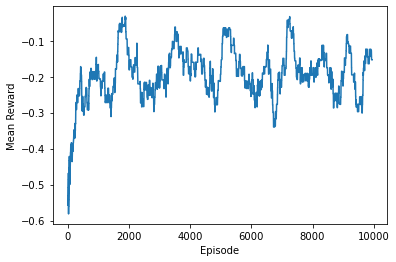

In [17]:
df = pd.read_csv("../../logs/MADDPG/contrib_MADDPG_3_vs_3_auto_GK_0c68f_00000_0_2022-07-21_15-59-06/progress.csv")
plt.plot(df.episode_reward_mean)
plt.xlabel("Episode")
plt.ylabel("Mean Reward")

Text(0, 0.5, 'Episode Max Reward')

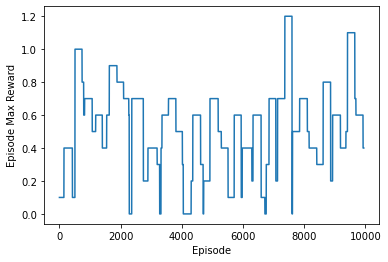

In [18]:
plt.plot(df.episode_reward_max)
plt.xlabel("Episode")
plt.ylabel("Episode Max Reward")